# Imports

In [1]:
#navigation
import os

#data wrangling
import pandas as pd
import numpy as np
import operator
from operator import itemgetter

#model building
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso, LassoCV
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import StandardScaler
from itertools import combinations
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from mlxtend.evaluate import feature_importance_permutation


#model scoring
from sklearn.metrics import r2_score, mean_squared_error,explained_variance_score, mean_absolute_error
import eli5

#data visualization
import matplotlib.pyplot as plt
import pylab 

#others
import warnings
warnings.filterwarnings(action='ignore')


/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)
Using TensorFlow backend.


In [2]:
import matplotlib
plt.rc('font', family='serif') # change font types for plots
plt.rc('xtick', labelsize='medium')
plt.rc('ytick', labelsize='medium')

# Data

In [3]:
file_path = './data/df_aggregated_spc.csv'
combined_data = pd.read_csv(file_path)
combined_data['dataset_original'] = combined_data['dataset']

#NTF2 topology should not be used so remove those rows
ntf2_inx = combined_data[combined_data['topology']=='NTF2'].index
combined_data = combined_data.drop(ntf2_inx)


print("Before: ",len(combined_data))

#make sure you only use Rocklin library
combined_data = combined_data[combined_data["dataset"]=="Rocklin"].reset_index(drop="True")



print("After: ",len(combined_data))

col_order = list(combined_data.columns.values)
col_order.insert(2, col_order.pop(col_order.index('dataset_original')))
combined_data = combined_data[col_order]
combined_data['stabilityscore_cnn_calibrated_2classes'] = combined_data['stabilityscore_cnn_calibrated'] > 1


train, test = train_test_split(combined_data, test_size=0.2, random_state=5, stratify=combined_data[['topology', 'dataset_original']])

# list of feature columns to use and/or normalize:
ros_fet_path =  './data/rosetta_features.csv'
spc_fet_path =  './data/entropy_features.csv'

ros_features = list(pd.read_csv(ros_fet_path).iloc[:,0])
spc_features = list(pd.read_csv(spc_fet_path).iloc[:,0])


feature_cols = ros_features+spc_features


Before:  80257
After:  16159


In [4]:
combined_data.describe()[spc_features]

S_PC  Mean_H_entropy  Mean_L_entropy  Mean_E_entropy  \
count  16159.000000    16159.000000    16159.000000    16159.000000   
mean       8.454796        0.035459        0.519237        0.190204   
std        4.184565        0.144341        0.158734        0.140972   
min      -11.389000       -0.597000       -0.069800       -0.356500   
25%        6.051000       -0.060021        0.410374        0.081792   
50%        8.965000        0.035833        0.521000        0.197167   
75%       11.326500        0.133038        0.629519        0.289000   
max       21.783000        0.555154        1.064000        0.805875   

       Mean_res_entropy  SumH_entropies  SumL_entropies  SumE_entropies  \
count      16159.000000    16159.000000    16159.000000    16159.000000   
mean           0.202816        0.413363        5.409969        2.631476   
std            0.102468        2.807020        1.644253        2.121031   
min           -0.264907      -13.902000       -0.698000       -3.894000   
25%            0.141826       -1.140000        4.292000        0.799500   
50%            0.213047        0.626000        5.415000        2.486000   
75%            0.273554        2.262000        6.522000        4.116000   
max            0.534975       10.512000       11.531000       10.394000   

       H_max_entropy  H_min_entropy  H_range_entropy  L_max_entropy  \
count   16159.000000   16159.000000     16159.000000   16159.000000   
mean        1.445003      -1.238004         2.683008       1.595573   
std         0.365907       0.395758         0.600815       0.399101   
min         0.073000      -3.667000         0.750000       0.537000   
25%         1.196000      -1.420000         2.243000       1.297000   
50%         1.391000      -1.185000         2.612000       1.601000   
75%         1.727000      -0.985000         3.121000       1.914500   
max         2.365000      -0.162000         5.609000       2.640000   

       L_min_entropy  L_range_entropy  E_max_entropy  E_min_entropy  \
count   16159.000000     16159.000000   16159.000000   16159.000000   
mean       -0.368628         1.964201       1.031362      -0.614157   
std         0.296785         0.489464       0.516884       0.373509   
min        -1.945000         0.351000       0.000000      -2.514000   
25%        -0.610000         1.620500       0.845000      -0.867000   
50%        -0.318000         1.971000       1.221000      -0.655000   
75%        -0.172000         2.288500       1.380000      -0.378000   
max         0.624000         3.861000       1.983000       0.172000   

       E_range_entropy  
count     16159.000000  
mean          1.645519  
std           0.817239  
min           0.000000  
25%           1.385000  
50%           1.893000  
75%           2.189000  
max           4.123000

In [5]:
def train_linear_regression(features):
    #set up splits
    X_train = train[features]
    y_train = train["S_PC"]

    X_test = test[features]
    y_test = test["S_PC"]

    #standardize features
    scaler = StandardScaler()
    scaler.fit(X_train)

    X_train_std = pd.DataFrame(scaler.transform(X_train),columns=X_train.columns)
    X_test_std = pd.DataFrame(scaler.transform(X_test),columns=X_test.columns)

    #merged X and y data
    X = pd.concat([X_train_std,X_test_std])
    y = pd.concat([y_train,y_test])
    
    
    #set up a linear regression trained to predict S_PC
    model_lnr = LinearRegression(normalize=False)

    #fit the data
    model_lnr.fit(X_train_std,y_train)

    #predict
    y_pred_lnr = model_lnr.predict(X_test_std)
    
    
    r2_val = r2_score(y_test.values,y_pred_lnr)
    
    return r2_val

In [6]:
def train_linear_regression_flexible(features,target_to_predict):
    #set up splits
    X_train = train[features]
    y_train = train[target_to_predict]

    X_test = test[features]
    y_test = test[target_to_predict]

    #standardize features
    scaler = StandardScaler()
    scaler.fit(X_train)

    X_train_std = pd.DataFrame(scaler.transform(X_train),columns=X_train.columns)
    X_test_std = pd.DataFrame(scaler.transform(X_test),columns=X_test.columns)

    #merged X and y data
    X = pd.concat([X_train_std,X_test_std])
    y = pd.concat([y_train,y_test])
    
    
    #set up a linear regression trained to predict S_PC
    model_lnr = LinearRegression(normalize=False)

    #fit the data
    model_lnr.fit(X_train_std,y_train)

    #predict
    y_pred_lnr = model_lnr.predict(X_test_std)
    
    
    r2_val = r2_score(y_test.values,y_pred_lnr)
    
    return r2_val

# Model Building

### Data Split

In [7]:
#set up splits
X_train = train[ros_features]
y_train = train["S_PC"]

X_test = test[ros_features]
y_test = test["S_PC"]

#standardize features
scaler = StandardScaler()
scaler.fit(X_train)

X_train_std = pd.DataFrame(scaler.transform(X_train),columns=X_train.columns)
X_test_std = pd.DataFrame(scaler.transform(X_test),columns=X_test.columns)

#merged X and y data
X = pd.concat([X_train_std,X_test_std])
X = X.reset_index(drop=True)

y = pd.concat([y_train,y_test])
y = y.reset_index(drop=True)

## Linear Regression

In [8]:
#set up a linear regression trained to predict S_PC
model_lnr = LinearRegression(normalize=False)

#fit the data
model_lnr.fit(X_train_std,y_train)

#predict
y_pred_lnr = model_lnr.predict(X_test_std)

#get results
print("R2 Score: ",r2_score(y_test.values,y_pred_lnr))
range_spc = y_test.max() - y_test.min() #get range of predicted values
print("RMSE/Range: ",np.sqrt(mean_squared_error(y_test.values,y_pred_lnr))/range_spc)
print("MAE/Range: ",mean_absolute_error(y_test.values,y_pred_lnr)/range_spc)

R2 Score:  0.811218754033234
RMSE/Range:  0.05942799354999872
MAE/Range:  0.04685839725240378


In [9]:
#code adapted from https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_predict.html#sphx-glr-auto-examples-model-selection-plot-cv-predict-py
predicted = cross_val_predict(model_lnr, X,y, cv=10)

In [10]:
print("Cross Validated R2:",round(r2_score(predicted, y),3))

Cross Validated R2: 0.766


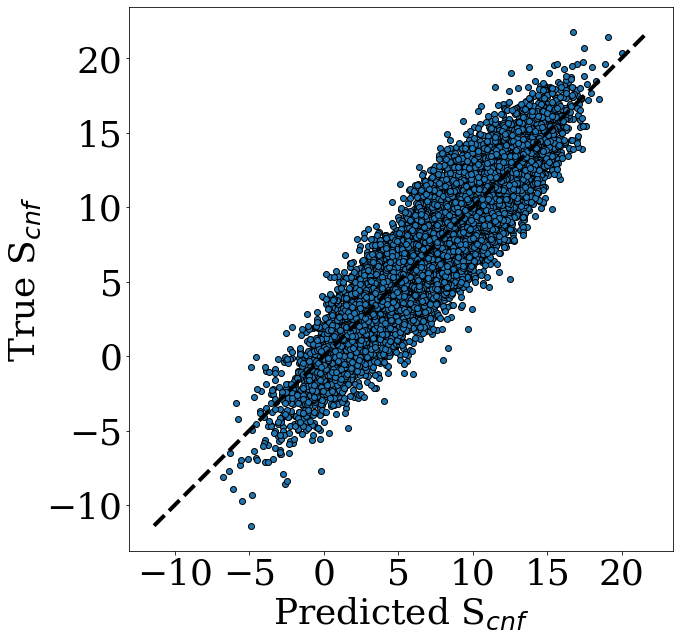

In [11]:
fig, ax = plt.subplots(1,1,figsize=(13,10),subplot_kw={"aspect":1})

plt.scatter(predicted,y, edgecolors=(0, 0, 0),label='predicted value')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
plt.ylabel('True S$_{cnf}$',fontsize="36")
plt.xticks(fontsize='36')
plt.yticks(fontsize='36')
plt.xlabel('Predicted S$_{cnf}$',fontsize="36")
#plt.legend(fontsize="30")

#plt.savefig("./SavedFigures/Figure5a",dpi=300,bbox_inches='tight')
plt.show()

In [32]:
#color coded plot by topologies
unique_topologies = combined_data.topology.unique()

In [33]:
unique_topologies

array(['EEHEE', 'EHEE', 'HEEH', 'HHH'], dtype=object)

In [34]:
inx_dict = {}

reindexed_df = combined_data.iloc[y.index,:]
for top in unique_topologies:
    #will generate a key entry with list of indices of proteins in given topology
    inx_dict[top] = reindexed_df[reindexed_df["topology"]==top].index


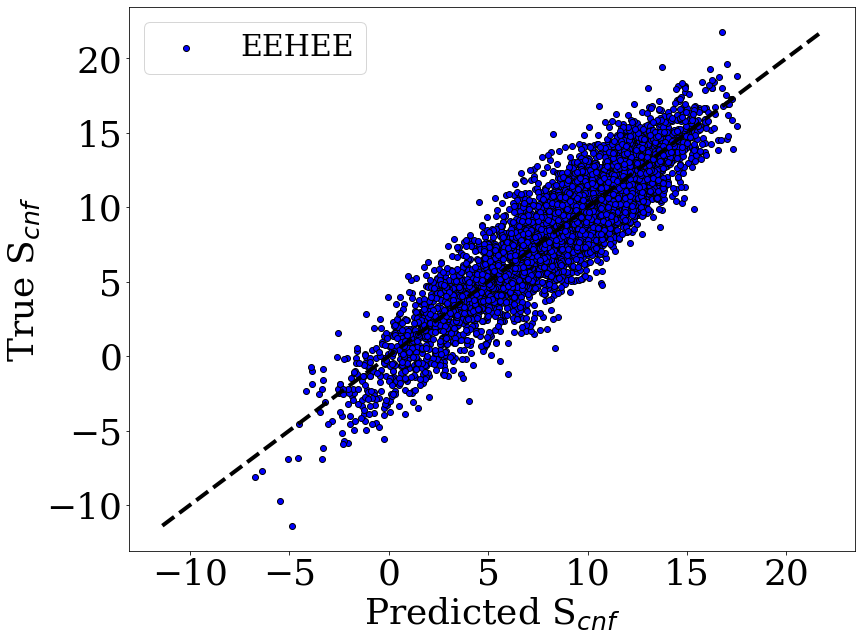

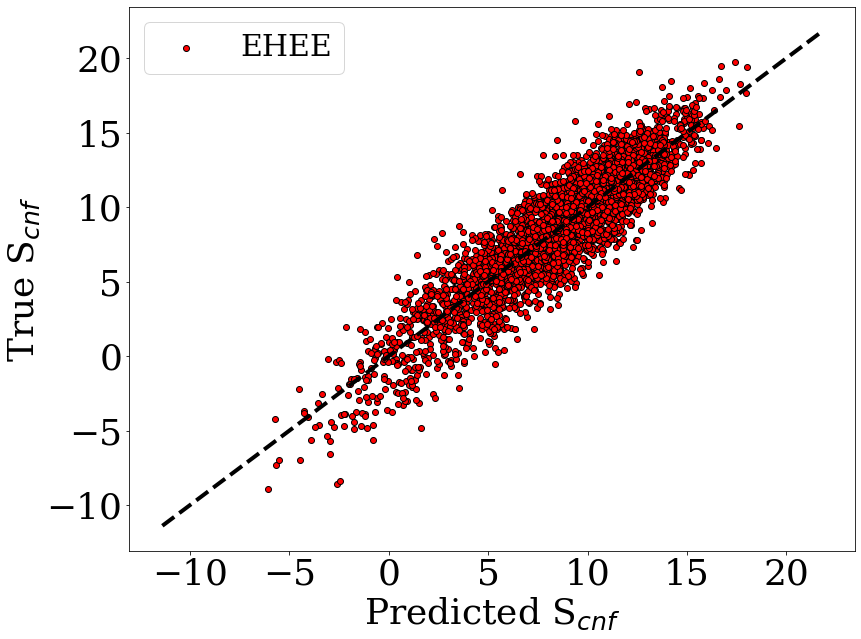

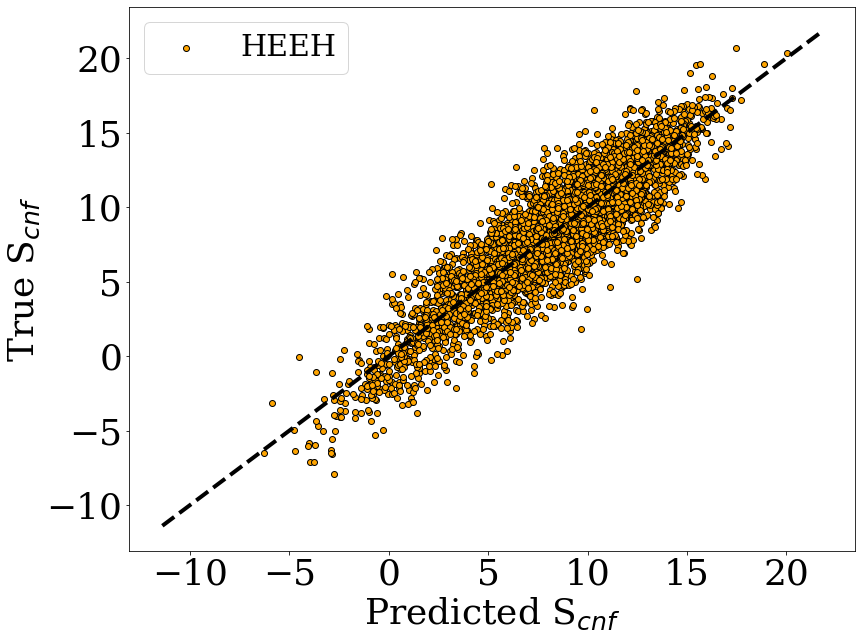

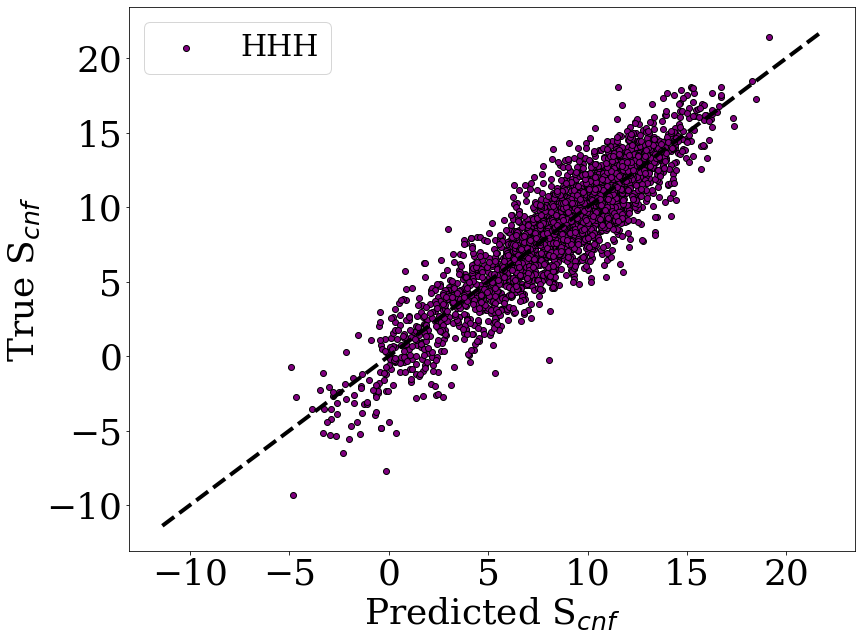

In [35]:
golden = (1 + 5**(1/2))/2
colors = ["blue","red",'orange','purple','green','grey',
          'darkorange','darkblue','yellow','black','skyblue']

for i in range(len(inx_dict.keys())):
    fig, ax = plt.subplots(1,1,figsize=(13,10))
    key = unique_topologies[i]
    inxs = combined_data.iloc[inx_dict[key],:]['topology'].index
    plt.scatter(predicted[inxs],y[inxs], edgecolors=(0, 0, 0),label=unique_topologies[i],color=colors[i])
    plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
    plt.ylabel('True S$_{cnf}$',fontsize="36")
    plt.xticks(fontsize='36')
    plt.yticks(fontsize='36')
    plt.xlabel('Predicted S$_{cnf}$',fontsize="36")
    plt.legend(fontsize="30")
    #plt.title("Linear Regression of Rosetta Features predicting S$_{cnf}$",fontsize="28")
    #plt.savefig("./SavedFigures/Figure5a_%s"%unique_topologies[i],dpi=300,bbox_inches='tight')
    plt.show()

## Regression Coefficients

In [36]:
train_linear_regression(["buried_np","exposed_hydrophobics","buried_minus_exposed"])

0.12462822171269627

In [37]:
zipped_coeff = zip(ros_features,list(model_lnr.coef_))
coeff_dict = {}
for pair in zipped_coeff:
    #print(pair)
    if abs(pair[1]) > 10**3:
        coeff_dict[pair[0]] = pair[1]

In [38]:
sorted_dict_tuple = sorted(coeff_dict.items(), key=operator.itemgetter(1))
sorted_coeff_dict = dict(sorted_dict_tuple)

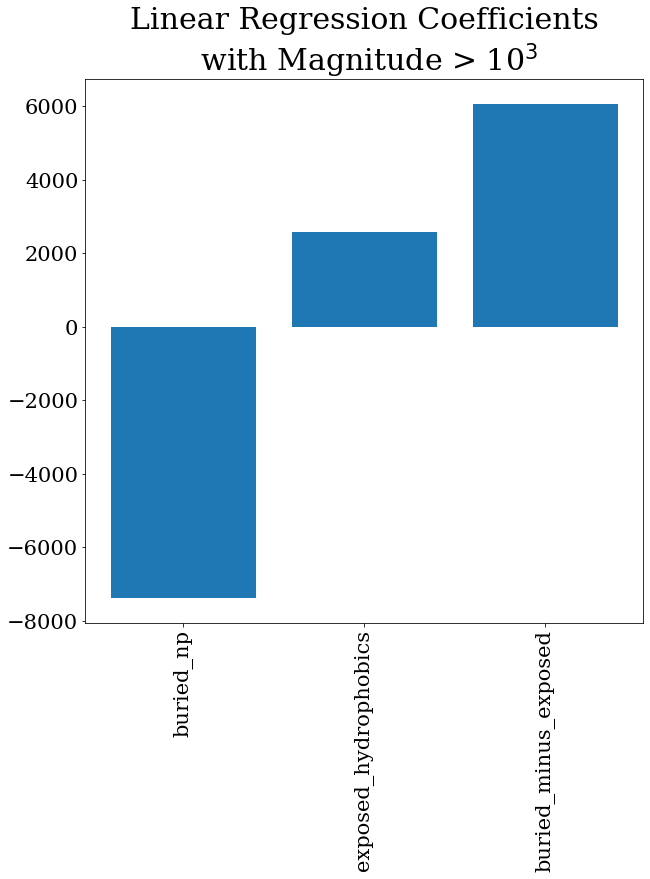

In [39]:
sorted_coeffs = [sorted_coeff_dict[key] for key in sorted_coeff_dict]
f, ax = plt.subplots(figsize=(10,10))
ax.bar(sorted_coeff_dict.keys(), sorted_coeffs)
plt.xticks(rotation="90",fontsize="21")
plt.yticks(fontsize='21')
plt.title("Linear Regression Coefficients\n with Magnitude > 10$^{3}$",fontsize=30)
plt.show()

In [40]:
imp_vals, imp_all = feature_importance_permutation(
    predict_method=model_lnr.predict, 
    X=X_test_std.values,
    y=y_test,
    metric='r2',
    num_rounds=10)


std = np.std(imp_all, axis=1)

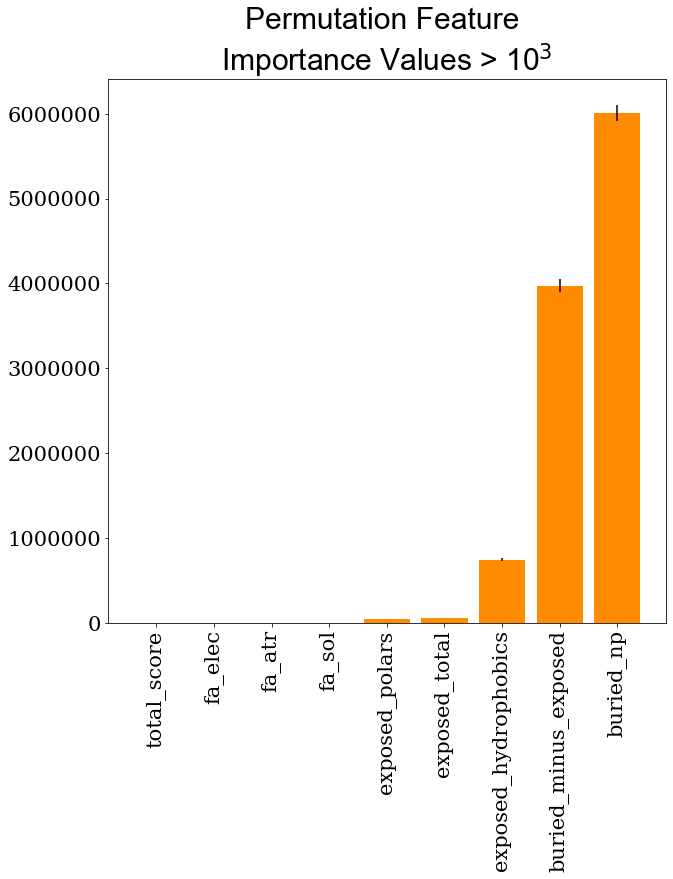

In [41]:
zipped_perm = zip(X_test_std.columns,list(imp_vals),std)
perm_dict = {}
for pair in zipped_perm:
    if abs(pair[1]) > 10**3:
        perm_dict[pair[0]] = [pair[1],pair[2]]

sorted_dict_tuple = sorted(perm_dict.items(), key=operator.itemgetter(1))
sorted_perm_dict = dict(sorted_dict_tuple)

sorted_coeffs = [sorted_perm_dict[key][0] for key in sorted_perm_dict]
sorted_coeffs_std = [sorted_perm_dict[key][1] for key in sorted_perm_dict]
f, ax = plt.subplots(figsize=(10,10))
ax.bar(sorted_perm_dict.keys(), sorted_coeffs,yerr=sorted_coeffs_std,color='darkorange')
plt.xticks(rotation="90",fontsize="21")
plt.yticks(fontsize='21')
model_score = round(model_lnr.score(X_test_std,y_test),3)
plt.title("Permutation Feature \nImportance Values > 10$^{3}$",fontsize=30,fontname='Arial')
plt.show()

In [42]:
#make a dictionary of absolute values
abs_val_dict = {}
for key,val in sorted_coeff_dict.items():
    abs_val_dict[key] = abs(val)
#sort the dictionary by decreasing order of absolute value
sorted_abs_val_dict = dict(sorted(abs_val_dict.items(), key=operator.itemgetter(1),reverse=True))

#get the names of the ordered dictionary features
ordered_list_names = list(sorted_abs_val_dict.keys())

#make an index map of those names
index_map = {v: i for i, v in enumerate(ordered_list_names)}


#sort the true values by this new index map
abs_sorted_coeff_dict = dict(sorted(sorted_coeff_dict.items(), key=lambda pair: index_map[pair[0]]))

In [43]:
original = .8112
new = []
fets_to_drop = list(abs_sorted_coeff_dict.keys())
fets_dropped = []

list_of_fets_dropped = []

for feature in fets_to_drop:
    
    new_ros_features = ros_features.copy() #make a copy of rosetta features
    for i in [feature]+fets_dropped:
        new_ros_features.remove(i) #drop the feature you are currently iterating on plus prev fets
    

    
    r2_val = train_linear_regression(new_ros_features)
    
    new.append(r2_val)
    
    copy_fets_dropped = fets_dropped.copy()
    copy_fets_dropped+=[feature]
    fets_dropped+=[feature]

    
    
    list_of_fets_dropped.append(copy_fets_dropped)

In [44]:
delta = [val - original for val in new]

results = pd.DataFrame(list(zip(list_of_fets_dropped,new,delta)))

In [45]:
results

0         1         2
0                                        [buried_np]  0.811254  0.000054
1                  [buried_np, buried_minus_exposed]  0.811169 -0.000031
2  [buried_np, buried_minus_exposed, exposed_hydr...  0.811139 -0.000061

## Overabundance of alpha helices? 

In [46]:
# don't stratify data
train1, test1 = train_test_split(combined_data, test_size=0.2, random_state=4)

In [47]:
#set up splits
features=ros_features

X_train = train1[features]
y_train = train1["S_PC"]

X_test = test1[features]
y_test = test1["S_PC"]

#standardize features
scaler = StandardScaler()
scaler.fit(X_train)

X_train_std = pd.DataFrame(scaler.transform(X_train),columns=X_train.columns)
X_test_std = pd.DataFrame(scaler.transform(X_test),columns=X_test.columns)

#merged X and y data
X = pd.concat([X_train_std,X_test_std])
y = pd.concat([y_train,y_test])


#set up a linear regression trained to predict S_PC
model_lnr = LinearRegression(normalize=False)

#fit the data
model_lnr.fit(X_train_std,y_train)

#code adapted from https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_predict.html#sphx-glr-auto-examples-model-selection-plot-cv-predict-py
predicted = cross_val_predict(model_lnr, X,y, cv=10)

In [48]:
print("non Cross Validated R2:",round(r2_score(y_test.values,model_lnr.predict(X_test_std)),3))
print("Cross Validated R2:",round(r2_score(y,predicted),3))

non Cross Validated R2: 0.811
Cross Validated R2: 0.81


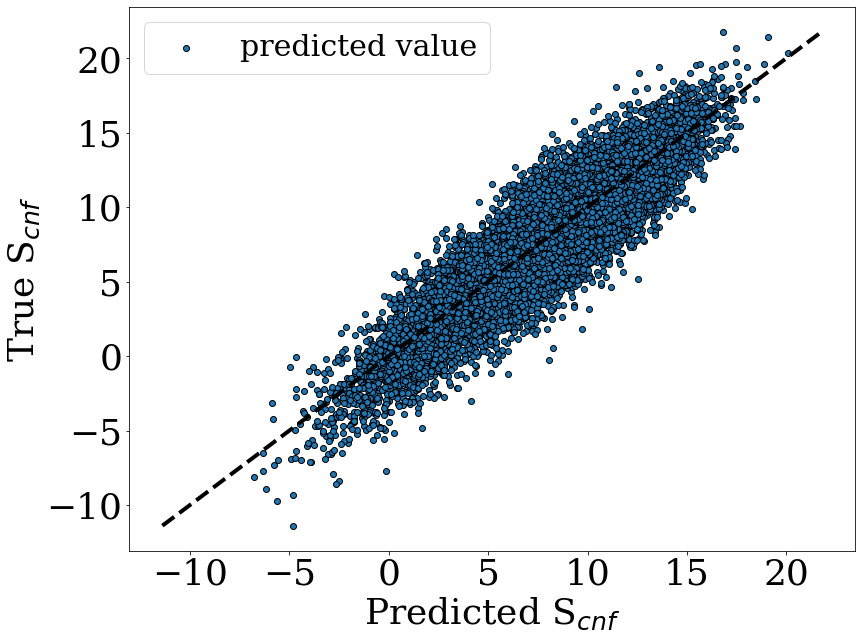

In [49]:
fig, ax = plt.subplots(1,1,figsize=(13,10))

plt.scatter(predicted,y, edgecolors=(0, 0, 0),label='predicted value')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
plt.ylabel('True S$_{cnf}$',fontsize="36")
plt.xticks(fontsize='36')
plt.yticks(fontsize='36')
plt.xlabel('Predicted S$_{cnf}$',fontsize="36")
plt.legend(fontsize="30")

plt.show()

Notice that whether or not you stratify the dataset on topology, the R-Squared value does not dramatically change. The Cross Validated R-Squared only increases a little in the unstratified from 0.863 to 0.879.

## Can R features predict other Scnf features? 

In [50]:
def can_R_predict(input_feature,alpha=0.1):
    print("FEATURE: ",input_feature)
    #set up splits
    X_train = train[ros_features]
    y_train = train[input_feature]

    X_test = test[ros_features]
    y_test = test[input_feature]

    #standardize features
    scaler = StandardScaler()
    scaler.fit(X_train)

    X_train_std = pd.DataFrame(scaler.transform(X_train),columns=X_train.columns)
    X_test_std = pd.DataFrame(scaler.transform(X_test),columns=X_test.columns)

    #merged X and y data
    X = pd.concat([X_train_std,X_test_std])
    X = X.reset_index(drop=True)

    y = pd.concat([y_train,y_test])
    y = y.reset_index(drop=True)
    
    
    # set up lasso regression
    lasso_1 = Lasso(alpha=alpha)

    lasso_1.fit(X_train_std,y_train)
    predicted = lasso_1.predict(X_test_std)
    lasso_1.score(X_test_std,y_test)

    lasso_coeffs = list(zip(X_train_std.columns,lasso_1.coef_))
    print(f"alpha= {alpha}")
    
    
    
#     zipped_results=lasso_coeffs
#     model=lasso_1
#     cutoff=0
#     coeff_dict = {}
#     for pair in zipped_results:
#         #print(pair)
#         if abs(pair[1]) > cutoff:
#             coeff_dict[pair[0]] = pair[1]

#     sorted_dict_tuple = sorted(coeff_dict.items(), key=operator.itemgetter(1))
#     sorted_coeff_dict = dict(sorted_dict_tuple)

#     sorted_coeffs = [sorted_coeff_dict[key] for key in sorted_coeff_dict]
    
    
#     f, ax = plt.subplots(0,0,figsize=(13,10),subplot_kw={"aspect":1.618})
#     plt.bar(sorted_coeff_dict.keys(), sorted_coeffs)
#     plt.xticks(rotation="90",fontsize="22")
#     plt.yticks(fontsize='36')
    
    
#     textstr = "α = %s, R² = %0.3f"%(model.alpha,model.score(X_test_std,y_test))
#     # these are matplotlib.patch.Patch properties
#     props = dict(boxstyle='round', facecolor='white', alpha=0.5)
#     plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=30,
#         verticalalignment='top',bbox=props)
    
#     #plt.savefig(f"./SavedFigures/Lasso_R2_{str(round(model.score(X_test_std,y_test),3))}.png",
#      #           dpi=300,bbox_inches='tight')
#     plt.show()
    
#     fig, ax = plt.subplots(0,0,figsize=(13,10),subplot_kw={"aspect":1})

#     plt.scatter(predicted,y_test, edgecolors=(0, 0, 0),label='predicted value')
#     plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
#     plt.ylabel('True S$_{cnf}$',fontsize="36")
#     plt.xticks(fontsize='36')
#     plt.yticks(fontsize='36')
#     plt.xlabel('Predicted S$_{cnf}$',fontsize="36")
#     #plt.legend(fontsize="30")

#     #plt.savefig("./SavedFigures/Figure5a",dpi=300,bbox_inches='tight')
#     plt.show()
    

    return input_feature, alpha, lasso_1.score(X_test_std,y_test), len(lasso_1.coef_[lasso_1.coef_ > 0]) # return alpha, R2, and number of fets used

In [51]:
results = []
for a in [0,0.01, 0.05, 0.07, 0.1,0.5]:
    for fet in spc_features:
        row = list(can_R_predict(fet,alpha=a))
        results.append(row)

FEATURE:  S_PC
alpha= 0
FEATURE:  Mean_H_entropy
alpha= 0
FEATURE:  Mean_L_entropy
alpha= 0
FEATURE:  Mean_E_entropy
alpha= 0
FEATURE:  Mean_res_entropy
alpha= 0
FEATURE:  SumH_entropies
alpha= 0
FEATURE:  SumL_entropies
alpha= 0
FEATURE:  SumE_entropies
alpha= 0
FEATURE:  H_max_entropy
alpha= 0
FEATURE:  H_min_entropy
alpha= 0
FEATURE:  H_range_entropy
alpha= 0
FEATURE:  L_max_entropy
alpha= 0
FEATURE:  L_min_entropy
alpha= 0
FEATURE:  L_range_entropy
alpha= 0
FEATURE:  E_max_entropy
alpha= 0
FEATURE:  E_min_entropy
alpha= 0
FEATURE:  E_range_entropy
alpha= 0
FEATURE:  S_PC
alpha= 0.01
FEATURE:  Mean_H_entropy
alpha= 0.01
FEATURE:  Mean_L_entropy
alpha= 0.01
FEATURE:  Mean_E_entropy
alpha= 0.01
FEATURE:  Mean_res_entropy
alpha= 0.01
FEATURE:  SumH_entropies
alpha= 0.01
FEATURE:  SumL_entropies
alpha= 0.01
FEATURE:  SumE_entropies
alpha= 0.01
FEATURE:  H_max_entropy
alpha= 0.01
FEATURE:  H_min_entropy
alpha= 0.01
FEATURE:  H_range_entropy
alpha= 0.01
FEATURE:  L_max_entropy
alpha= 0.01

In [52]:
results_df = pd.DataFrame(results, columns=["Feature","alpha","R2","n_features"])
print(results_df.to_string())

              Feature  alpha            R2  n_features
0                S_PC   0.00  8.084333e-01          56
1      Mean_H_entropy   0.00  5.900181e-01          54
2      Mean_L_entropy   0.00  4.914173e-01          47
3      Mean_E_entropy   0.00  5.463634e-01          48
4    Mean_res_entropy   0.00  8.192915e-01          57
5      SumH_entropies   0.00  6.284015e-01          55
6      SumL_entropies   0.00  4.743614e-01          47
7      SumE_entropies   0.00  7.164483e-01          59
8       H_max_entropy   0.00  5.550884e-01          61
9       H_min_entropy   0.00  4.112522e-01          53
10    H_range_entropy   0.00  5.862573e-01          56
11      L_max_entropy   0.00  2.295492e-01          52
12      L_min_entropy   0.00  4.065294e-01          57
13    L_range_entropy   0.00  2.918823e-01          43
14      E_max_entropy   0.00  7.995910e-01          40
15      E_min_entropy   0.00  6.718929e-01          77
16    E_range_entropy   0.00  8.490096e-01          34
17        

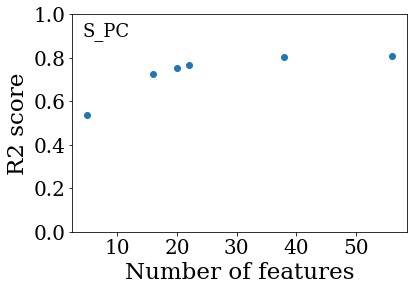

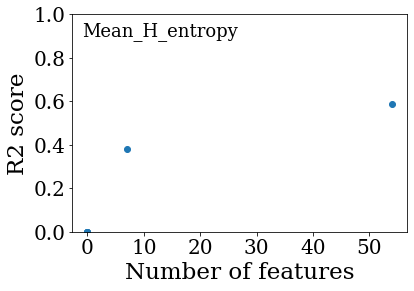

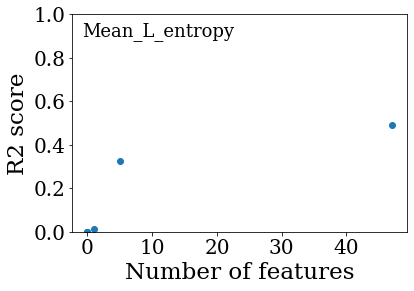

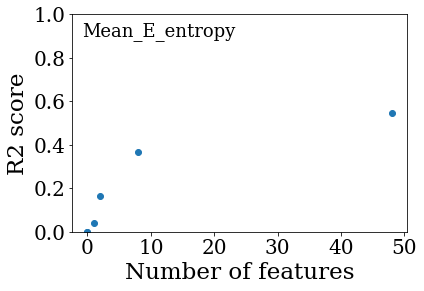

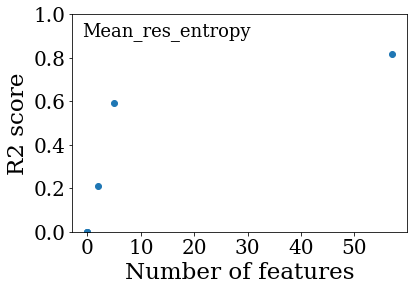

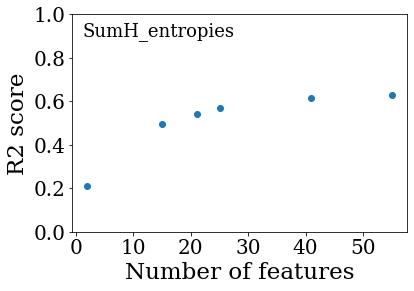

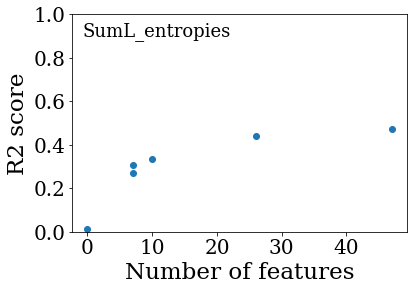

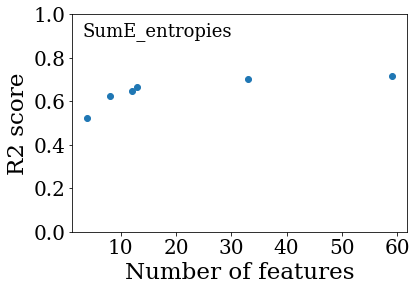

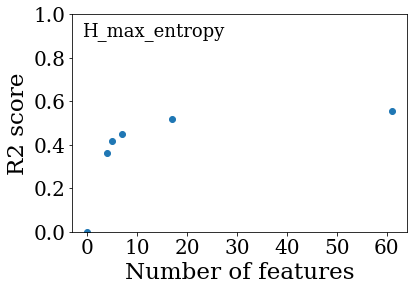

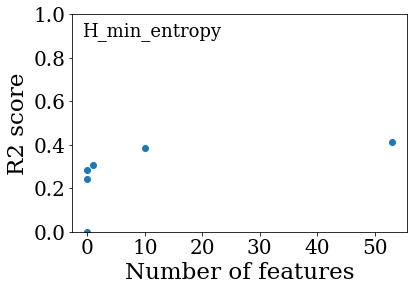

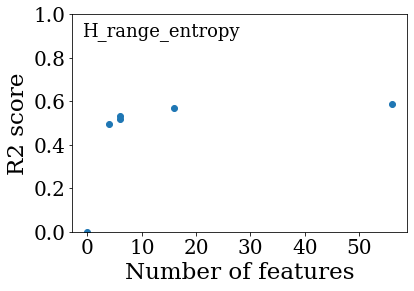

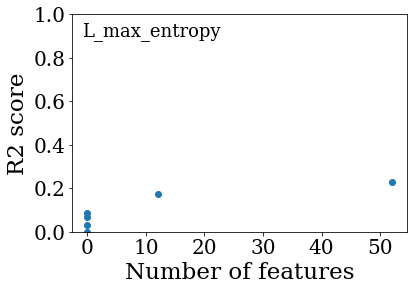

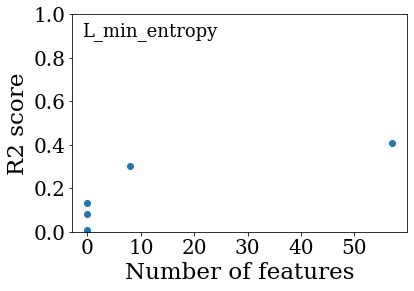

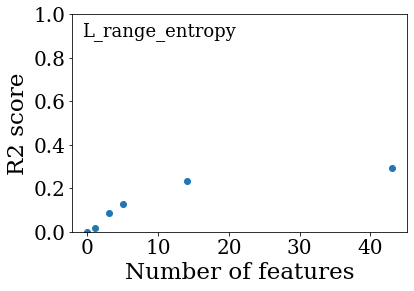

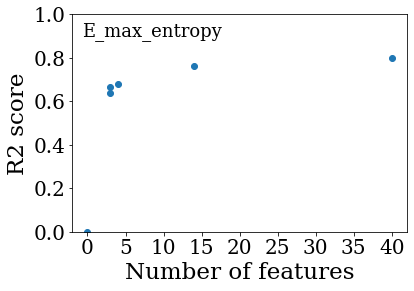

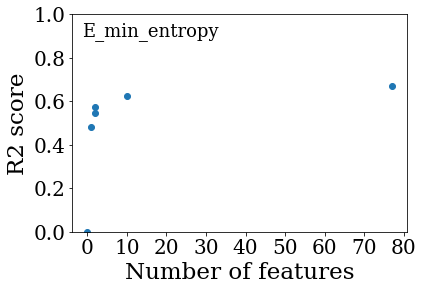

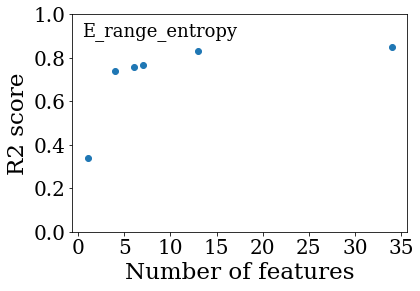

In [53]:
for fet in spc_features:
    plt.figure()
    ax = plt.gca()
    plt.yticks(fontsize='20')
    plt.ylim(0,1)
    plt.xticks(fontsize='20')
    plt.scatter(
            results_df[results_df["Feature"]==fet]["n_features"],
            results_df[results_df["Feature"]==fet]["R2"]
    )
    plt.text(0.03, .9,fet,fontsize='18', transform=ax.transAxes)
    plt.ylabel("R2 score",fontsize='23')
    plt.xlabel("Number of features",fontsize='23')
    plt.show()

## Mutual information

In [140]:
from sklearn.feature_selection import mutual_info_regression

In [141]:
#set up splits
X_train = train[ros_features]
y_train = train["S_PC"]

X_test = test[ros_features]
y_test = test["S_PC"]

#standardize features
scaler = StandardScaler()
scaler.fit(X_train)

X_train_std = pd.DataFrame(scaler.transform(X_train),columns=X_train.columns)
X_test_std = pd.DataFrame(scaler.transform(X_test),columns=X_test.columns)

#merged X and y data
X = pd.concat([X_train_std,X_test_std])
y = pd.concat([y_train,y_test])

In [142]:
limits = range(100,1005,20)
y_axis_cv = []
cv = 30

for i in range(cv):
    y_axis_all = []
    for n in limits:
        X_sample = X.sample(n)
        mi_results = mutual_info_regression(X_sample,y[X_sample.index])
        y_axis_all.append(mi_results)
    y_axis_cv.append(y_axis_all)




In [143]:
objs = []
for i in y_axis_cv:
    objs.append(pd.DataFrame(i))


In [144]:
df_cv = pd.concat(objs,axis=0)
df_cv.columns = X_train.columns

In [145]:
counter = 0
for i in range(46*5):
    if counter == 45:
        counter=0
    
    df_cv.index[i]
    

In [146]:
# get mean values of cross validated results
mean_cv = df_cv.groupby(df_cv.index).mean()
mean_cv.index = list(limits)
# get std values of cross validated results
std_cv = df_cv.groupby(df_cv.index).std()
std_cv.index = list(limits)

In [147]:
print(mean_cv.iloc[-1,:].sort_values(ascending=False))

exposed_np_AFILMVWY        1.566744e-02
worst6frags                1.551430e-02
frac_helix                 1.492341e-02
net_atr_net_sol_per_res    1.483827e-02
nres_helix                 1.425243e-02
                               ...     
p_aa_pp                    4.464168e-03
ss_contributes_core        2.704773e-03
buns_sc_heavy              2.158703e-03
entropy                    4.992996e-06
dslf_fa13                  8.050466e-07
Name: 1000, Length: 113, dtype: float64


In [148]:
mean_cv.iloc[-1,:].sort_values(ascending=False).index[:20].values

array(['exposed_np_AFILMVWY', 'worst6frags', 'frac_helix',
       'net_atr_net_sol_per_res', 'nres_helix', 'Tend_netq', 'omega',
       'frac_loop', 'fa_dun_semi', 'lk_ball_bridge_uncpl',
       'fxn_exposed_is_np', 'netcharge', 'ref', 'score_per_res',
       'avg_all_frags', 'lk_ball', 'fa_atr', 'hbond_bb_sc',
       'fa_rep_per_res', 'buried_minus_exposed'], dtype=object)

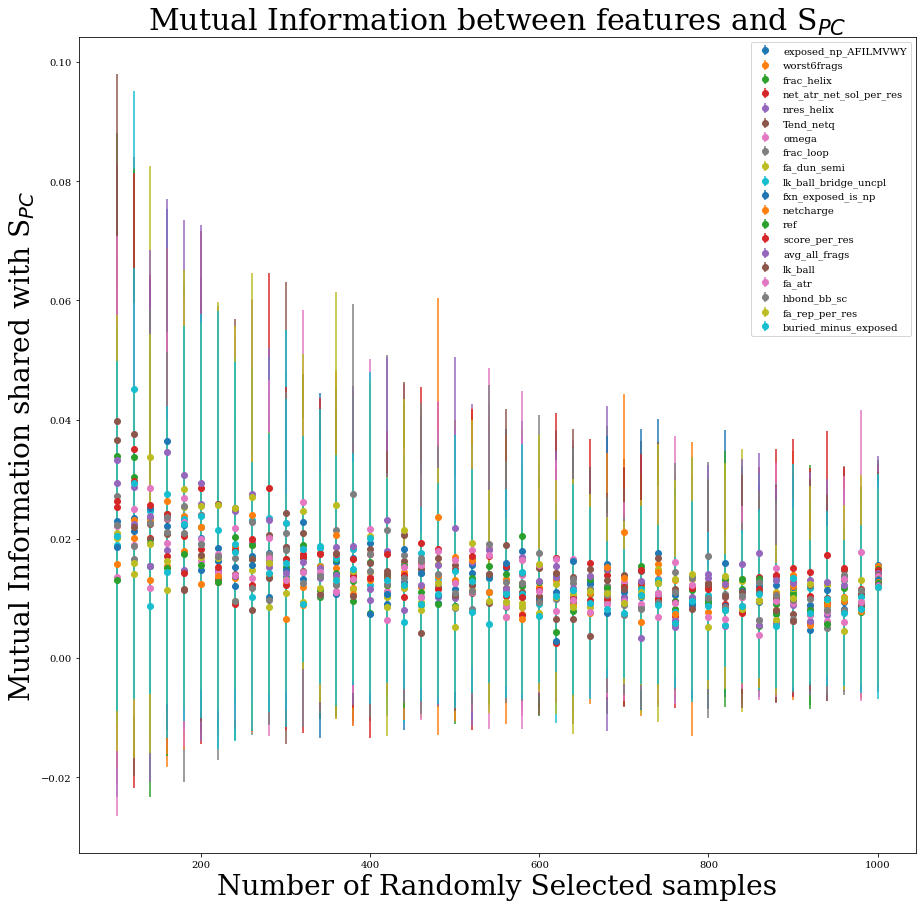

In [149]:
import seaborn as sns
plt.figure(figsize=(15,15))
for fet in mean_cv.iloc[-1,:].sort_values(ascending=False).index[:20]:
    plt.errorbar(mean_cv.index,mean_cv[fet].values,yerr=std_cv[fet],fmt='o',label=fet)
plt.legend()
plt.xlabel("Number of Randomly Selected samples",fontsize="28")
plt.ylabel("Mutual Information shared with S$_{PC}}$",fontsize="28")
plt.title("Mutual Information between features and S$_{PC}$",fontsize="30")
#plt.savefig("Figure7",bbox_inches="tight",dpi=300)
plt.show()

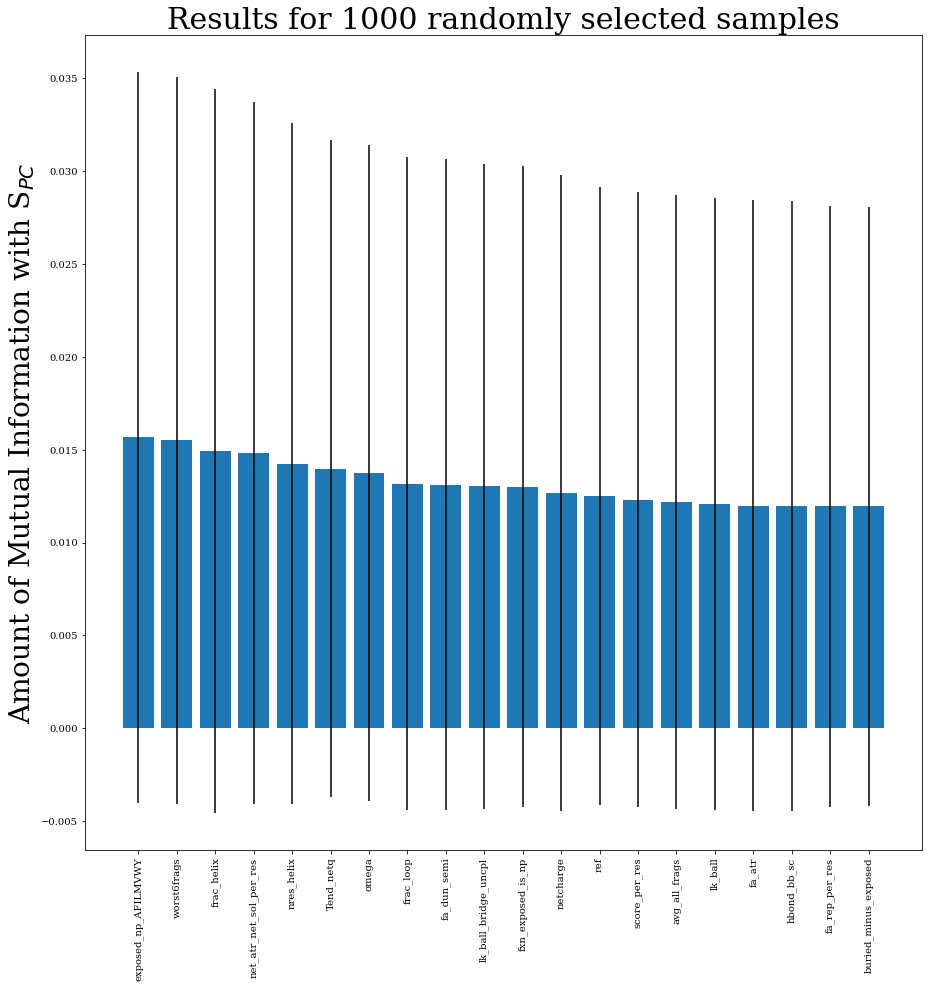

In [150]:
boop = mean_cv.iloc[-1,:].sort_values(ascending=False)
# boop =  boop[boop > .01]

boop_err = std_cv.iloc[-1,:].sort_values(ascending=False)
# boop_err = boop_err[boop > .01]

plt.figure(figsize=(15,15))
plt.bar(boop.index[:20],boop.values[:20],yerr=boop_err.values[:20])
plt.xticks(rotation="90")
plt.ylabel("Amount of Mutual Information with S$_{PC}$",fontsize="28")
plt.title("Results for 1000 randomly selected samples",fontsize="30")
plt.show()


In [151]:
mean_cv.iloc[-1,:][mean_cv.iloc[-1,:] > 0]

AlaCount          0.006886
T1_absq           0.009488
T1_netq           0.007859
Tend_absq         0.007963
Tend_netq         0.013987
                    ...   
total_score       0.007485
tryp_cut_sites    0.008200
two_core_each     0.011880
worst6frags       0.015514
worstfrag         0.008919
Name: 1000, Length: 113, dtype: float64

## Feature Downselection (K-Best)

In [12]:
from sklearn.feature_selection import SelectKBest
import sklearn

In [13]:
kbest = SelectKBest(score_func=sklearn.feature_selection.f_regression, k=40)
kbest.fit(X,y)
downselected_features = sorted(list(zip(kbest.scores_,X.columns)),reverse=True)

In [14]:
pd.DataFrame(downselected_features,columns=["F1-Score","Feature"]).to_csv("./data/DownselectedScores.csv",index=False)

In [15]:
print("")
for i in range(22):
    print(downselected_features[i])


(nan, 'dslf_fa13')
(nan, 'entropy')
(11385.847649606336, 'lk_ball_iso')
(10862.963761537902, 'hbond_sr_bb')
(10492.399017644126, 'fa_atr')
(10338.900731585067, 'frac_sheet')
(10229.036110788413, 'nres_sheet')
(10066.055430728584, 'nres_helix')
(9911.57671090477, 'frac_helix')
(9318.316595338849, 'net_sol_per_res')
(9042.142472437983, 'fa_atr_per_res')
(8919.599198316226, 'hbond_lr_bb_per_sheet')
(8531.758763471678, 'bb')
(8406.284666566977, 'hbond_lr_bb')
(8091.921831468602, 'lk_ball')
(6594.804346033034, 'net_atr_per_res')
(6214.772681225935, 'fa_sol')
(5172.735031932249, 'holes')
(4868.1695963992215, 'Tend_absq')
(4860.17885835469, 'degree')
(4605.187904861345, 'nres')
(4605.187904861345, 'n_res')


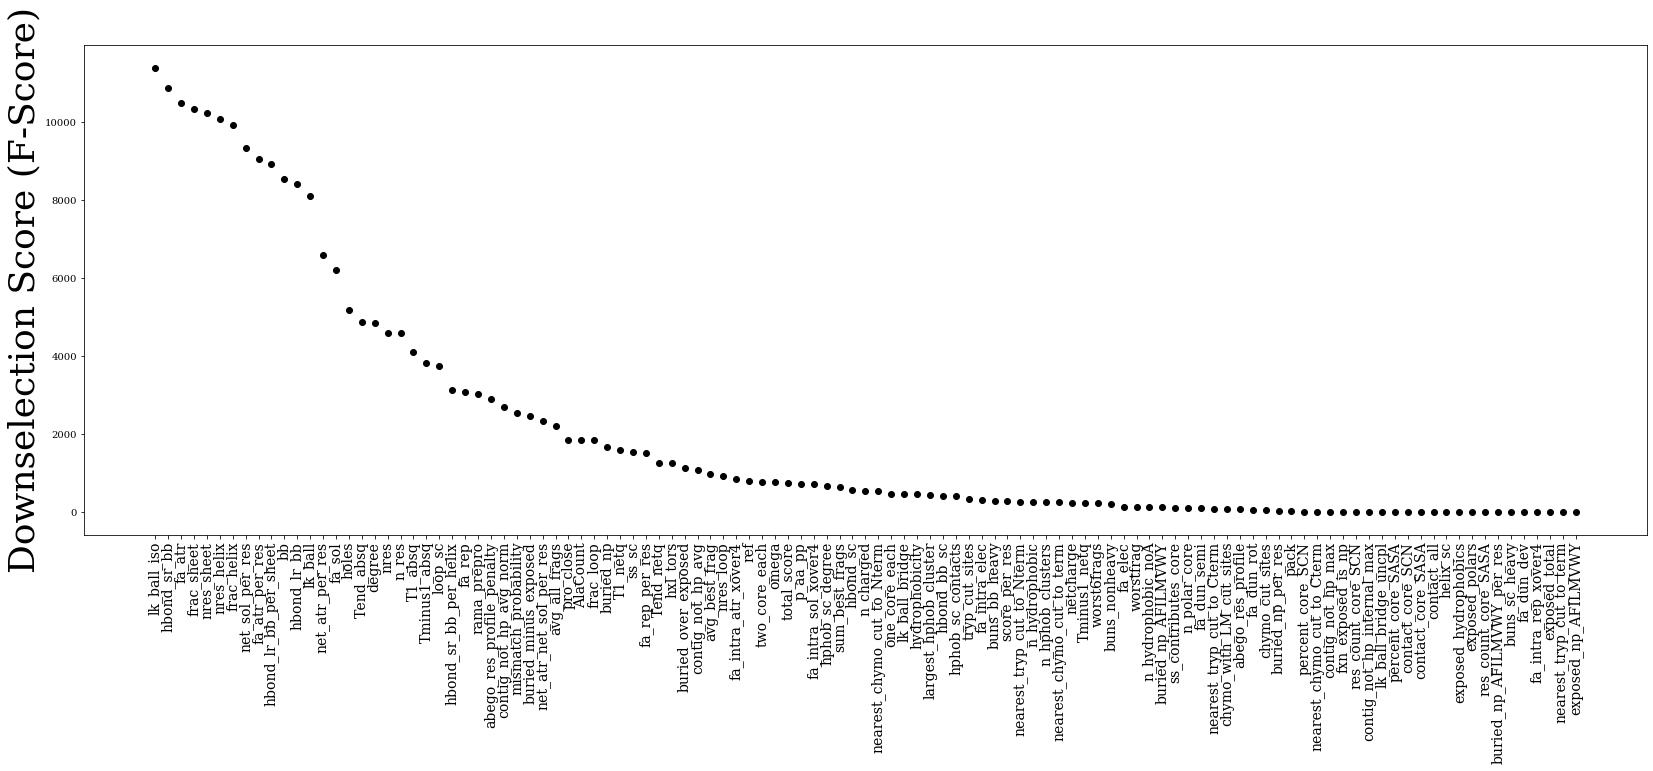

In [16]:
plt.figure(figsize=(28,9))
plt.scatter([i[1] for i in downselected_features[2:]],[i[0] for i in downselected_features[2:]],color='black')
plt.ylabel("Downselection Score (F-Score)",fontsize="36")
#plt.title("Downselected Feature Importances",fontsize="30")
plt.xticks(rotation="90",fontsize='14')
#plt.savefig("./SavedFigures/DownselectedFeatureImportances",dpi=1200, bbox_inches='tight')
plt.show()

It seems like after the first 20 or so features the downselection tool starts to value the features as much less important. Let's see for how much variance the first 20 features account for:


I'm actually going to choose 40 in order to compare them to the Lasso Coefficients

In [17]:
n_fets = 40

print("Features used: \n",[i[1] for i in downselected_features[2:(2+n_fets)]])
print()
print("R2 score:")
print(train_linear_regression([i[1] for i in downselected_features[2:(2+n_fets)]]))


Features used: 
 ['lk_ball_iso', 'hbond_sr_bb', 'fa_atr', 'frac_sheet', 'nres_sheet', 'nres_helix', 'frac_helix', 'net_sol_per_res', 'fa_atr_per_res', 'hbond_lr_bb_per_sheet', 'bb', 'hbond_lr_bb', 'lk_ball', 'net_atr_per_res', 'fa_sol', 'holes', 'Tend_absq', 'degree', 'nres', 'n_res', 'T1_absq', 'Tminus1_absq', 'loop_sc', 'hbond_sr_bb_per_helix', 'fa_rep', 'rama_prepro', 'abego_res_profile_penalty', 'contig_not_hp_avg_norm', 'mismatch_probability', 'buried_minus_exposed', 'net_atr_net_sol_per_res', 'avg_all_frags', 'pro_close', 'AlaCount', 'frac_loop', 'buried_np', 'T1_netq', 'ss_sc', 'fa_rep_per_res', 'Tend_netq']

R2 score:
0.6460996344380115


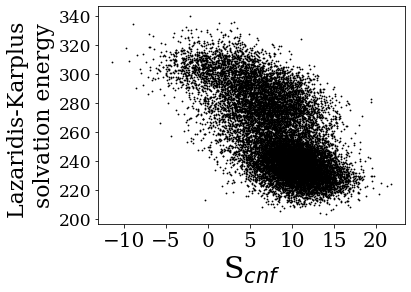

In [25]:
plt.plot(combined_data['S_PC'],combined_data["lk_ball_iso"],marker='o',markersize=.8,linestyle='',c='black')
plt.gca().set_aspect(1/5.8)
plt.xlabel("S$_{cnf}$",fontsize="30")
plt.ylabel("Lazaridis-Karplus \nsolvation energy",fontsize="22")

plt.yticks(fontsize="17")
plt.xticks(fontsize='20')

#plt.title("S$_{cnf}$ vs number of a-helices",fontsize='25')
#plt.savefig("../EXCESS_Configurational_Entropy_Publication/FinalFigures/Figure4.png",dpi=1200,bbox_inches='tight')
plt.show()


#### are we only seeing proteins with higher hydrophobicity have higher Scnf?

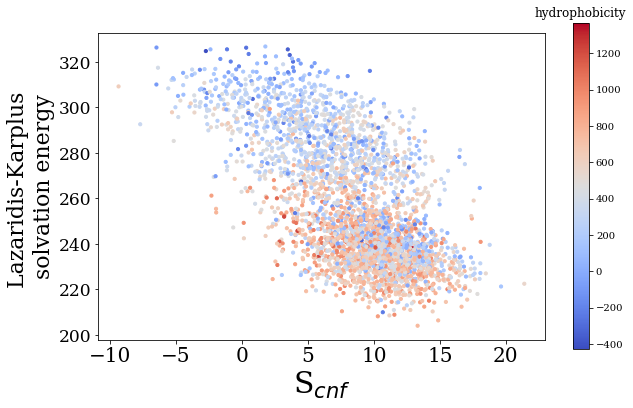

In [61]:
plt.figure(figsize=(10,10))
plt.scatter(x=test['S_PC'],y=test["lk_ball_iso"],marker='o',s=10,c=test["hydrophobicity"],cmap=plt.cm.coolwarm)
plt.gca().set_aspect(1/5.8)
plt.xlabel("S$_{cnf}$",fontsize="30")
plt.ylabel("Lazaridis-Karplus \nsolvation energy",fontsize="22")

plt.yticks(fontsize="17")
plt.xticks(fontsize='20')

#plt.title("S$_{cnf}$ vs number of a-helices",fontsize='25')
#plt.savefig("../EXCESS_Configurational_Entropy_Publication/FinalFigures/Figure4.png",dpi=1200,bbox_inches='tight')
cbar = plt.colorbar(shrink=.6)
cbar.ax.set_title("hydrophobicity")
cbar.ax.set_ylim(test["hydrophobicity"].min(), test["hydrophobicity"].max())
plt.show()

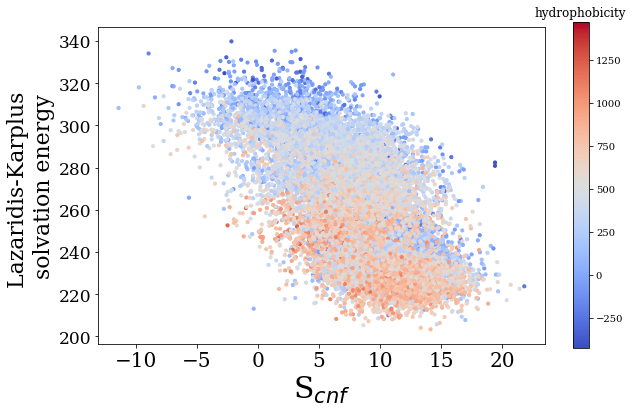

In [26]:
plt.figure(figsize=(10,10))
plt.scatter(x=combined_data['S_PC'],y=combined_data["lk_ball_iso"],marker='o',s=10,c=combined_data["hydrophobicity"],cmap=plt.cm.coolwarm)
plt.gca().set_aspect(1/5.8)
plt.xlabel("S$_{cnf}$",fontsize="30")
plt.ylabel("Lazaridis-Karplus \nsolvation energy",fontsize="22")

plt.yticks(fontsize="17")
plt.xticks(fontsize='20')

#plt.title("S$_{cnf}$ vs number of a-helices",fontsize='25')
#plt.savefig("../EXCESS_Configurational_Entropy_Publication/FinalFigures/Figure4.png",dpi=1200,bbox_inches='tight')
cbar = plt.colorbar(shrink=.6)
cbar.ax.set_title("hydrophobicity")
cbar.ax.set_ylim(combined_data["hydrophobicity"].min(), combined_data["hydrophobicity"].max())
plt.show()

In [21]:
train_linear_regression(["hydrophobicity"])

0.03196202941401194

In [62]:
import warnings
warnings.filterwarnings(action='ignore')

In [63]:
kData = []

kvals = [20,10,1]
for kval in kvals:
    kbest = SelectKBest(score_func=sklearn.feature_selection.f_regression, k=kval)
    kbest.fit(X,y)
    #print(len(kbest.scores_))
    downselected_features = sorted(list(zip(kbest.scores_,X.columns)),reverse=True)
    r2Val = train_linear_regression([i[1] for i in downselected_features[2:2+kval]])
    kData.append([kval, [i[1] for i in downselected_features[2:2+kval]], r2Val])

In [64]:
kFeatureSets = pd.DataFrame(kData)

In [65]:
kFeatureSets.to_csv("./data/kFeatureSets_ROCKLIN.csv")

## LASSO Regression

In [66]:
def plot_zipped_results(zipped_results,model):
    cutoff=0
    coeff_dict = {}
    for pair in zipped_results:
        #print(pair)
        if abs(pair[1]) > cutoff:
            coeff_dict[pair[0]] = pair[1]

    coeff_dict

    sorted_dict_tuple = sorted(coeff_dict.items(), key=operator.itemgetter(1))
    sorted_coeff_dict = dict(sorted_dict_tuple)

    sorted_coeffs = [sorted_coeff_dict[key] for key in sorted_coeff_dict]
    f, ax = plt.subplots(figsize=(13,10))
    ax.bar(sorted_coeff_dict.keys(), sorted_coeffs)
    plt.xticks(rotation="90",fontsize="24")
    plt.yticks(fontsize='36')
    
    textstr = "α = %s, R² = %0.3f"%(model.alpha,model.score(X_test_std,y_test))
    # these are matplotlib.patch.Patch properties
    props = dict(boxstyle='round', facecolor='white', alpha=0.5)
    plt.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=30,
        verticalalignment='top',bbox=props)
    
#     plt.savefig(f"./SavedFigures/Lasso_R2_{str(round(model.score(X_test_std,y_test),3))}.png",
#                 dpi=300,bbox_inches='tight')
    plt.show()

In [67]:
from sklearn.linear_model import Lasso

alpha= 0.1


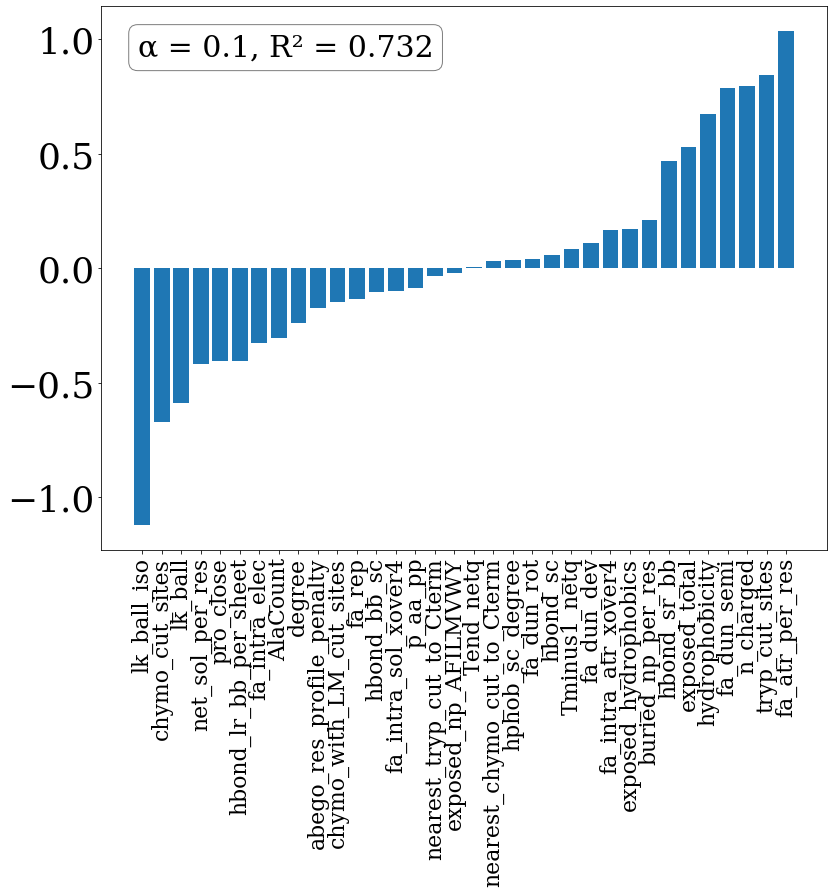

In [68]:
alpha_values = [.1]
lasso_models = []
for a in alpha_values:
    
    lasso_1 = Lasso(alpha=a)

    lasso_1.fit(X_train_std,y_train)

    lasso_1.score(X_test_std,y_test)

    lasso_coeffs = list(zip(X_train_std.columns,lasso_1.coef_))
    print(f"alpha= {a}")
    
    
    
    zipped_results=lasso_coeffs
    model=lasso_1
    cutoff=0
    coeff_dict = {}
    for pair in zipped_results:
        #print(pair)
        if abs(pair[1]) > cutoff:
            coeff_dict[pair[0]] = pair[1]

    coeff_dict

    sorted_dict_tuple = sorted(coeff_dict.items(), key=operator.itemgetter(1))
    sorted_coeff_dict = dict(sorted_dict_tuple)

    sorted_coeffs = [sorted_coeff_dict[key] for key in sorted_coeff_dict]
    
    
    f, ax = plt.subplots(1,1,figsize=(13,10))
    plt.bar(sorted_coeff_dict.keys(), sorted_coeffs)
    plt.xticks(rotation="90",fontsize="22")
    plt.yticks(fontsize='36')
    
    
    textstr = "α = %s, R² = %0.3f"%(model.alpha,model.score(X_test_std,y_test))
    # these are matplotlib.patch.Patch properties
    props = dict(boxstyle='round', facecolor='white', alpha=0.5)
    plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=30,
        verticalalignment='top',bbox=props)
    
    #plt.savefig(f"./SavedFigures/Lasso_R2_{str(round(model.score(X_test_std,y_test),3))}.png",
     #           dpi=300,bbox_inches='tight')
    plt.show()
    

    print()

In [69]:
pd.DataFrame.from_dict(sorted_coeff_dict,orient="index").to_csv("./data/LassoCoeffs.csv")


alpha= 2


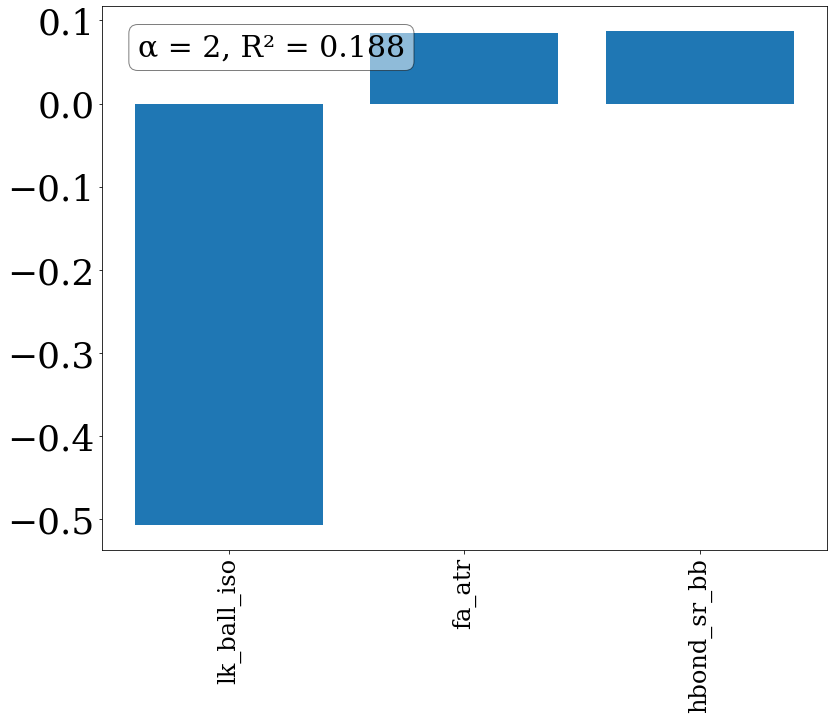

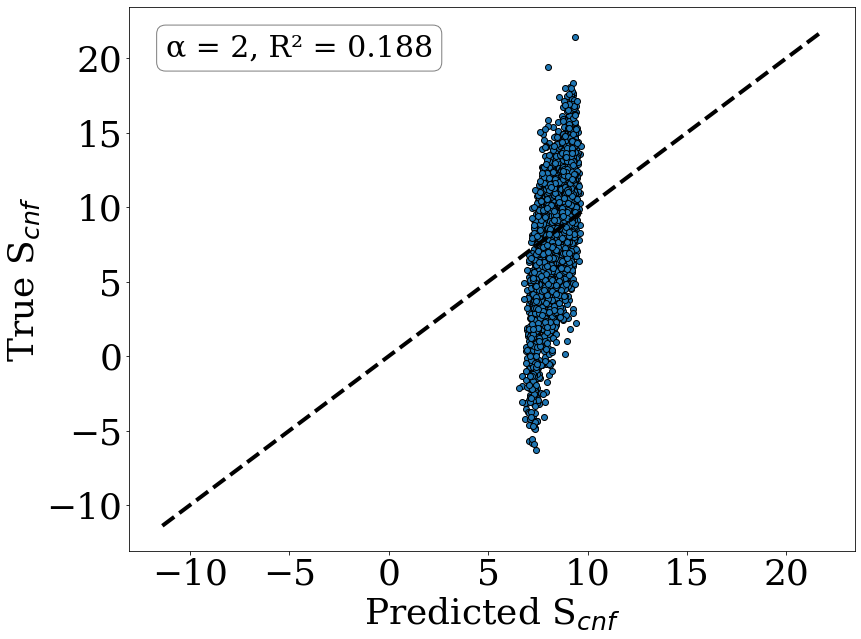


alpha= 1


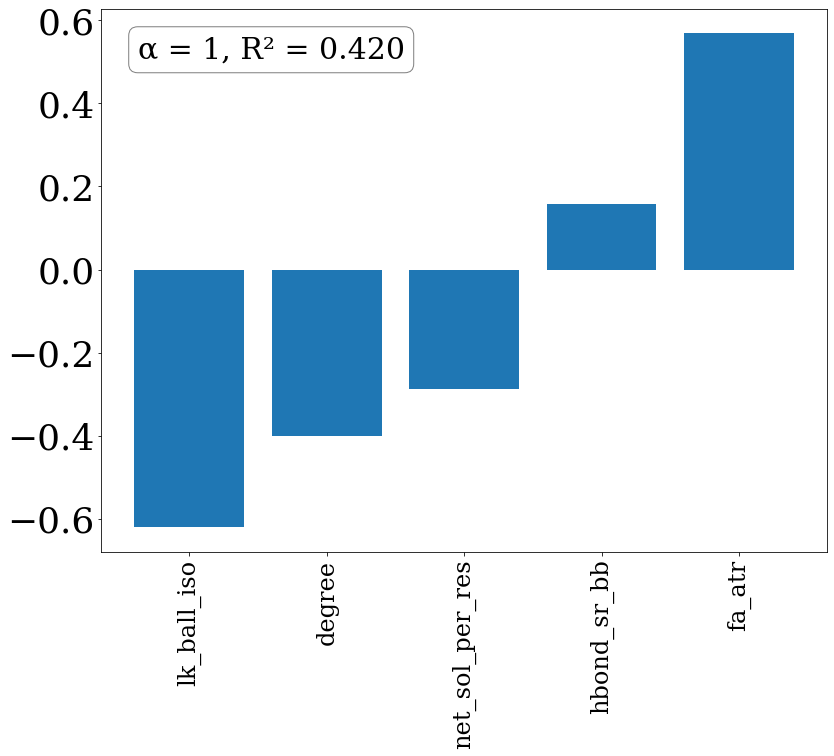

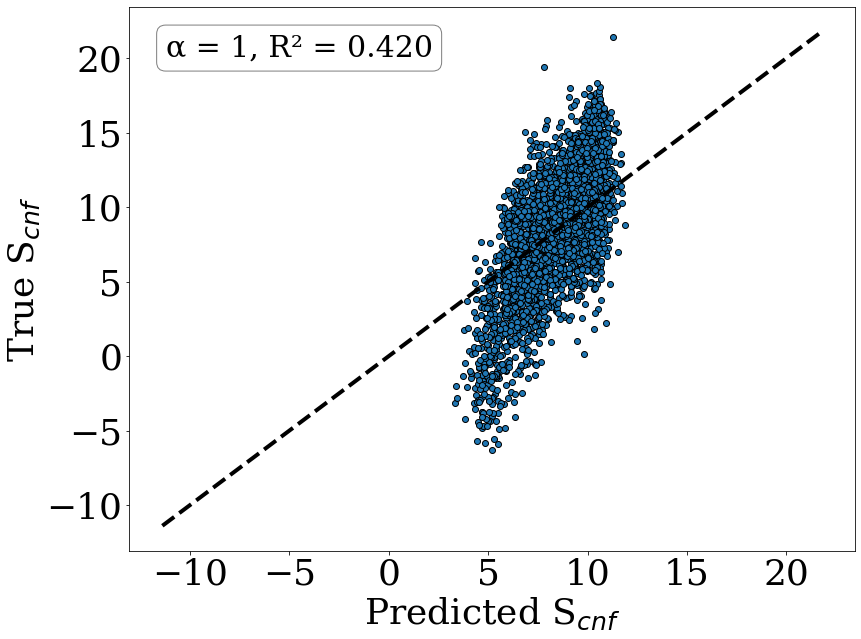


alpha= 0.5


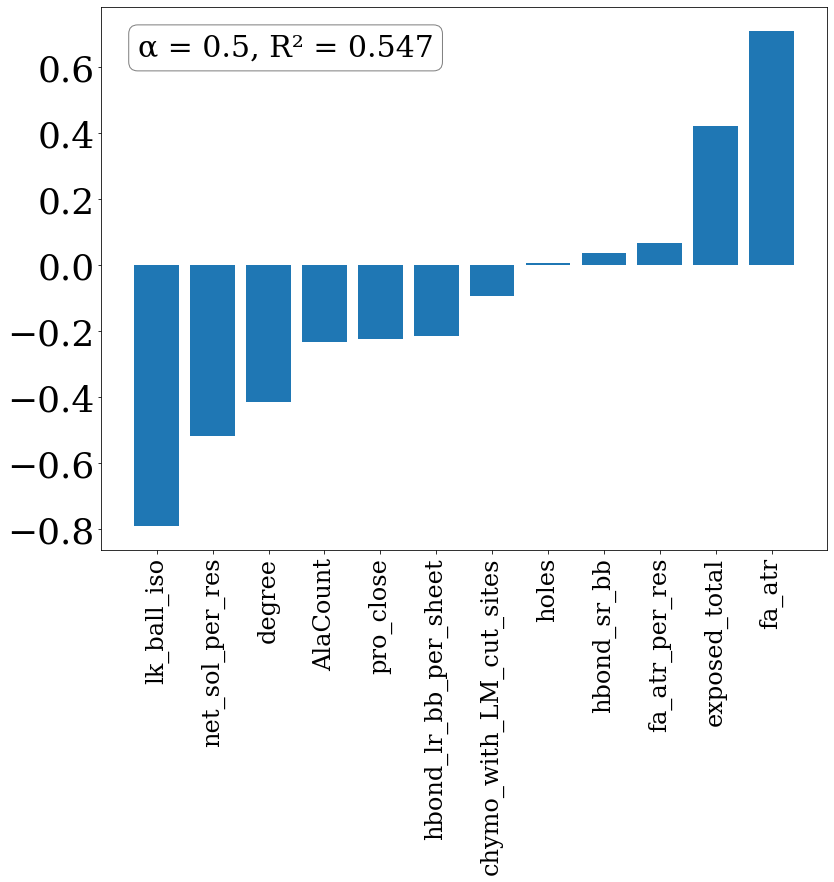

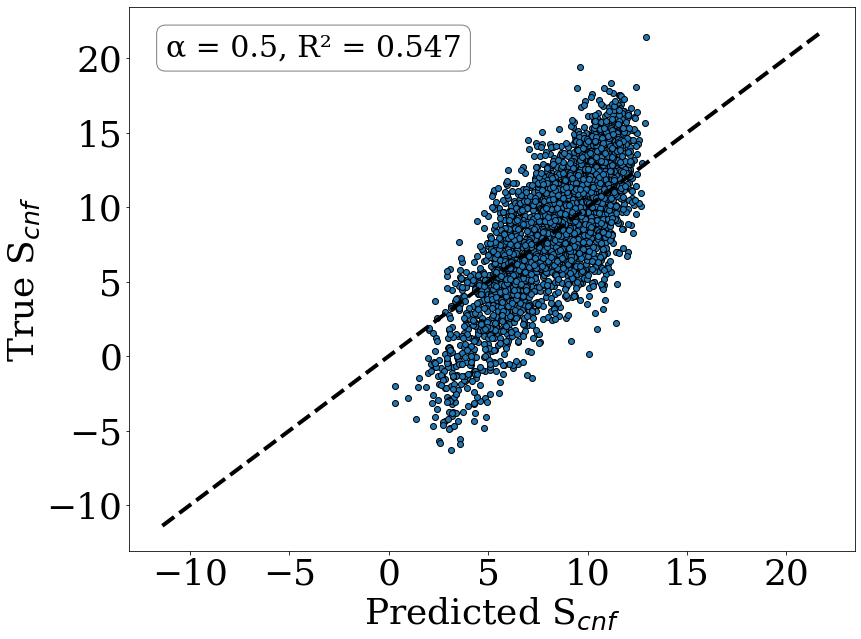


alpha= 0.1


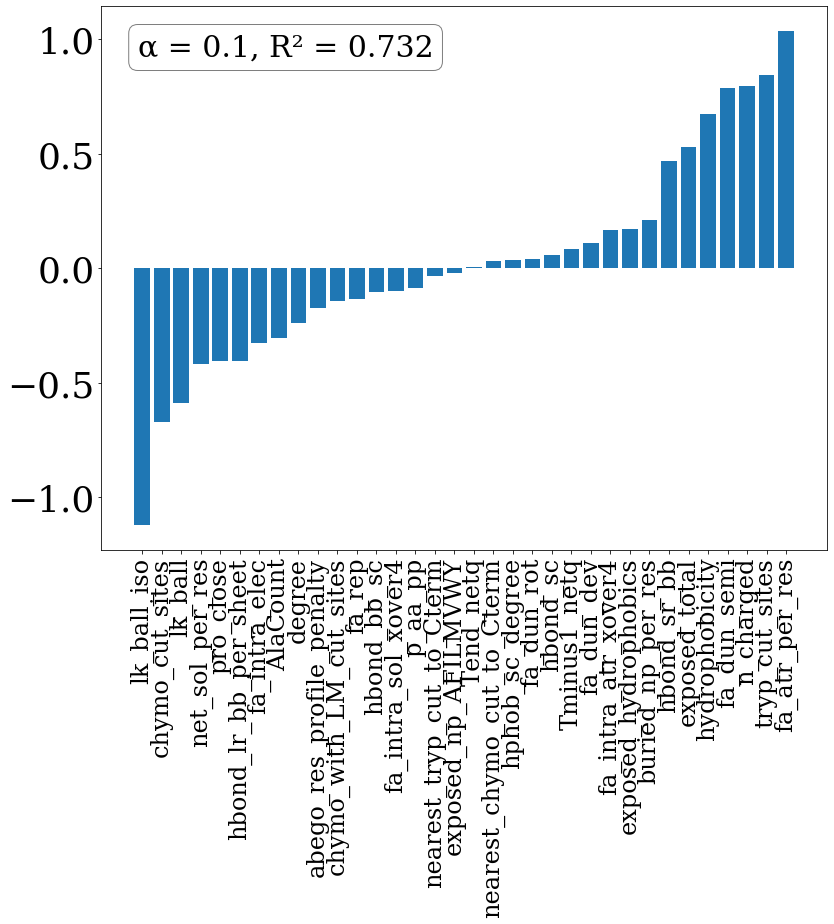

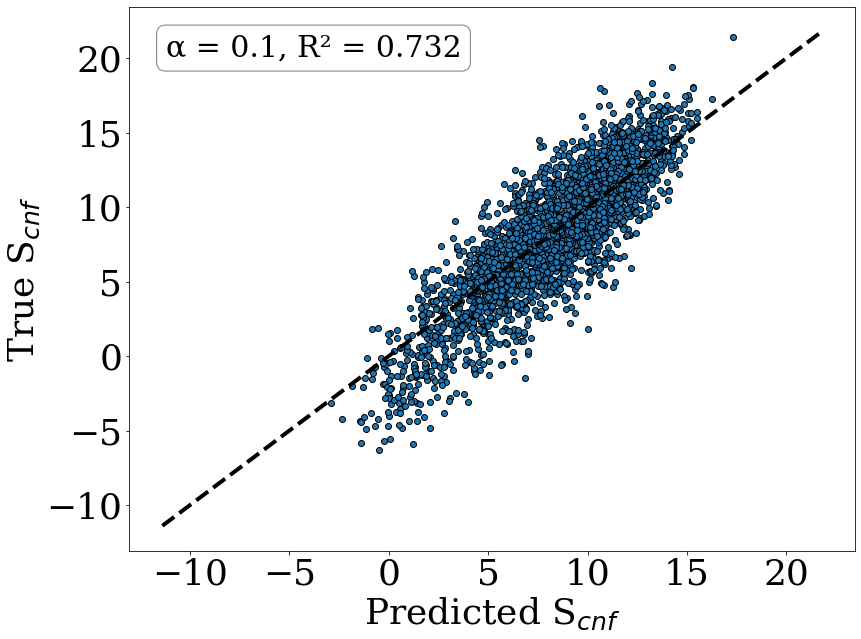

In [70]:
alpha_values = [2,1,.5,.1]
lasso_models = []
for a in alpha_values:
    
    lasso_1 = Lasso(alpha=a)

    lasso_1.fit(X_train_std,y_train)
    
    
    #predict
    y_pred_lnr = lasso_1.predict(X_test_std)

    lasso_1.score(X_test_std,y_test)

    lasso_coeffs = list(zip(X_train_std.columns,lasso_1.coef_))
    print(f"alpha= {a}")
    plot_zipped_results(lasso_coeffs,lasso_1)
    lasso_models.append(lasso_1)
    
    
    fig, ax = plt.subplots(1,1,figsize=(13,10))

    plt.scatter(y_pred_lnr,y_test, edgecolors=(0, 0, 0),label='predicted value')
    plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
    plt.ylabel('True S$_{cnf}$',fontsize="36")
    plt.xticks(fontsize='36')
    plt.yticks(fontsize='36')
    plt.xlabel('Predicted S$_{cnf}$',fontsize="36")
    textstr = "α = %s, R² = %0.3f"%(lasso_1.alpha,lasso_1.score(X_test_std,y_test))
    plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=30,
        verticalalignment='top',bbox=props)
    #plt.legend(fontsize="30")

    #plt.savefig("./SavedFigures/Figure5a",dpi=300,bbox_inches='tight')
    plt.show()
    
    print()

## Permutation Analysis

In [71]:
#eli5.formatters.as_dataframe.explain_weights_df(perm)

In [72]:
# imp_vals, imp_all = feature_importance_permutation(
#     predict_method=model_lnr.predict, 
#     X=X_test_std.values,
#     y=y_test,
#     metric='r2',
#     num_rounds=10)

lasso_model = lasso_models[-1]

imp_vals, imp_all = feature_importance_permutation(
    predict_method=lasso_model.predict, 
    X=X_test_std.values,
    y=y_test,
    metric='r2',
    num_rounds=10)

In [73]:
std = np.std(imp_all, axis=1)

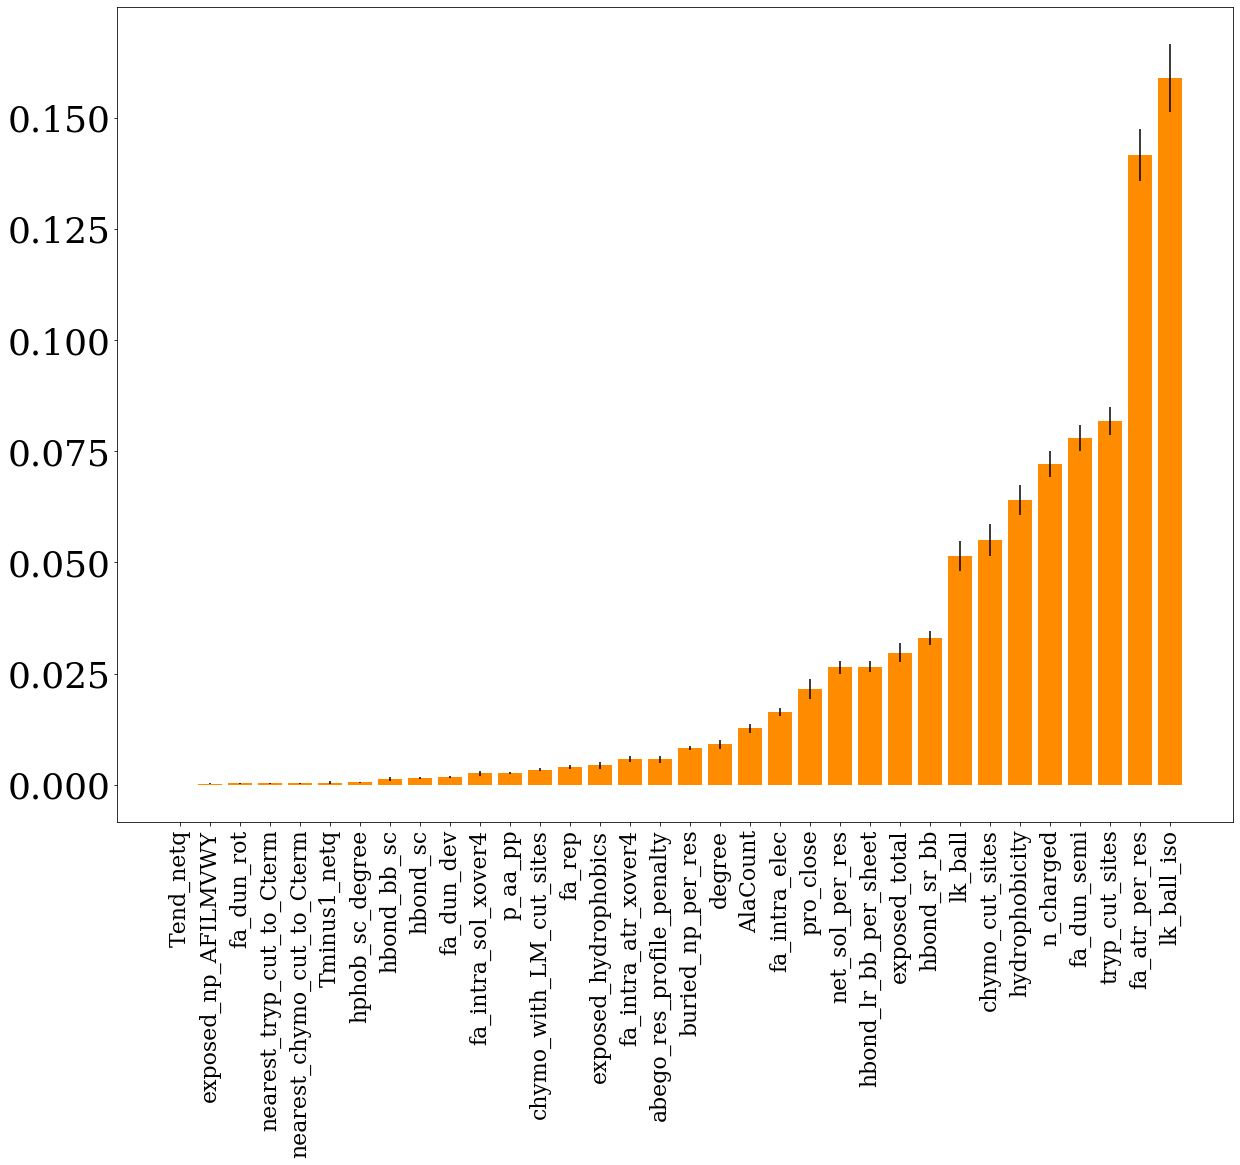

In [74]:
zipped_perm = zip(X_test_std.columns,list(imp_vals),std)
perm_dict = {}
for pair in zipped_perm:
    if abs(pair[1]) > 0:
        perm_dict[pair[0]] = [pair[1],pair[2]]

sorted_dict_tuple = sorted(perm_dict.items(), key=operator.itemgetter(1))
sorted_perm_dict = dict(sorted_dict_tuple)

sorted_coeffs = [sorted_perm_dict[key][0] for key in sorted_perm_dict]
sorted_coeffs_std = [sorted_perm_dict[key][1] for key in sorted_perm_dict]
f, __ = plt.subplots(1,1,figsize=(20,15))
plt.bar(sorted_perm_dict.keys(), sorted_coeffs,yerr=sorted_coeffs_std,color='darkorange')
plt.xticks(rotation="90",fontsize="22")
plt.yticks(fontsize='36')
model_score = round(lasso_model.score(X_test_std,y_test),3)

textstr = "R² = %0.3f"%(model_score)
# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
# plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=30,
#     verticalalignment='top',bbox=props)


#plt.title(f"Permutation Feature Importance Values. R²={model_score}",fontsize=30)
#plt.savefig(f"./SavedFigures/Permutation_R2_{model_score}.png",dpi=300,bbox_inches='tight')
plt.show()

## Manual permutation

In [75]:
original = .8816
new = []
for feature in ros_features:
    new_ros_features = ros_features.copy() #make a copy of rosetta features
    new_ros_features.remove(feature) #drop the feature you are currently iterating on
    
    #set up splits
    X_train = train[new_ros_features]
    y_train = train["S_PC"]

    X_test = test[new_ros_features]
    y_test = test["S_PC"]

    #standardize features
    scaler = StandardScaler()
    scaler.fit(X_train)

    X_train_std = pd.DataFrame(scaler.transform(X_train),columns=X_train.columns)
    X_test_std = pd.DataFrame(scaler.transform(X_test),columns=X_test.columns)

    #merged X and y data
    X = pd.concat([X_train_std,X_test_std])
    y = pd.concat([y_train,y_test])
    
    
    #set up a linear regression trained to predict S_PC
    model_lnr = LinearRegression(normalize=False)

    #fit the data
    model_lnr.fit(X_train_std,y_train)

    #predict
    y_pred_lnr = model_lnr.predict(X_test_std)
    
    
    r2_val = r2_score(y_test.values,y_pred_lnr)

    #get results
#     print("Dropped: ",feature)
#     print("R2 Score: ",r2_val)
#     print()
    
    new.append(r2_val)

In [76]:
delta = [val - original for val in new]

In [77]:
pd.DataFrame(list(zip(ros_features,new,delta)))

0         1         2
0          AlaCount  0.811219 -0.070381
1           T1_absq  0.811219 -0.070381
2           T1_netq  0.811242 -0.070358
3         Tend_absq  0.811219 -0.070381
4         Tend_netq  0.811097 -0.070503
..              ...       ...       ...
108     total_score  0.811204 -0.070396
109  tryp_cut_sites  0.804303 -0.077297
110   two_core_each  0.811116 -0.070484
111     worst6frags  0.811238 -0.070362
112       worstfrag  0.811225 -0.070375

[113 rows x 3 columns]

So individually permuting the features gives me a different take on importances because these features have high covariances, therefore I need to account for this .

# Frac_AA vs Scnf ?
- compare the R-Squared between amino acid (AA) composition and configurational entropy

In [78]:
all_amino_acids = ["A","R","N","D","C","Q","E","G","H","I","L","K","M",
                      "F","P","S","T","W","Y","V"]


In [79]:
def calc_frac_AA(row,aa):
    """
    input is a dataframe row and an amino acid to count across
    """
    prot = row
    len_prot = len(prot)
    n_aa_prot = sum([1 for i in prot if aa in i])
    try: return n_aa_prot/len_prot # percent of the given AA 
    except: return np.nan
calc_frac_AA(combined_data['sequence'][0],"W")

0.04878048780487805

In [80]:
# generate the general amino acid composition features
df = combined_data.copy()

for i in range(len(all_amino_acids)):
    aa = all_amino_acids[i]
    df["frac_%s"%aa] = df["sequence"].apply(calc_frac_AA,args=(aa,))

In [81]:
def subset_by_ss(row,ss):
    """
    Will return a string that contains only the residues that match a given secondary structure
    """
    dssp = row["dssp"]
    prot = row['sequence']
    new_prot = ""
    for i in range(len(dssp)):
        if dssp[i]==ss: new_prot+=prot[i]
    return new_prot


print(df["sequence"][0])
print(df["dssp"][0])
subset_by_ss(df.iloc[0,:],"E")

QEVNSGTQTYKNASPEEAERIARKAGATTWTEKGNKWEIRI
LEEEELLEEELLLLHHHHHHHHHHHLLLEEEEELLEEEEEL


'EVNSQTYTWTEKKWEIR'

In [82]:
frac_aas = [i for i in df.columns if "frac" in i][3:]
frac_aas

['frac_A',
 'frac_R',
 'frac_N',
 'frac_D',
 'frac_C',
 'frac_Q',
 'frac_E',
 'frac_G',
 'frac_H',
 'frac_I',
 'frac_L',
 'frac_K',
 'frac_M',
 'frac_F',
 'frac_P',
 'frac_S',
 'frac_T',
 'frac_W',
 'frac_Y',
 'frac_V']

In [83]:
# generate the per-secondary structure amino acid composition features
all_secondary_structures = ['H',"L","E"]

for i in range(len(all_amino_acids)):
    aa = all_amino_acids[i]
    for j in range(len(all_secondary_structures)):
        ss = all_secondary_structures[j]
        df["sub_%s_sequence"%(ss)] = df.apply(subset_by_ss,args=(ss,),axis=1)
        
        df["frac_%s_%s"%(aa,ss)] = df['sub_%s_sequence'%ss].apply(calc_frac_AA,args=(aa,))
        
    

In [84]:
frac_aas_ss = [frac+"_%s"%ss for frac in frac_aas for ss in all_secondary_structures]
frac_aas_ss

['frac_A_H',
 'frac_A_L',
 'frac_A_E',
 'frac_R_H',
 'frac_R_L',
 'frac_R_E',
 'frac_N_H',
 'frac_N_L',
 'frac_N_E',
 'frac_D_H',
 'frac_D_L',
 'frac_D_E',
 'frac_C_H',
 'frac_C_L',
 'frac_C_E',
 'frac_Q_H',
 'frac_Q_L',
 'frac_Q_E',
 'frac_E_H',
 'frac_E_L',
 'frac_E_E',
 'frac_G_H',
 'frac_G_L',
 'frac_G_E',
 'frac_H_H',
 'frac_H_L',
 'frac_H_E',
 'frac_I_H',
 'frac_I_L',
 'frac_I_E',
 'frac_L_H',
 'frac_L_L',
 'frac_L_E',
 'frac_K_H',
 'frac_K_L',
 'frac_K_E',
 'frac_M_H',
 'frac_M_L',
 'frac_M_E',
 'frac_F_H',
 'frac_F_L',
 'frac_F_E',
 'frac_P_H',
 'frac_P_L',
 'frac_P_E',
 'frac_S_H',
 'frac_S_L',
 'frac_S_E',
 'frac_T_H',
 'frac_T_L',
 'frac_T_E',
 'frac_W_H',
 'frac_W_L',
 'frac_W_E',
 'frac_Y_H',
 'frac_Y_L',
 'frac_Y_E',
 'frac_V_H',
 'frac_V_L',
 'frac_V_E']

## Build model on these features

In [85]:
df = df.fillna(0)

In [86]:
train, test = train_test_split(df[frac_aas+["S_PC"]], test_size=0.2, random_state=5)


#set up splits
X_train = train[frac_aas]
y_train = train["S_PC"]

X_test = test[frac_aas]
y_test = test["S_PC"]

#standardize features
scaler = StandardScaler()
scaler.fit(X_train)

X_train_std = pd.DataFrame(scaler.transform(X_train),columns=X_train.columns)
X_test_std = pd.DataFrame(scaler.transform(X_test),columns=X_test.columns)

#merged X and y data
X = pd.concat([X_train_std,X_test_std])
X = X.reset_index(drop=True)

y = pd.concat([y_train,y_test])
y = y.reset_index(drop=True)



#set up a linear regression trained to predict S_PC
model_lnr = LinearRegression(normalize=False)

#fit the data
model_lnr.fit(X_train_std,y_train)

#predict
y_pred_lnr = model_lnr.predict(X_test_std)

#get results
print("R2 Score: ",r2_score(y_test.values,y_pred_lnr))
range_spc = y_test.max() - y_test.min() #get range of predicted values
print("RMSE/Range: ",np.sqrt(mean_squared_error(y_test.values,y_pred_lnr))/range_spc)
print("MAE/Range: ",mean_absolute_error(y_test.values,y_pred_lnr)/range_spc)

R2 Score:  0.5196203430110479
RMSE/Range:  0.10328851441782344
MAE/Range:  0.0817577752806394


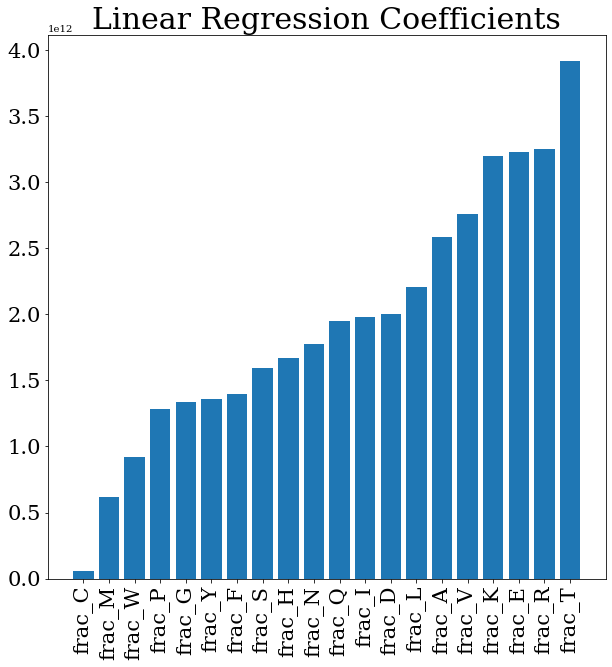

In [87]:
zipped_coeff = zip(frac_aas,list(model_lnr.coef_))
coeff_dict = {}
for pair in zipped_coeff:
    #print(pair)
    if abs(pair[1]):
        coeff_dict[pair[0]] = pair[1]

sorted_dict_tuple = sorted(coeff_dict.items(), key=operator.itemgetter(1))
sorted_coeff_dict = dict(sorted_dict_tuple)

sorted_coeffs = [sorted_coeff_dict[key] for key in sorted_coeff_dict]
f, ax = plt.subplots(figsize=(10,10))
ax.bar(sorted_coeff_dict.keys(), sorted_coeffs)
plt.xticks(rotation="90",fontsize="21")
plt.yticks(fontsize='21')
plt.title("Linear Regression Coefficients",fontsize=30)
plt.show()

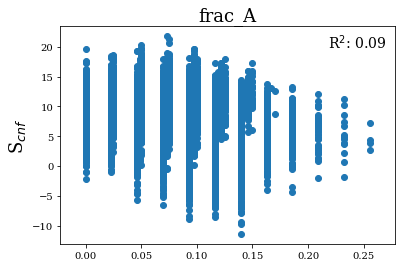

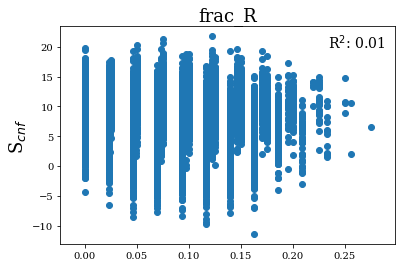

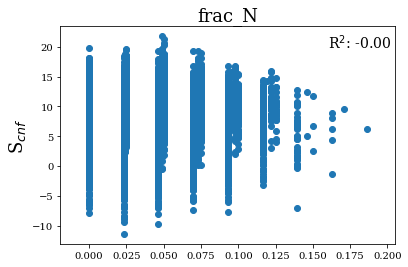

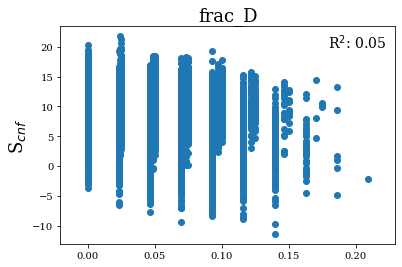

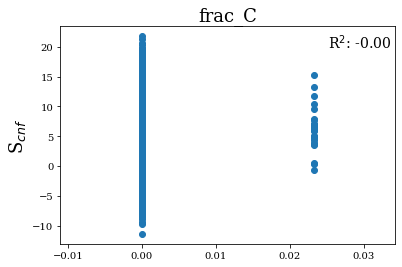

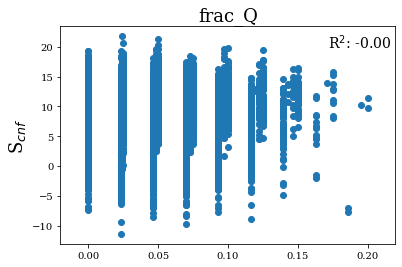

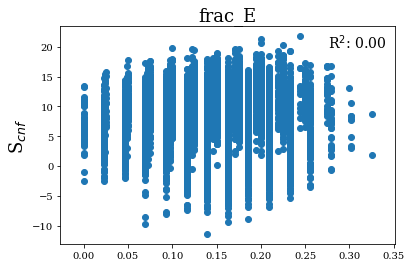

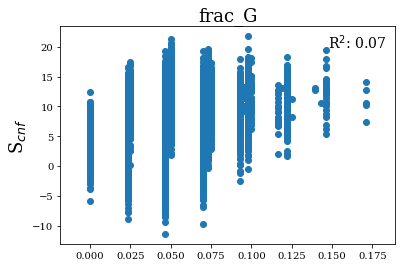

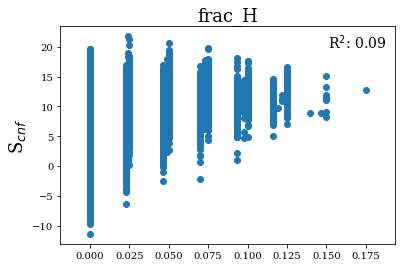

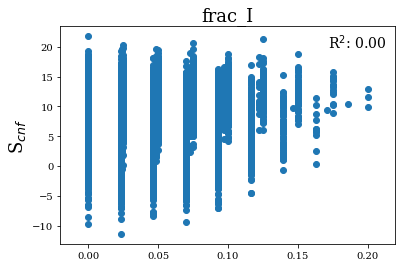

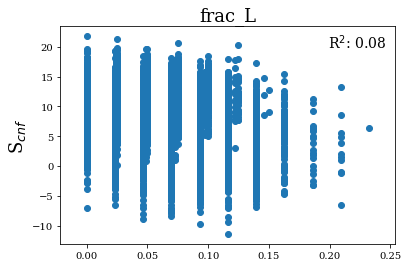

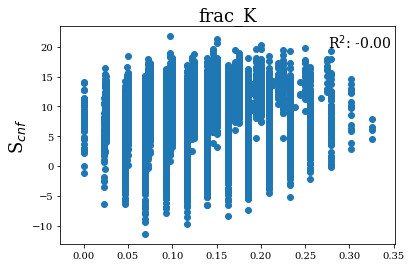

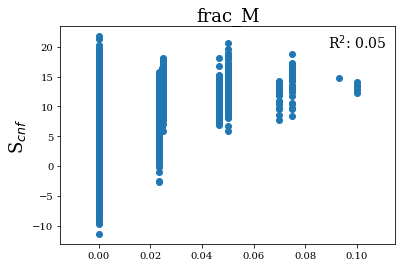

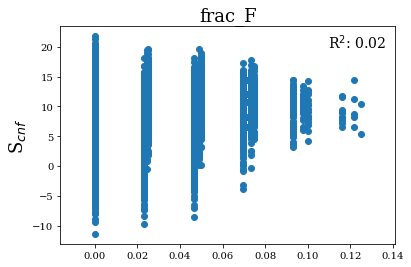

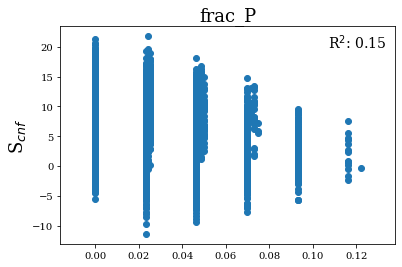

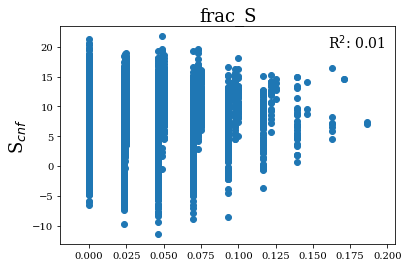

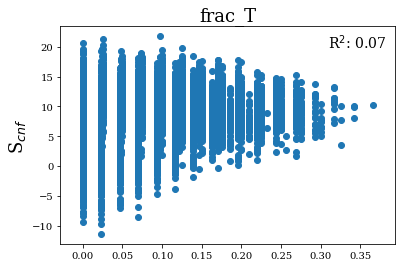

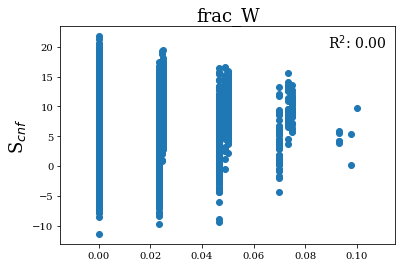

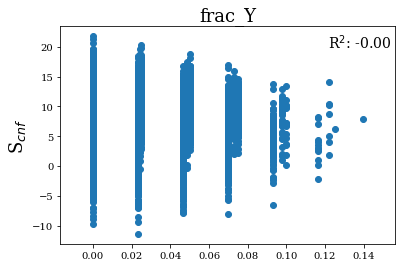

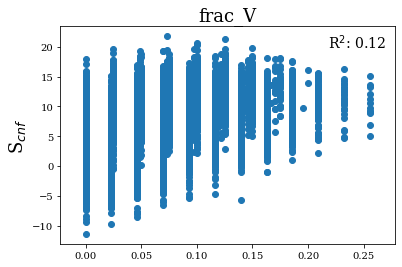

In [88]:
for i in range(len(frac_aas)):
    aa = frac_aas[i]
    plt.figure()
    plt.scatter(df[aa],df["S_PC"])
    plt.title(aa,fontsize='18')
    plt.ylabel("S$_{cnf}$",fontsize='18')
    ax = plt.gca()
    plt.text(.80,.9,s="R$^{2}$: %0.2f"%(train_linear_regression([aa])), transform=ax.transAxes,fontsize='14')
    plt.show()
    
    

## Topology specific breakdown

R2 Score:  0.5859904387285921
RMSE/Range:  0.08403695409637679
MAE/Range:  0.06665006225135317


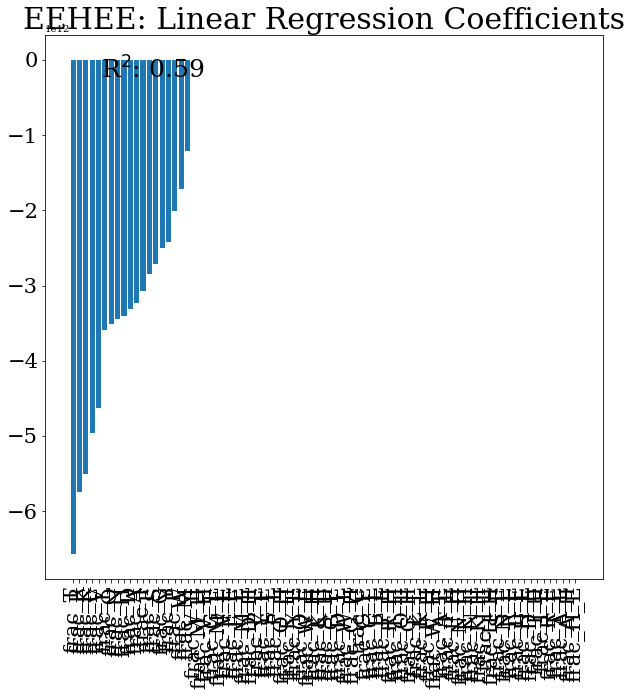

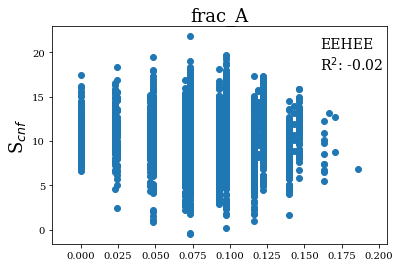

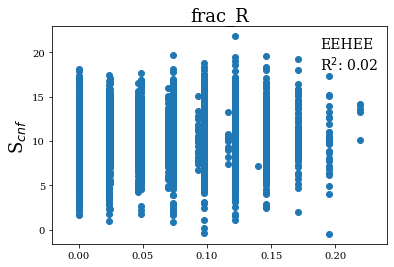

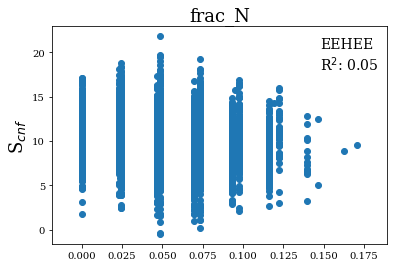

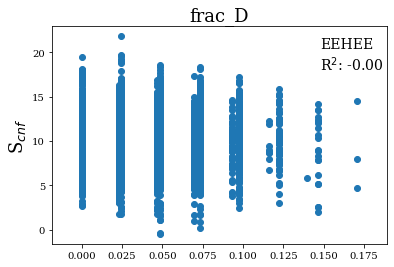

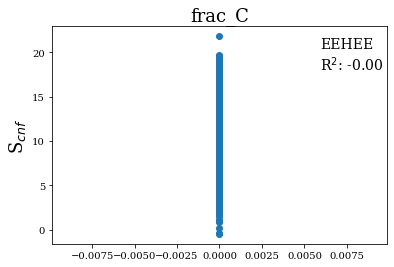

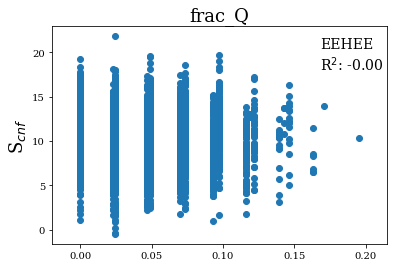

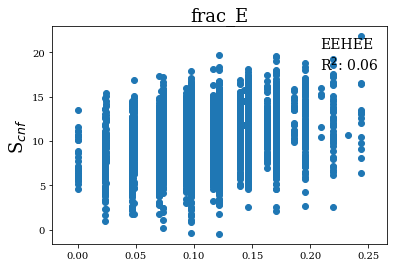

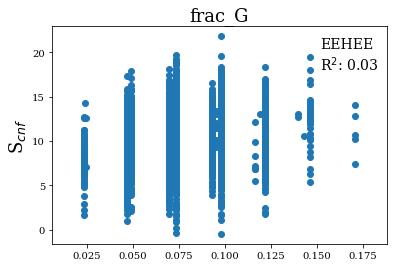

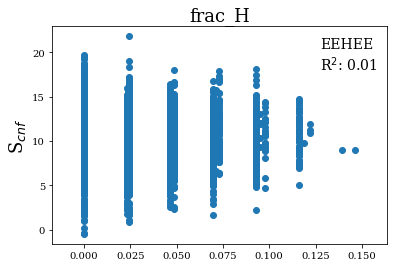

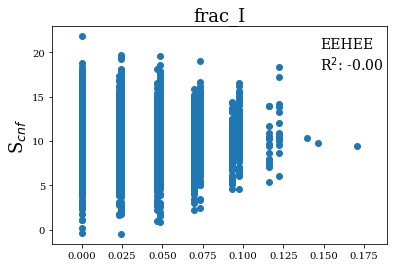

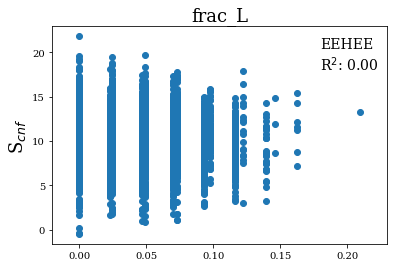

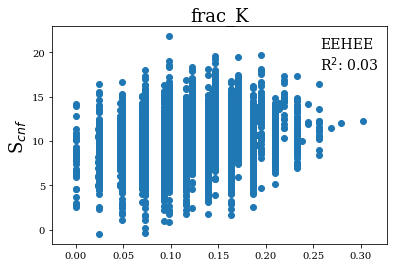

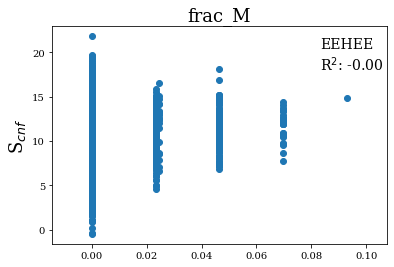

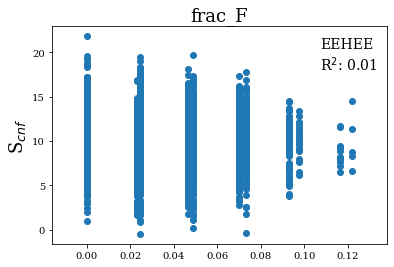

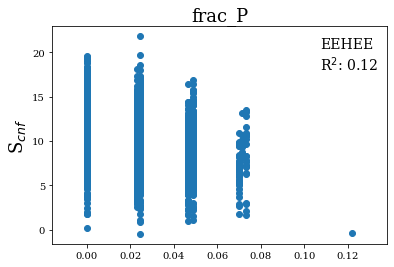

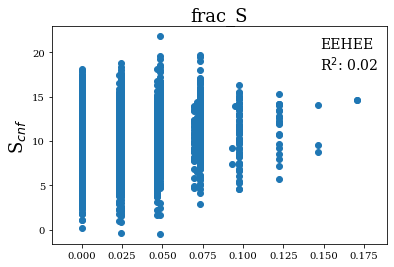

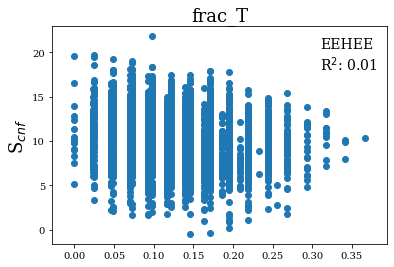

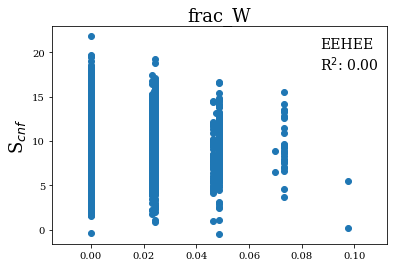

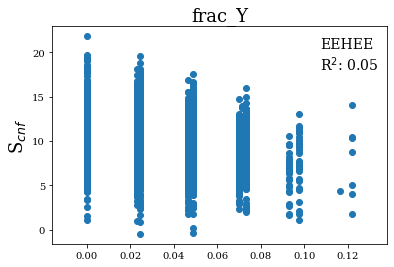

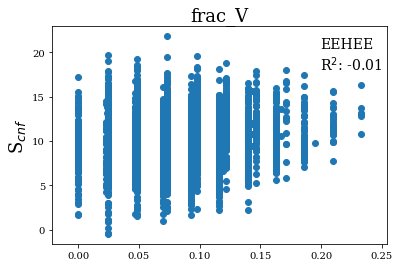

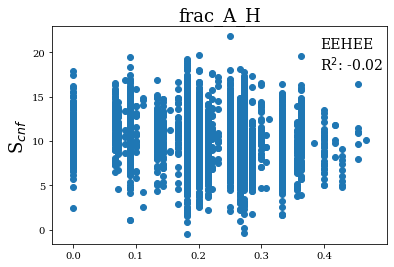

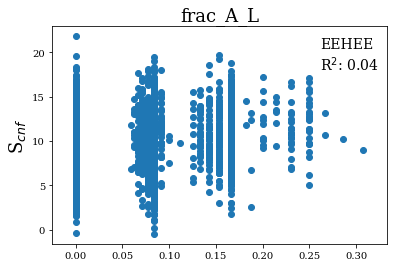

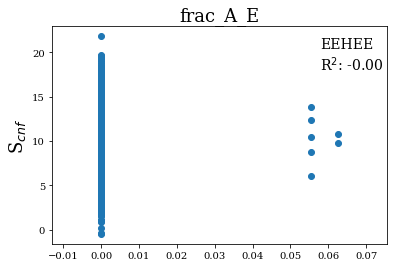

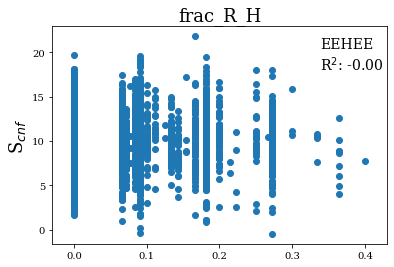

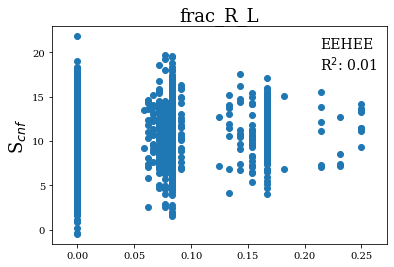

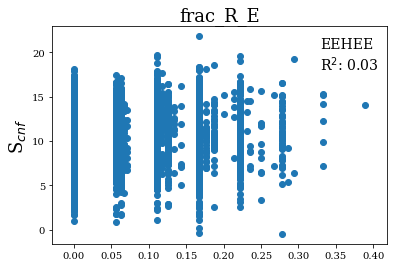

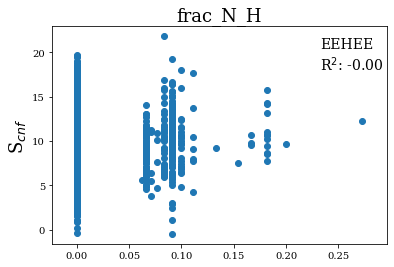

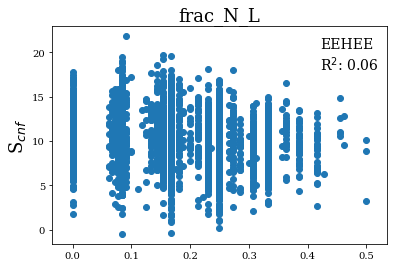

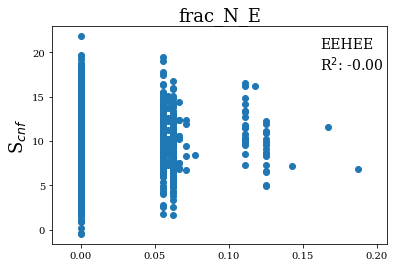

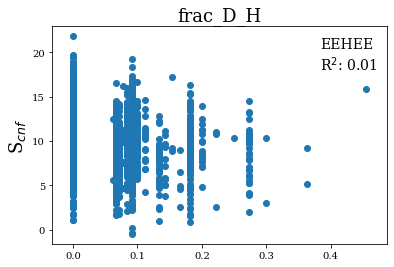

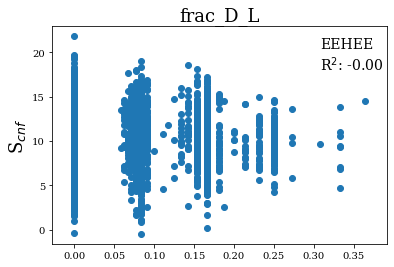

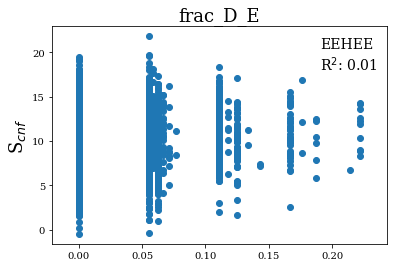

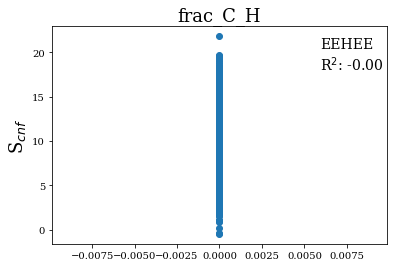

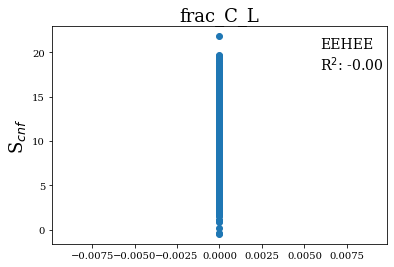

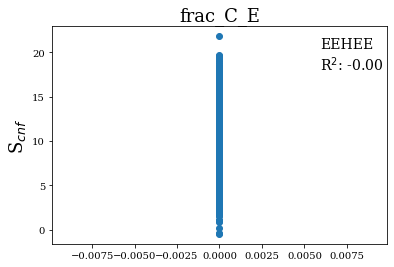

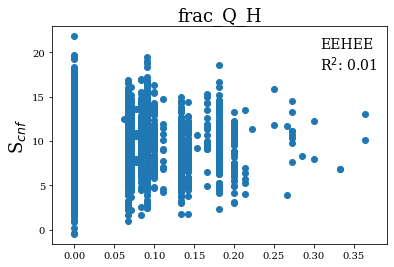

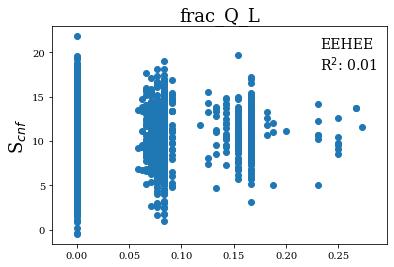

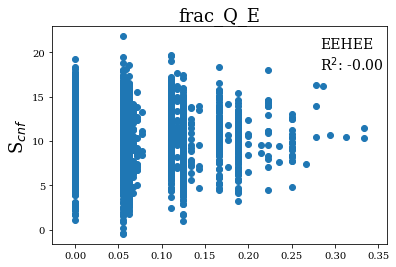

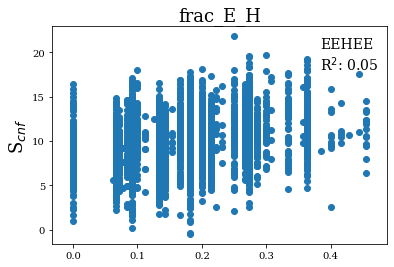

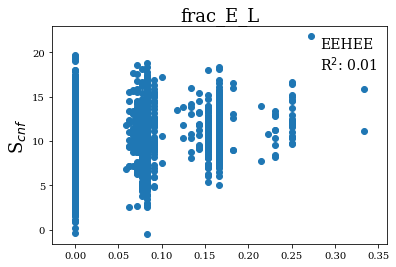

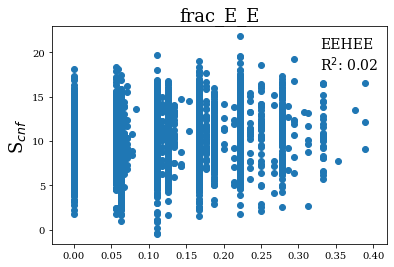

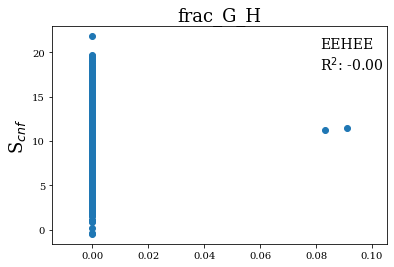

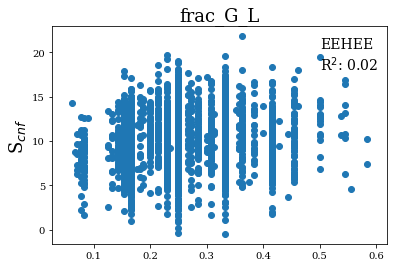

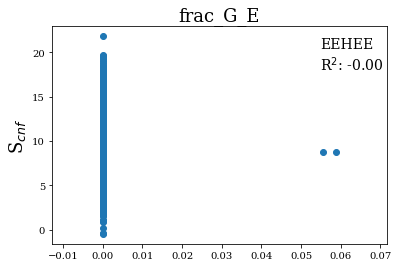

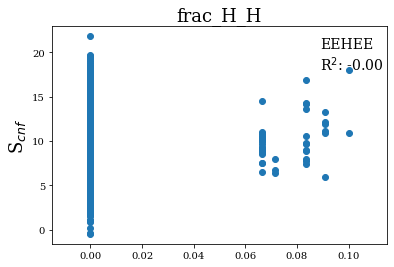

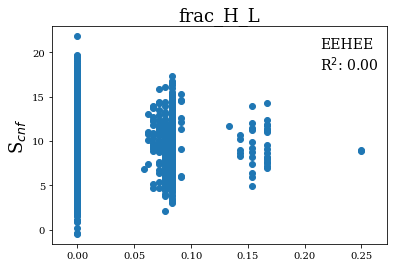

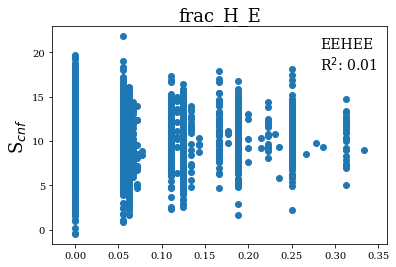

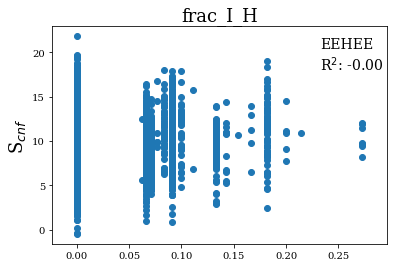

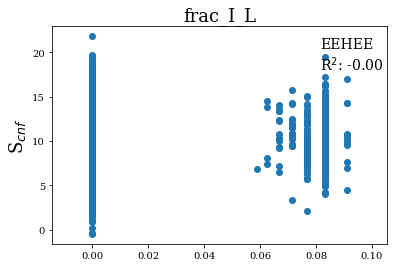

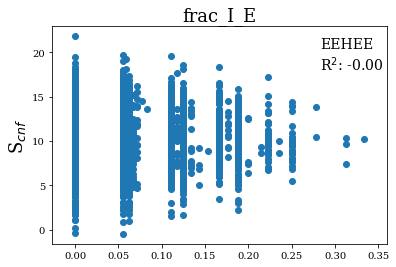

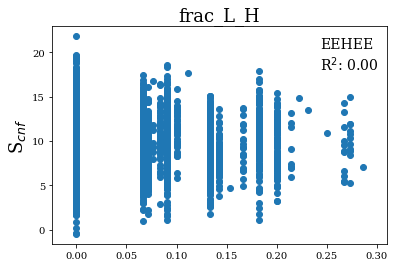

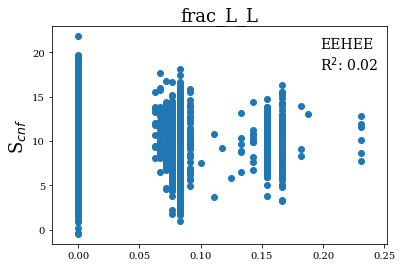

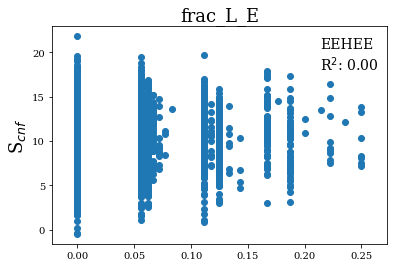

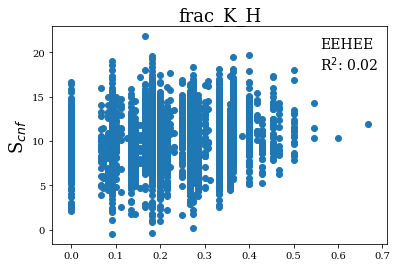

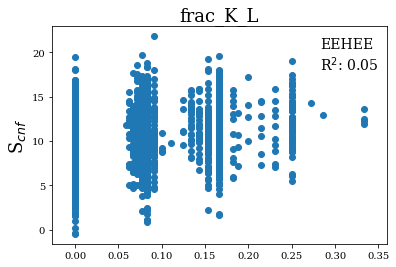

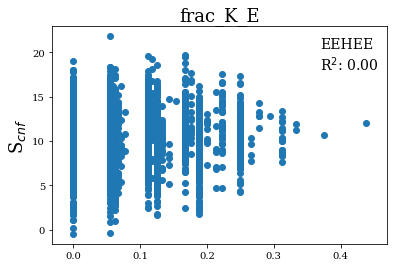

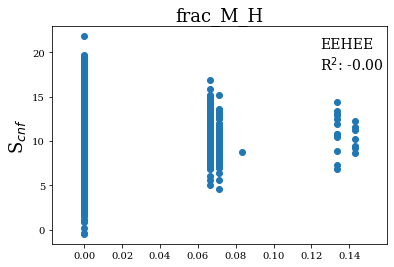

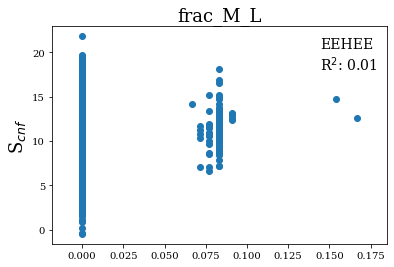

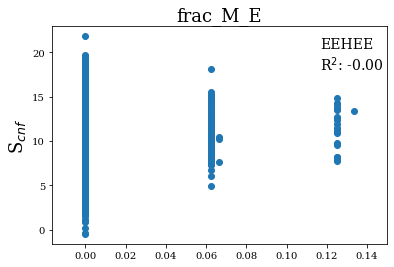

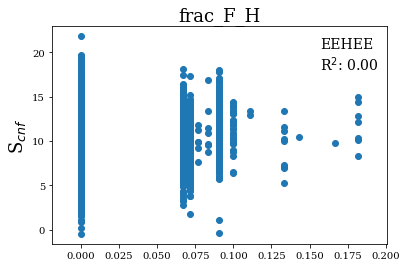

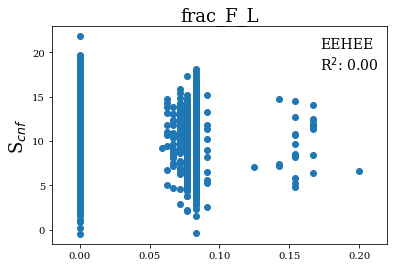

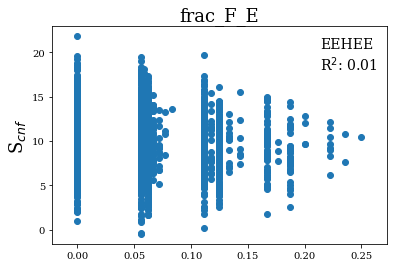

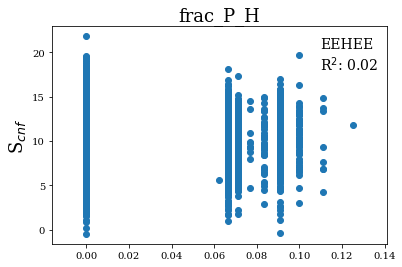

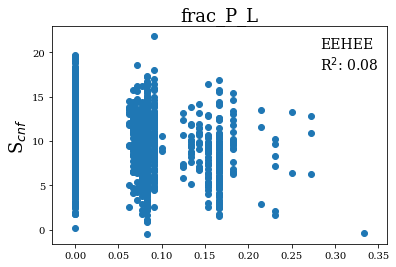

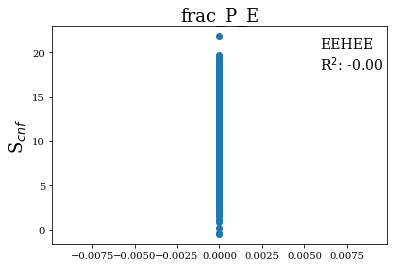

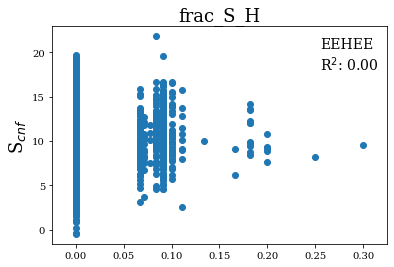

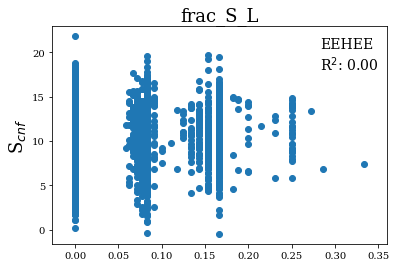

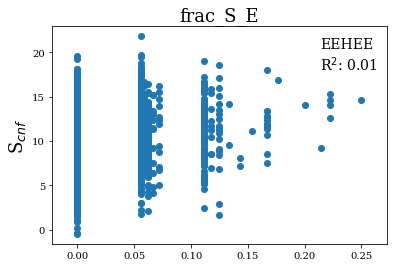

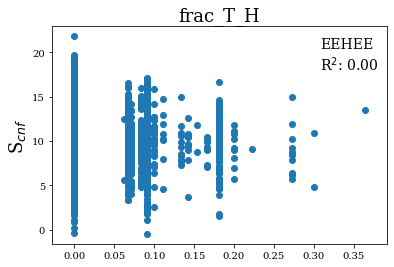

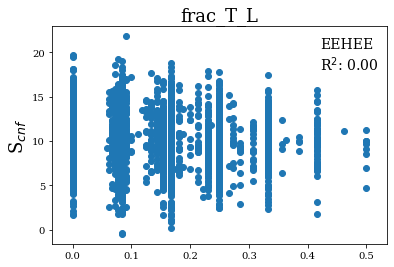

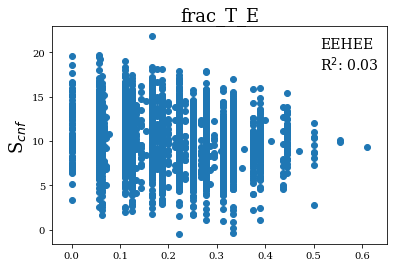

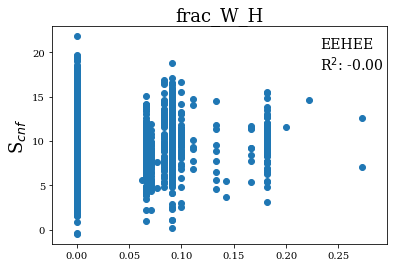

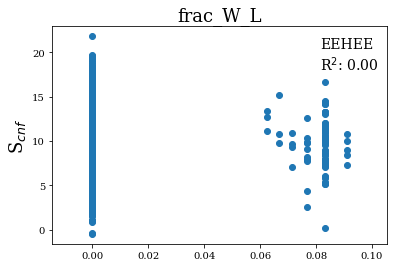

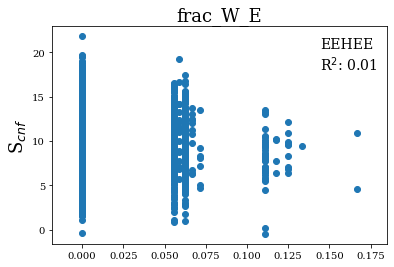

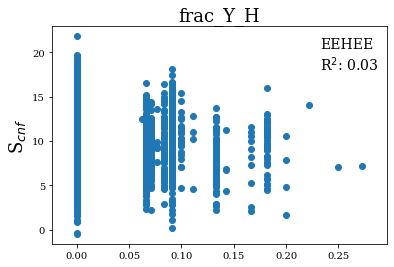

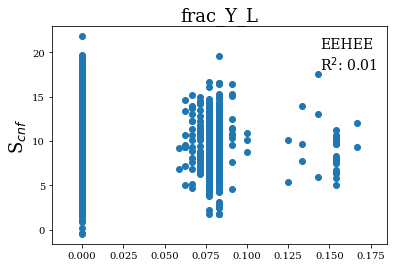

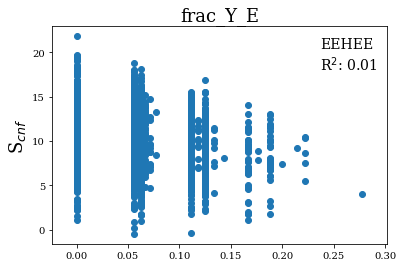

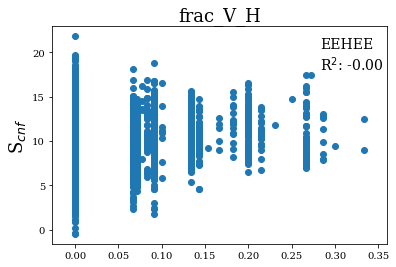

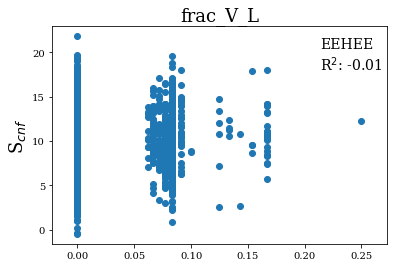

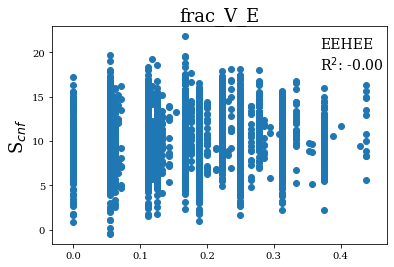

R2 Score:  0.6660855285386225
RMSE/Range:  0.07637475452452737
MAE/Range:  0.06029803875292931


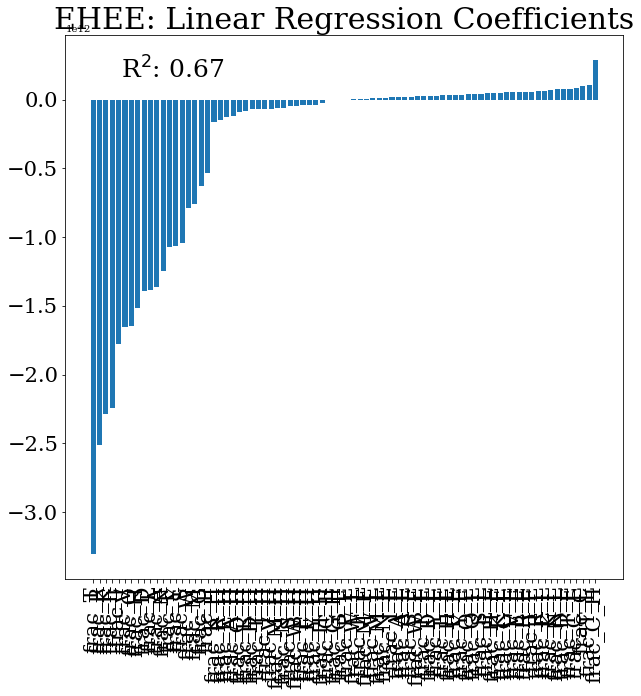

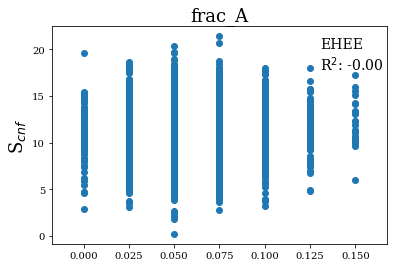

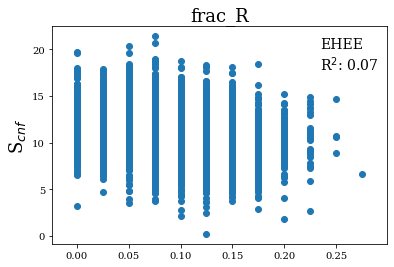

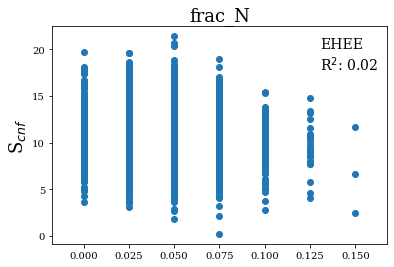

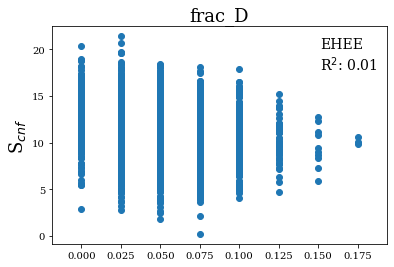

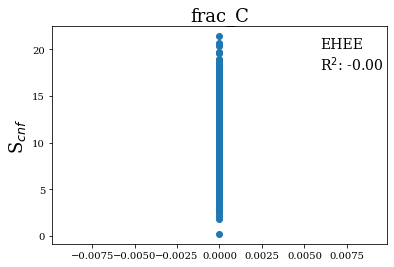

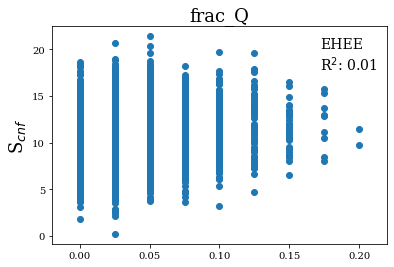

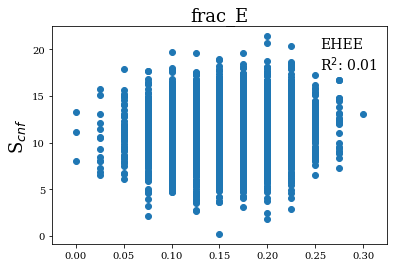

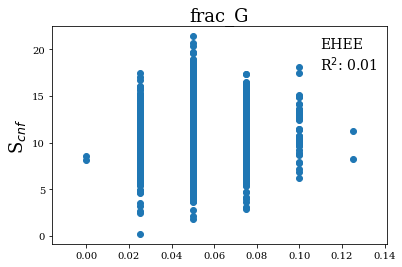

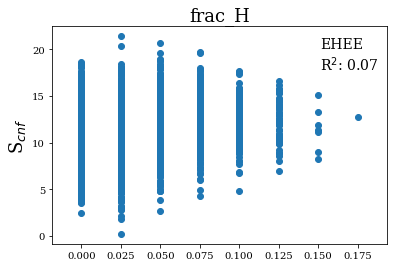

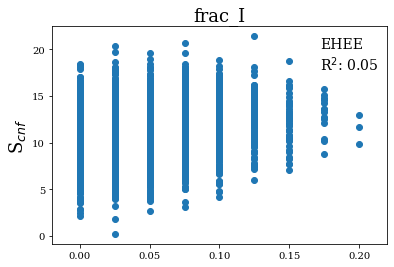

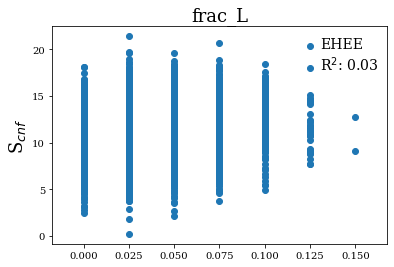

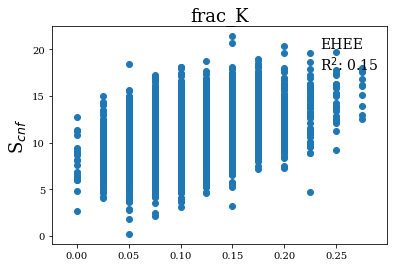

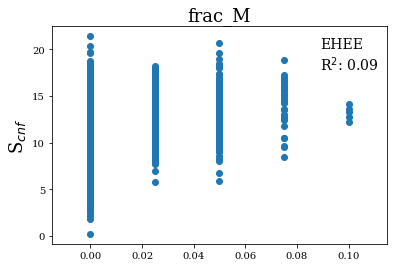

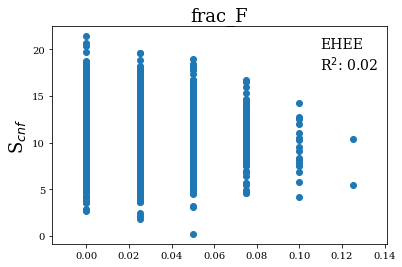

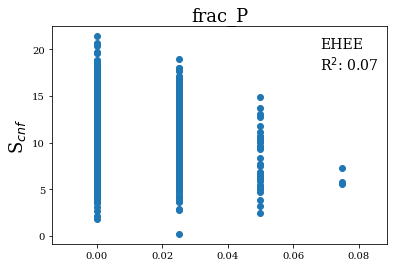

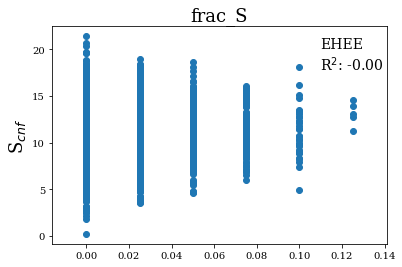

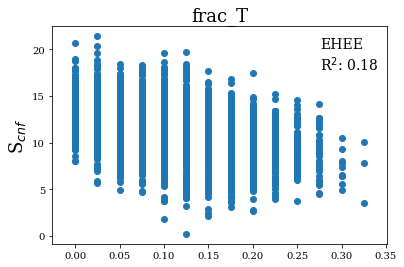

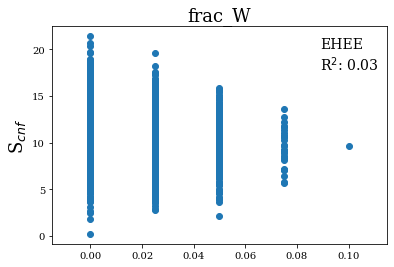

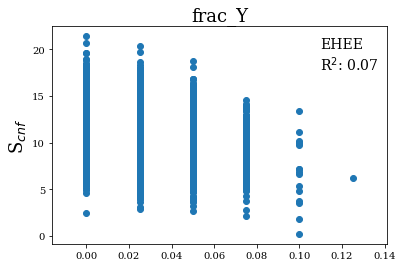

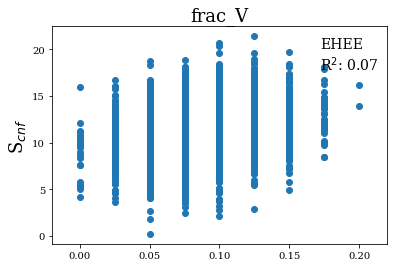

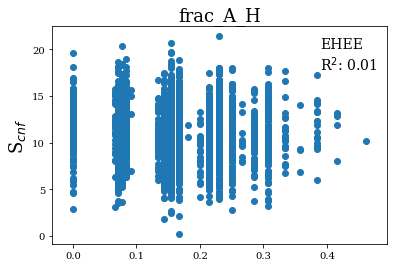

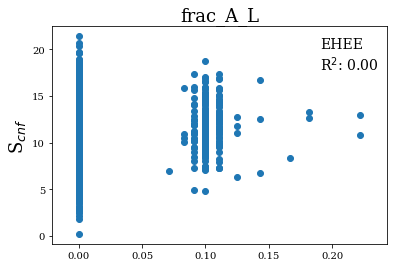

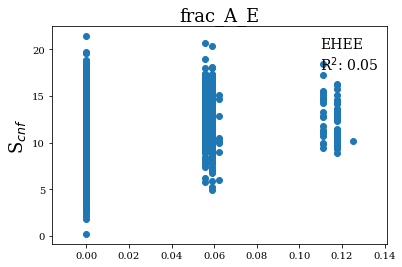

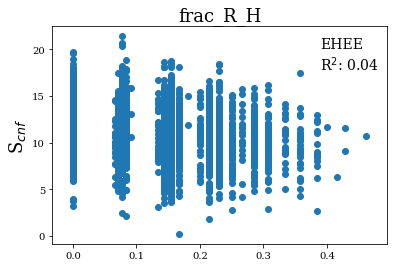

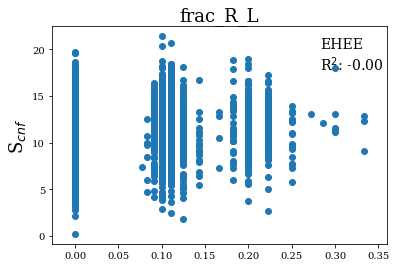

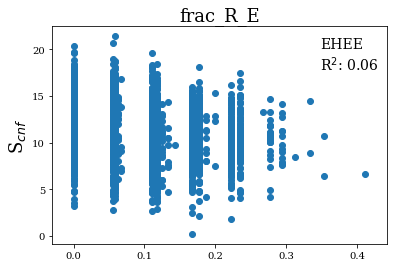

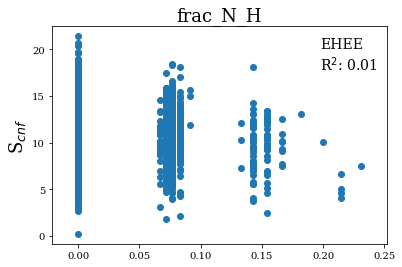

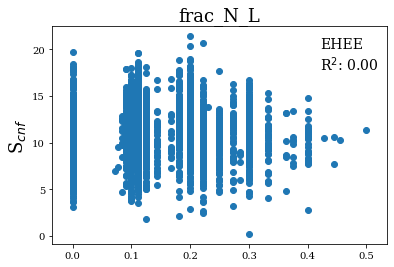

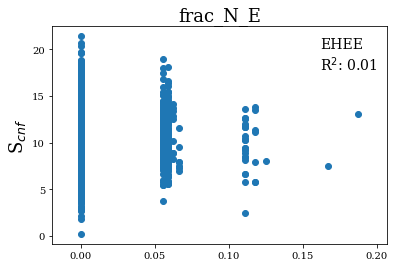

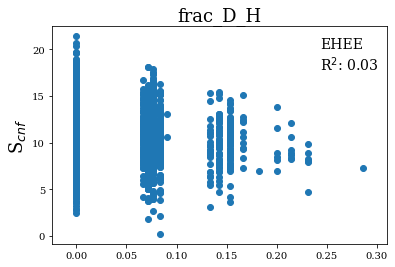

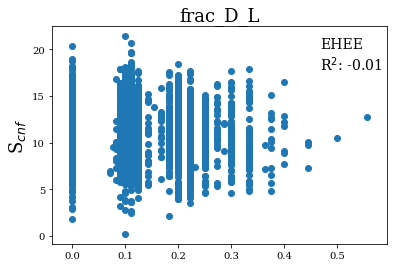

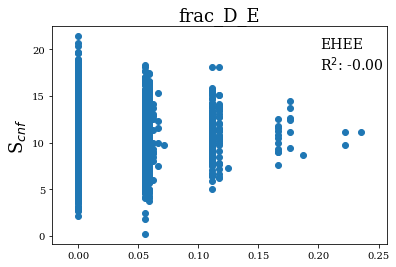

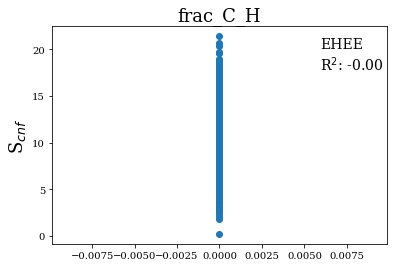

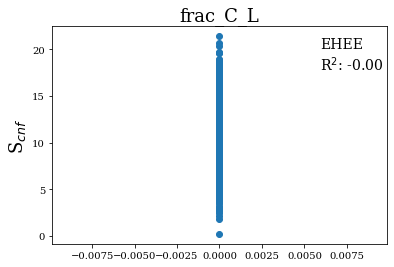

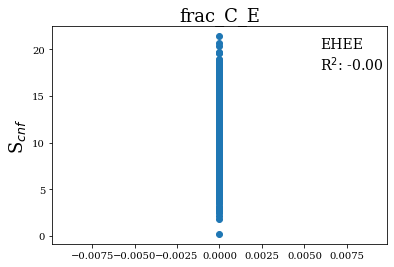

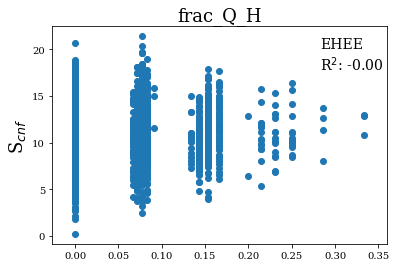

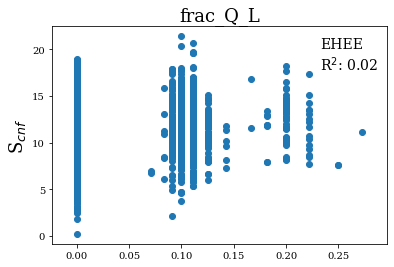

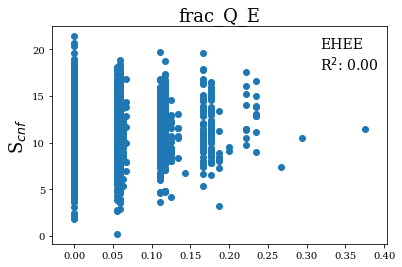

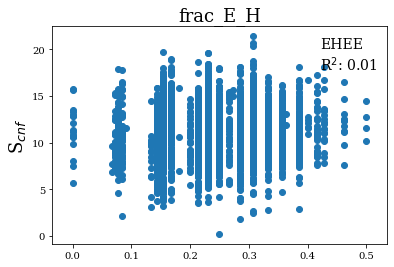

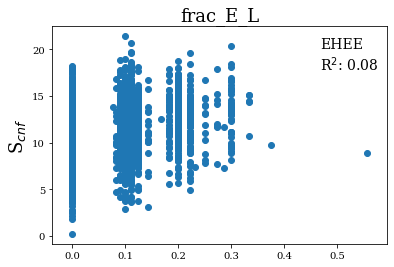

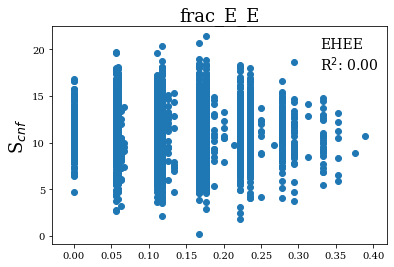

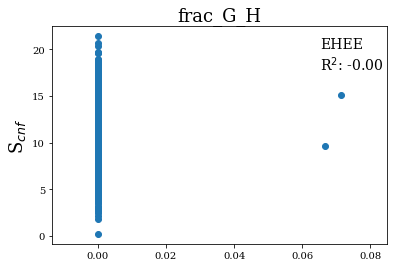

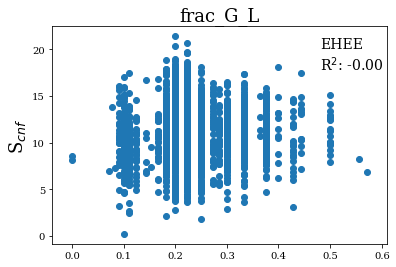

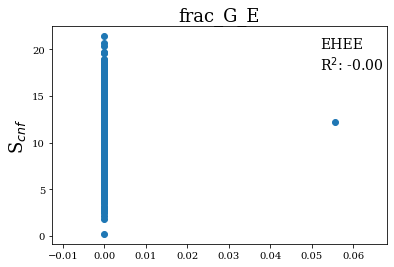

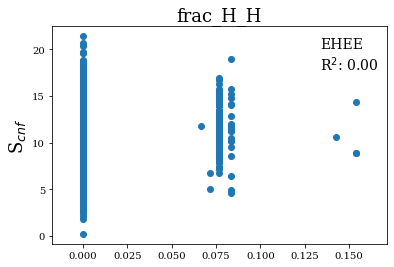

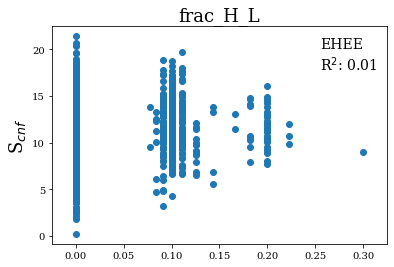

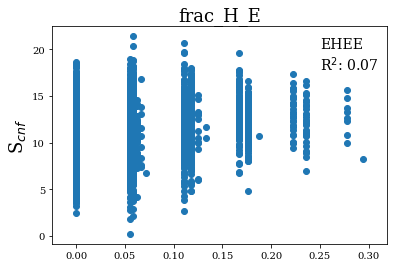

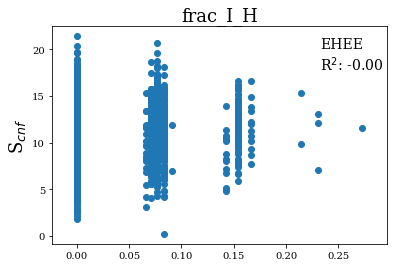

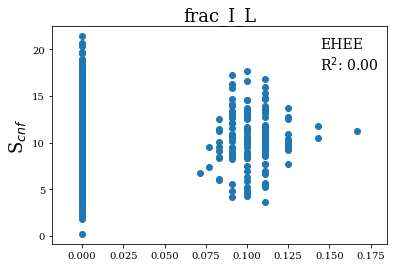

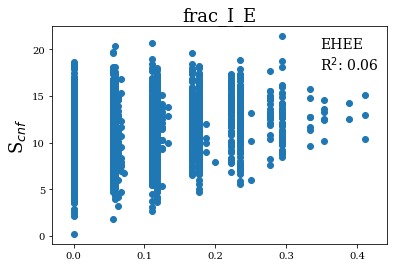

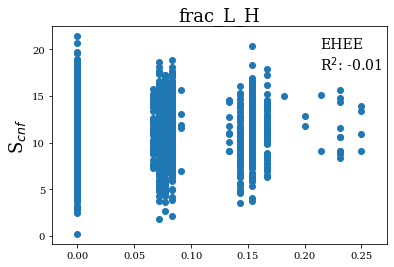

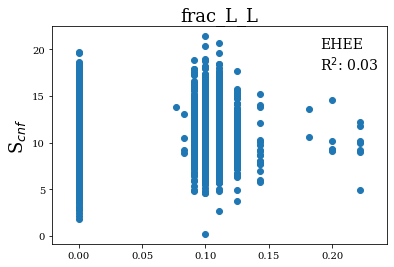

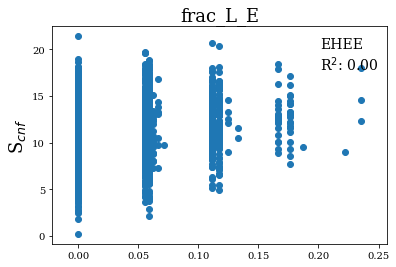

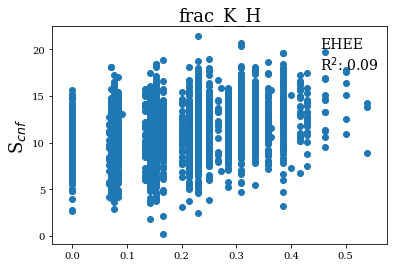

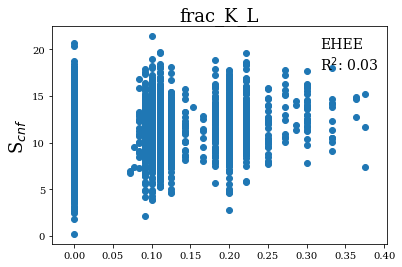

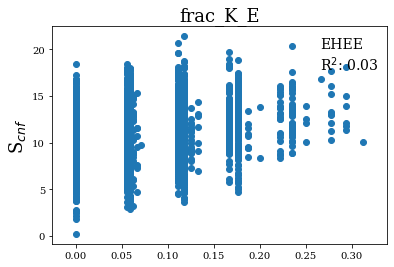

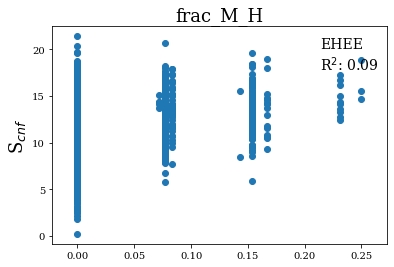

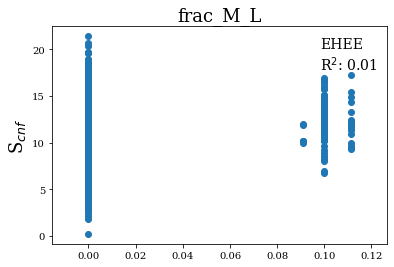

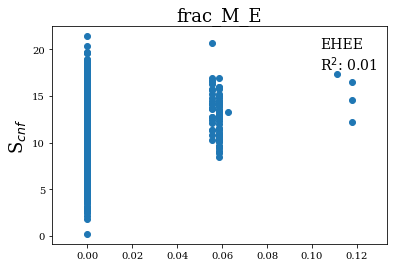

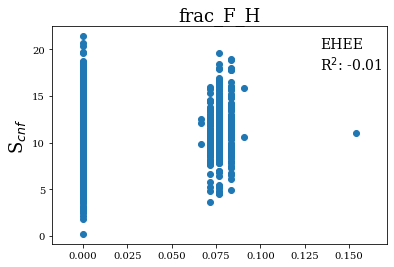

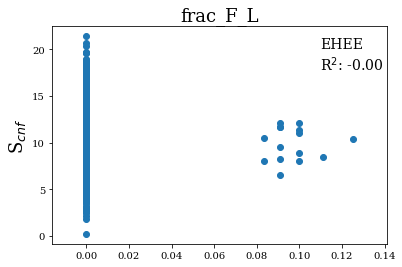

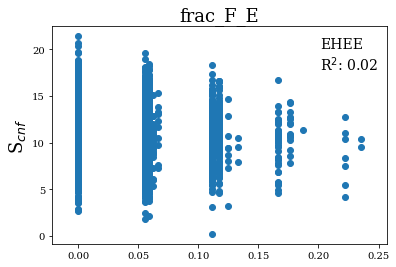

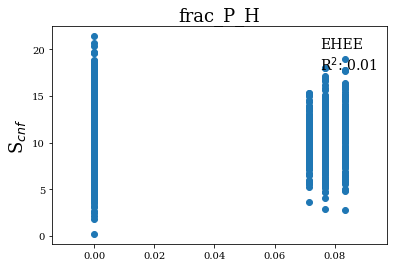

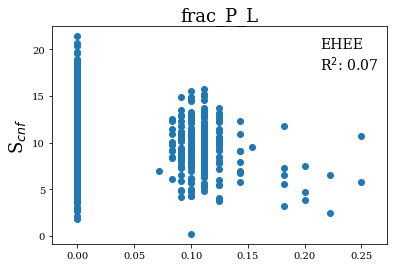

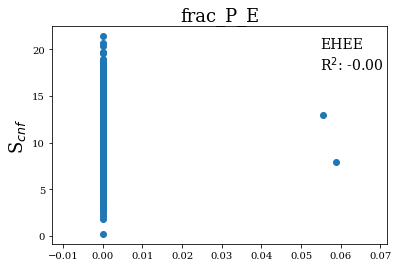

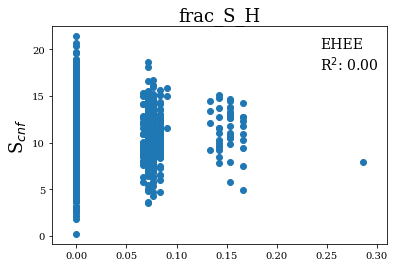

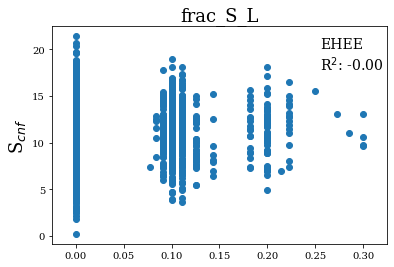

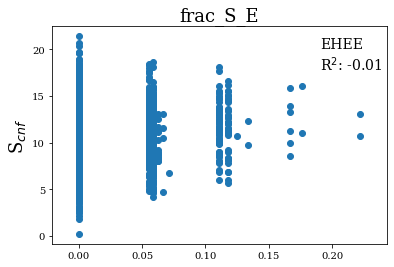

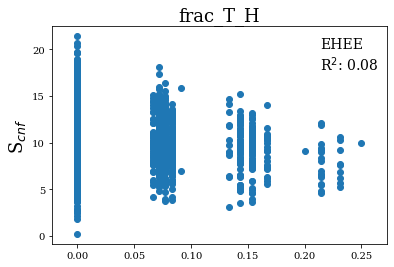

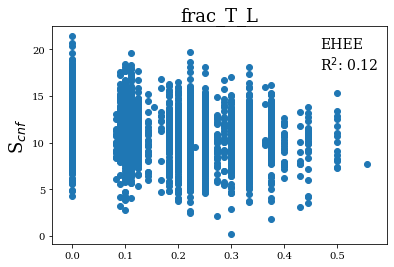

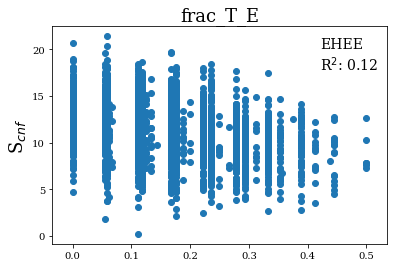

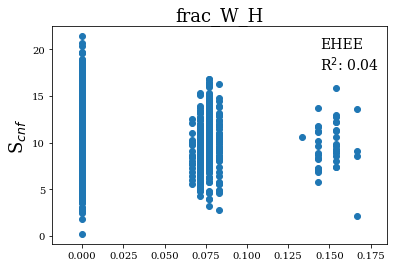

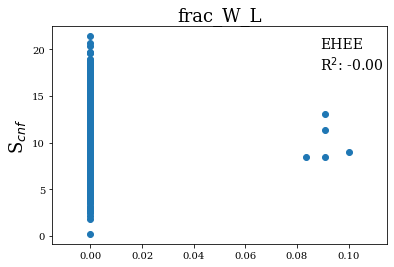

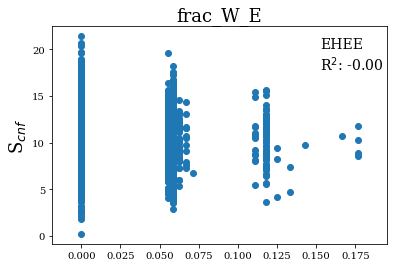

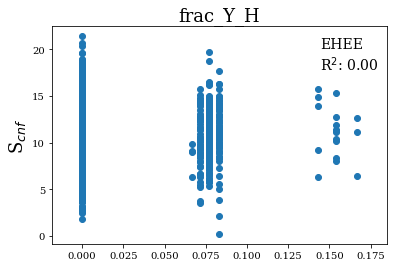

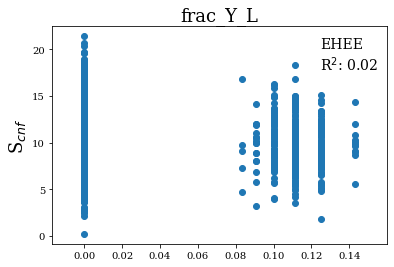

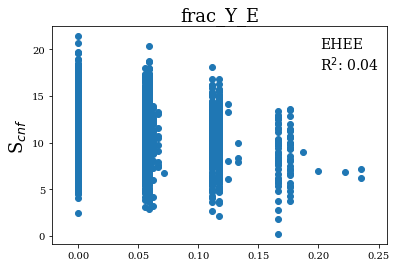

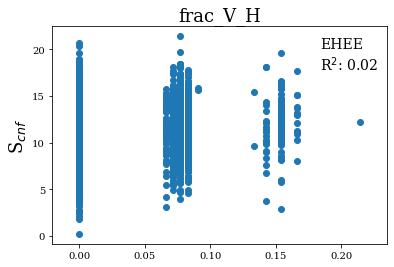

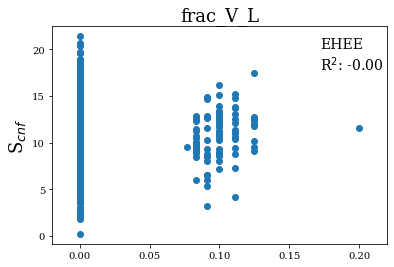

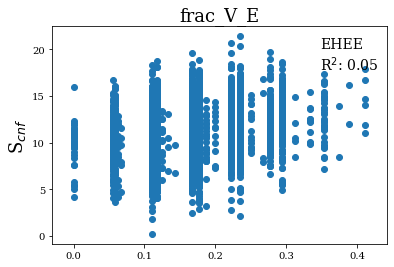

R2 Score:  0.6422740290206627
RMSE/Range:  0.0892173765359374
MAE/Range:  0.07059875314848234


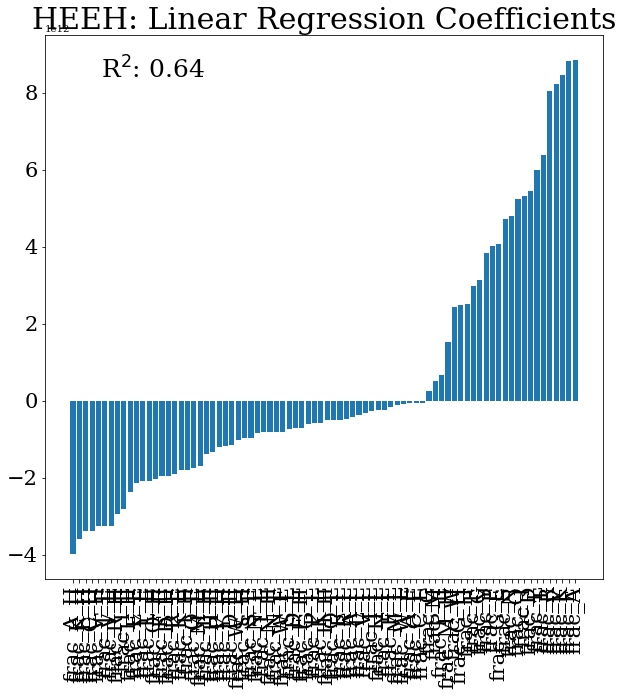

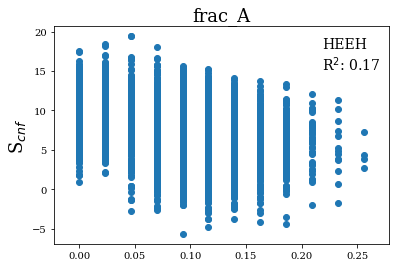

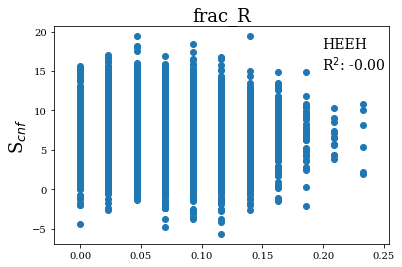

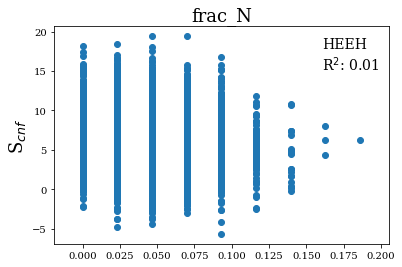

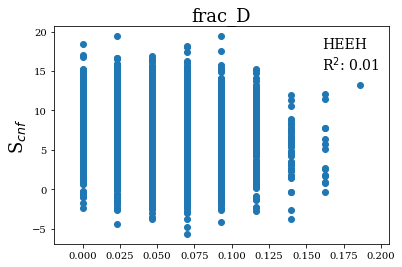

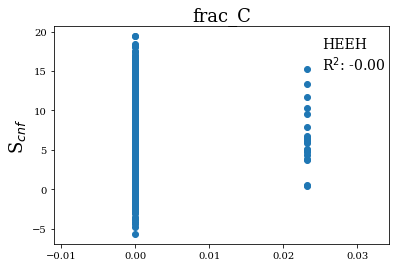

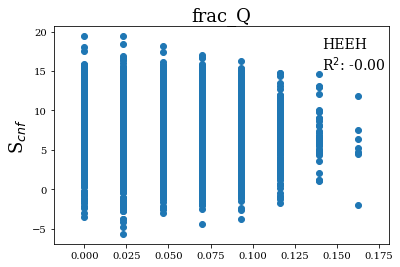

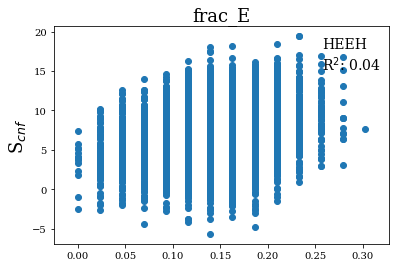

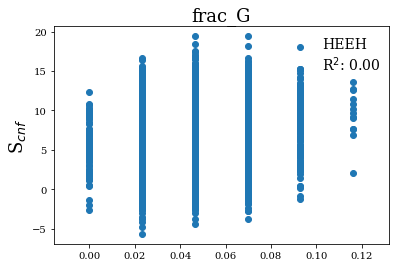

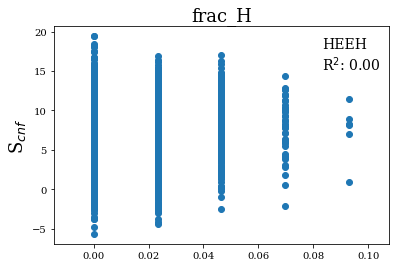

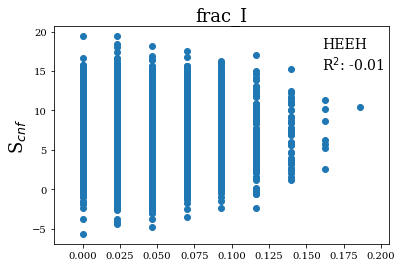

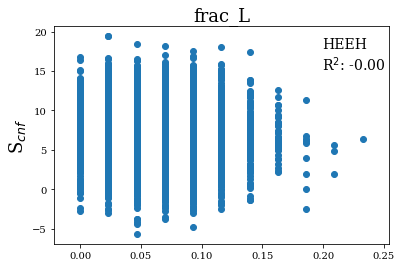

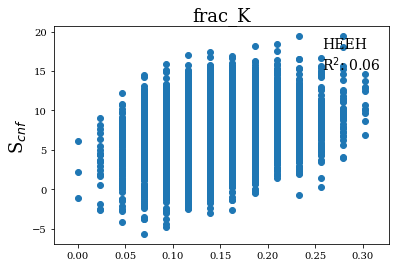

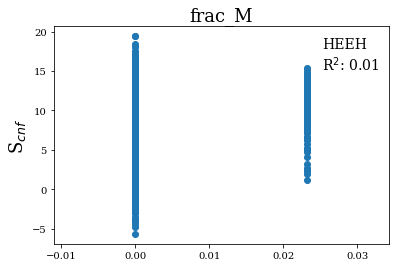

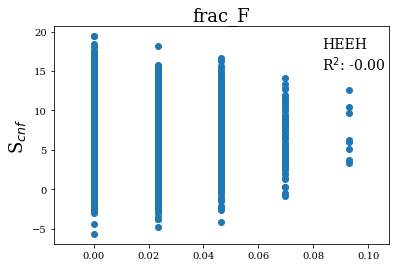

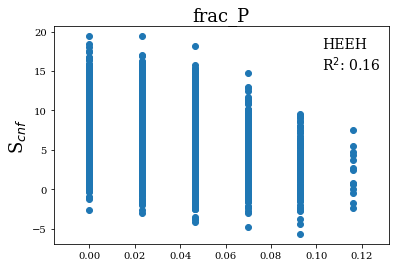

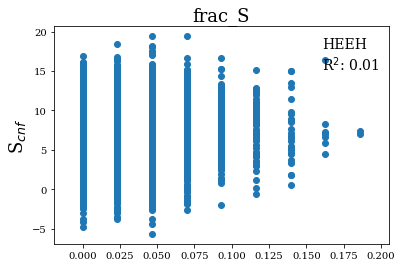

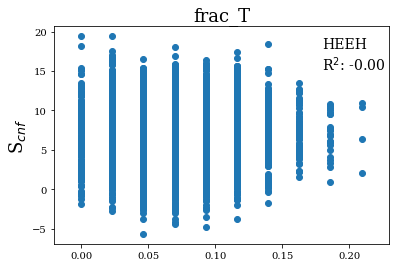

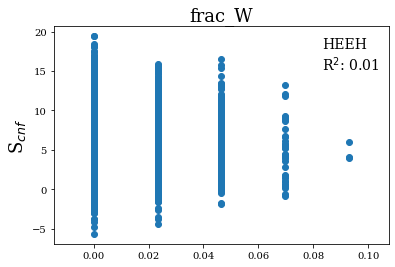

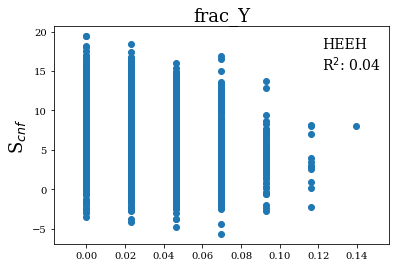

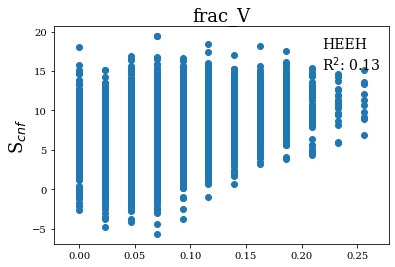

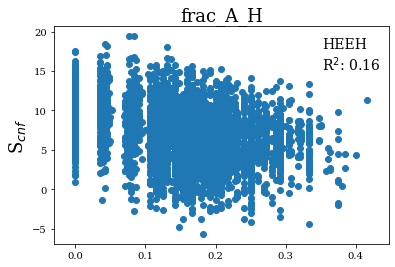

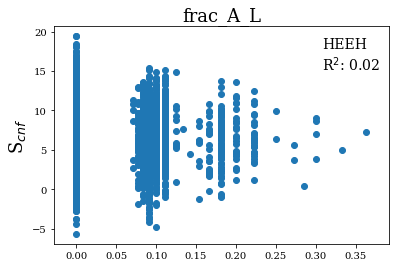

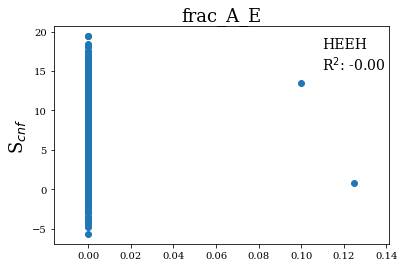

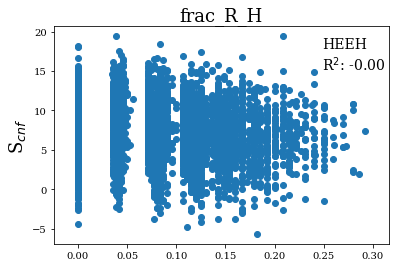

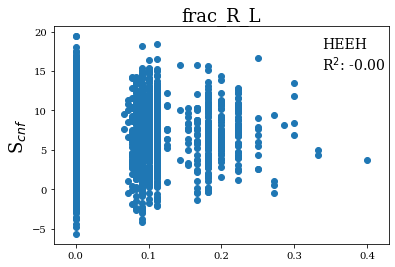

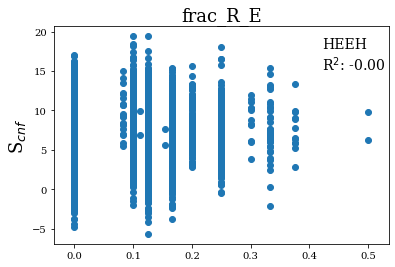

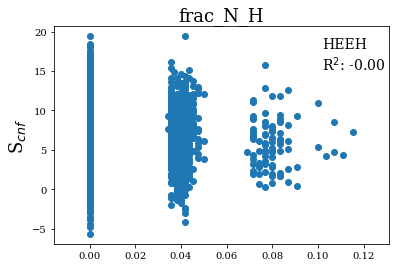

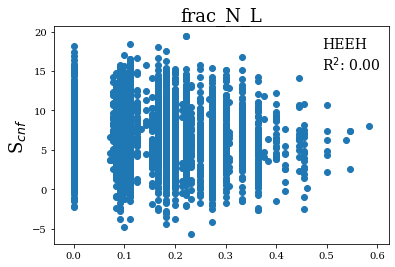

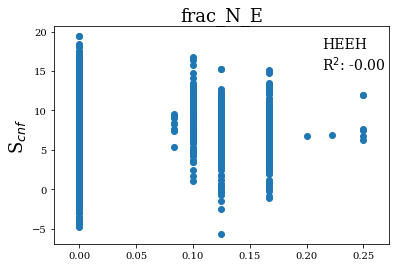

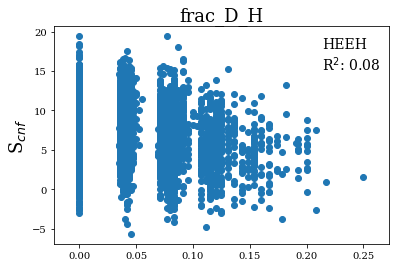

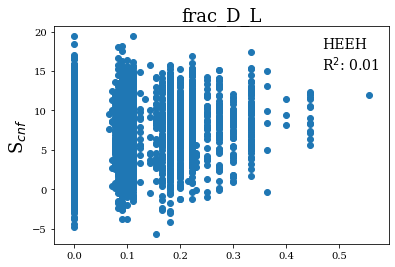

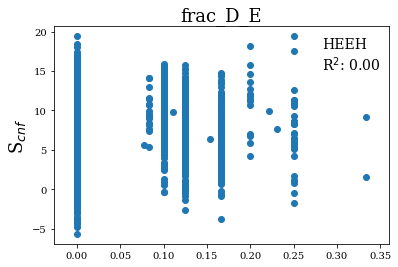

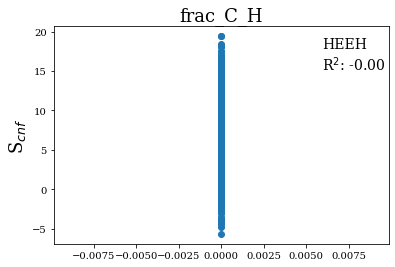

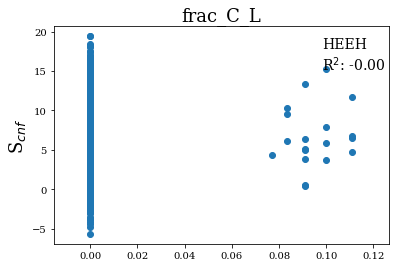

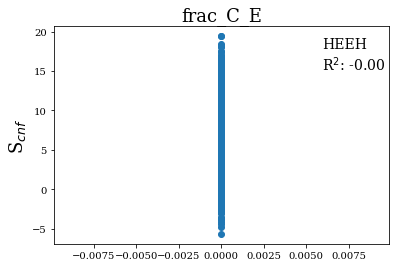

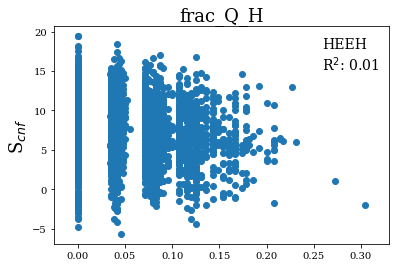

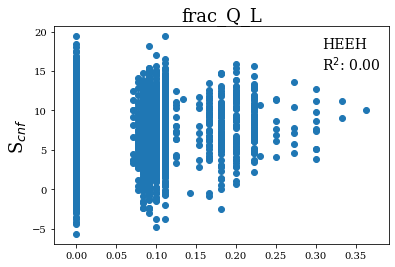

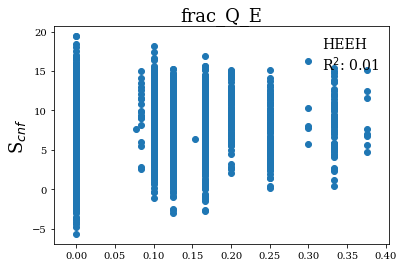

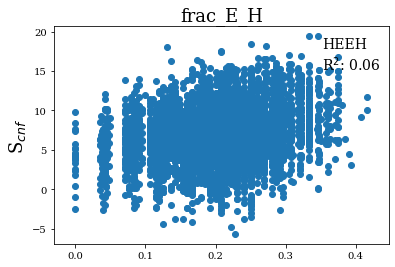

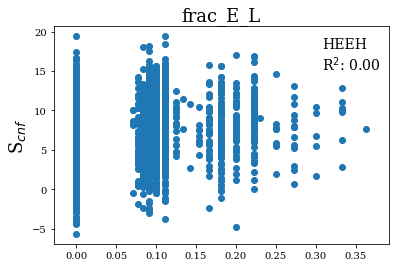

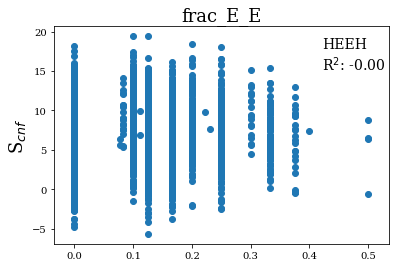

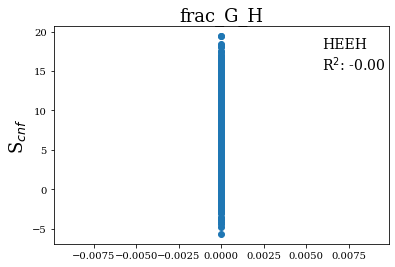

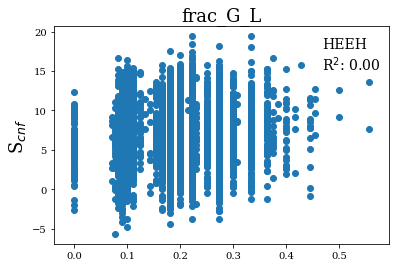

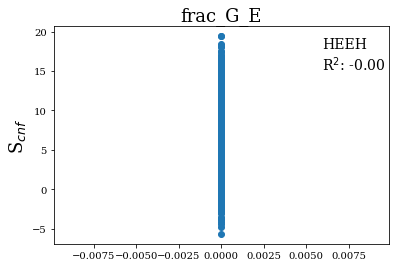

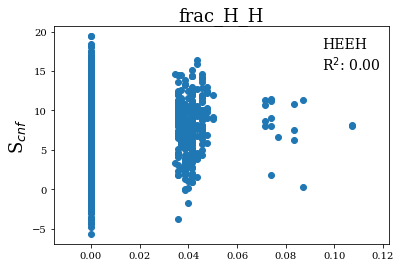

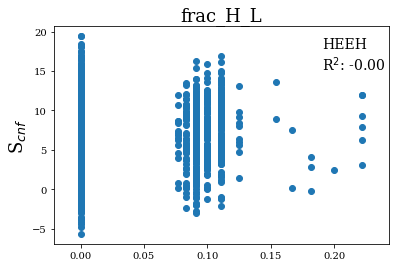

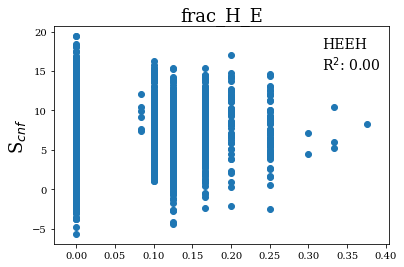

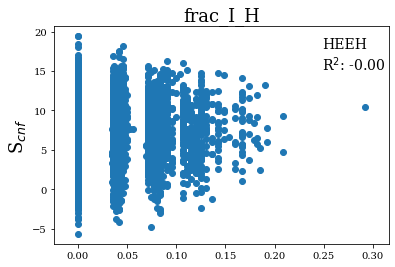

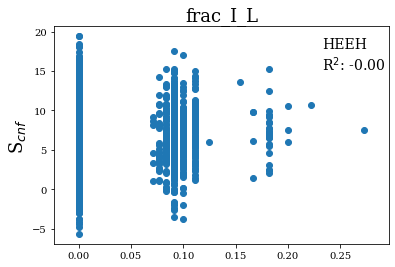

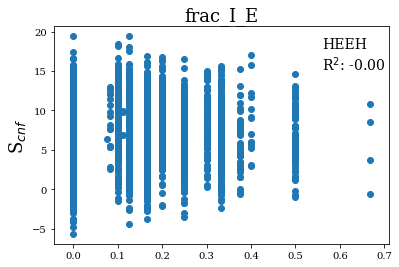

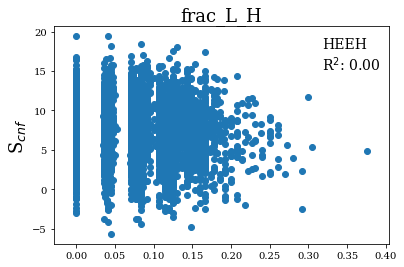

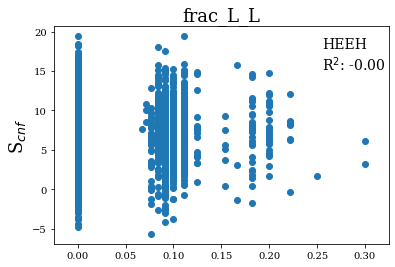

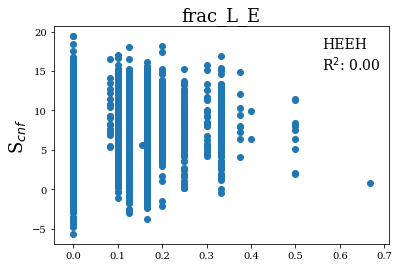

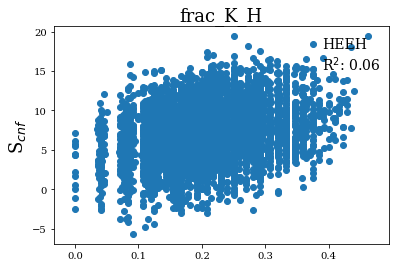

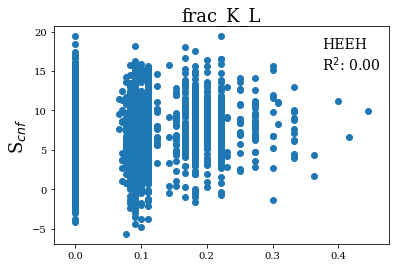

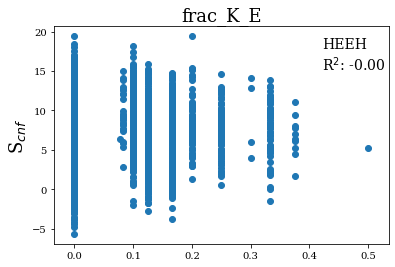

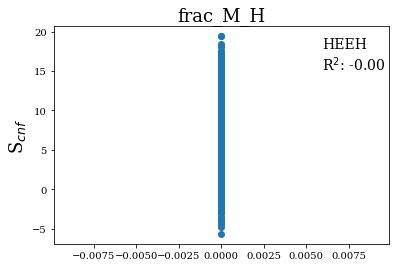

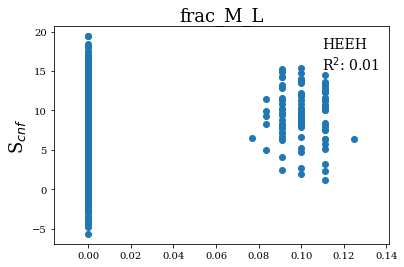

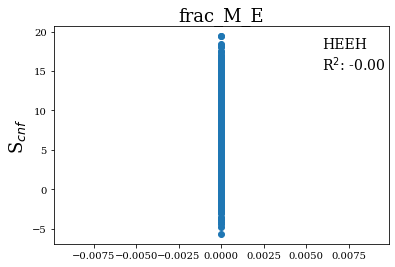

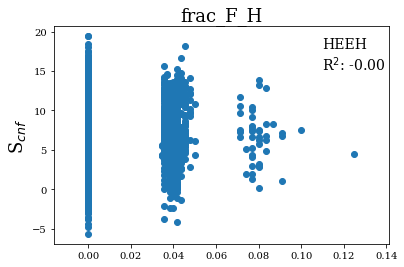

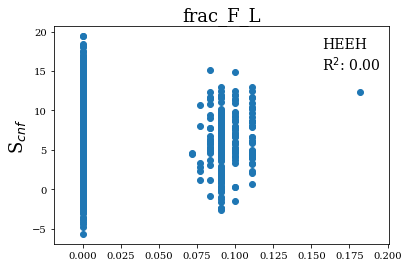

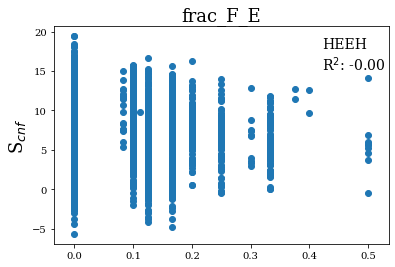

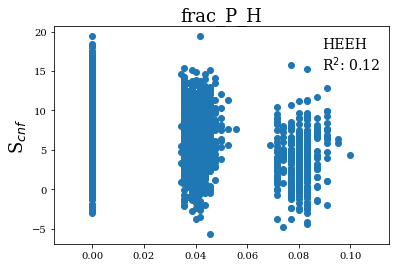

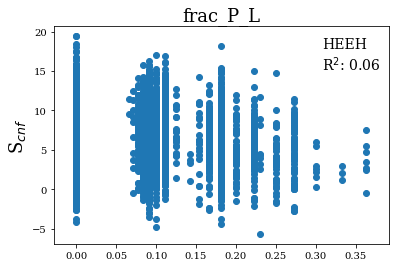

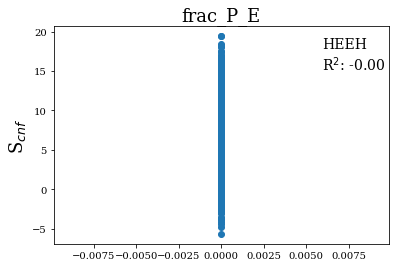

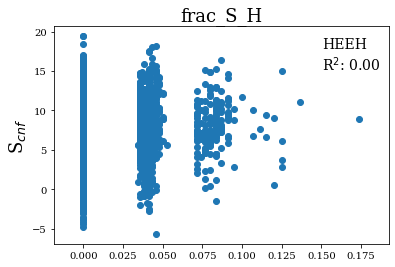

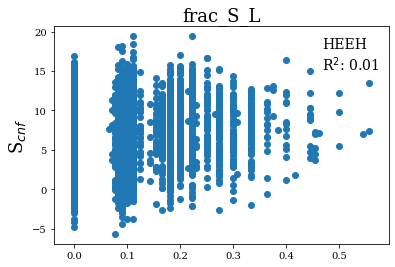

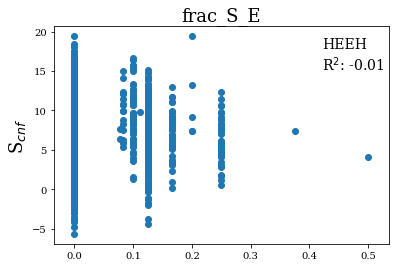

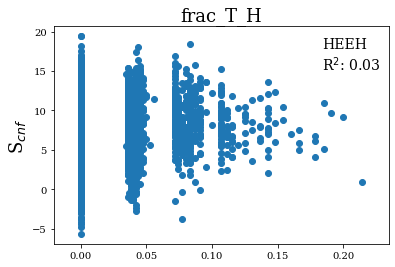

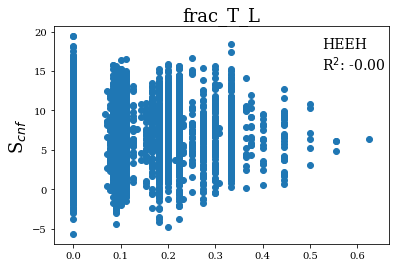

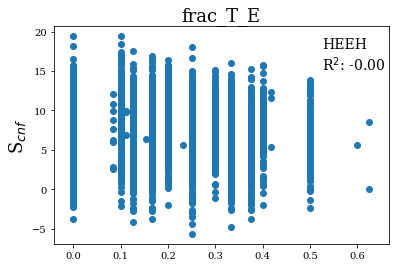

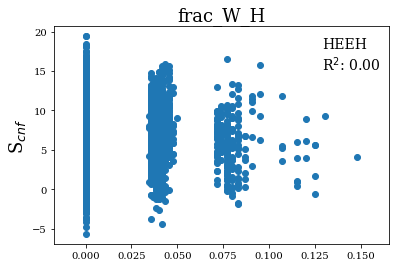

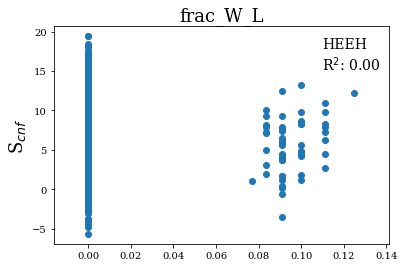

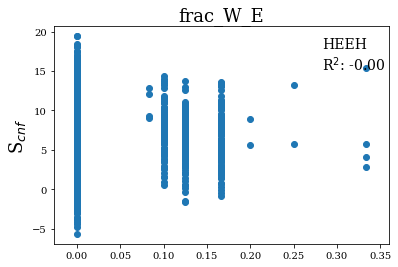

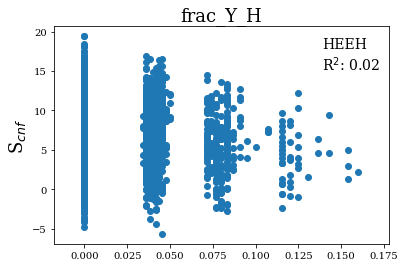

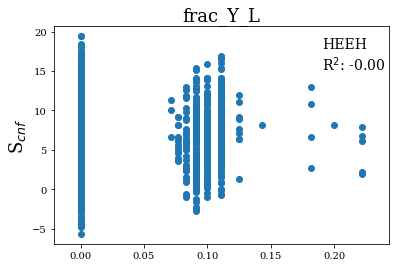

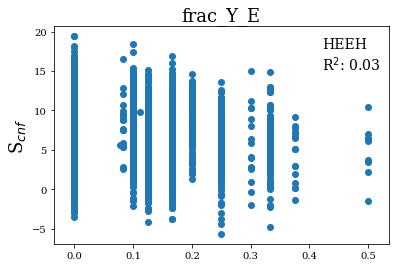

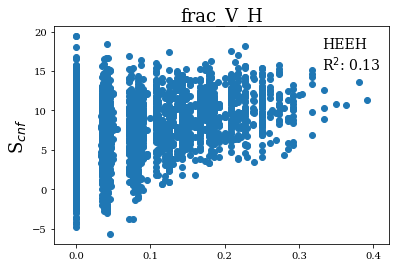

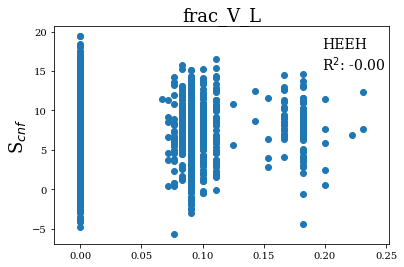

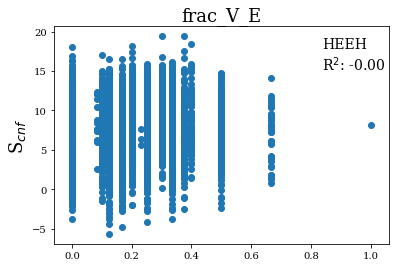

R2 Score:  0.8015449897358723
RMSE/Range:  0.09158105270573078
MAE/Range:  0.07258104369784132


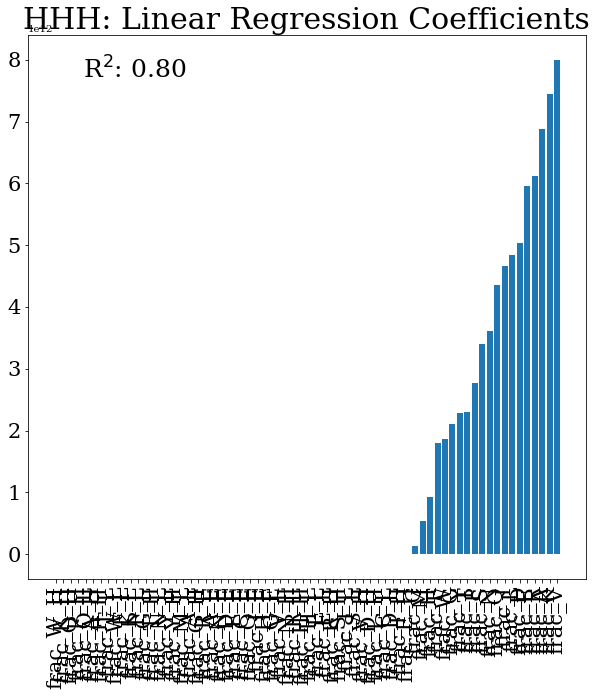

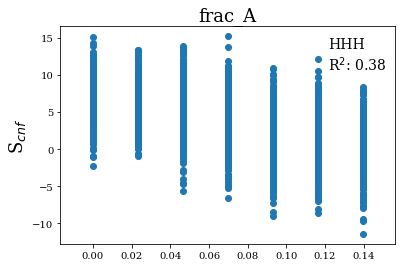

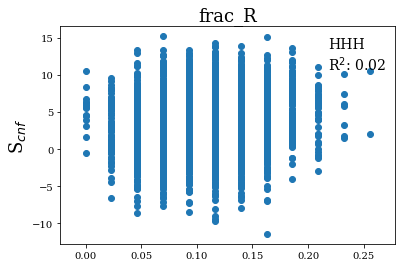

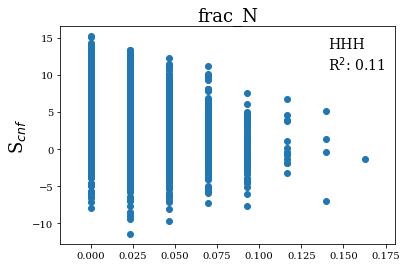

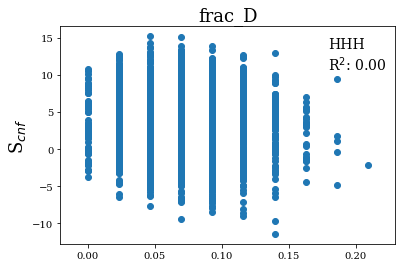

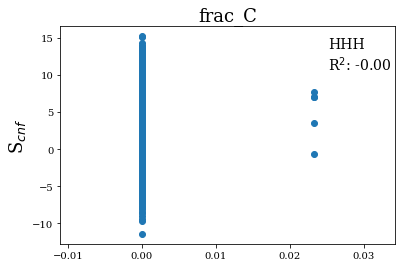

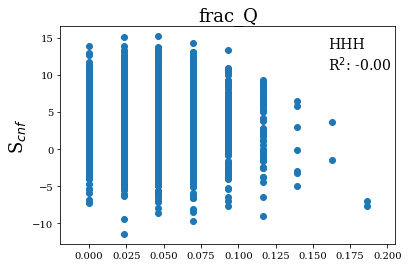

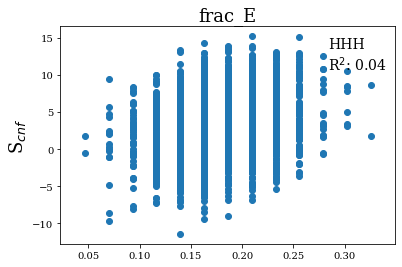

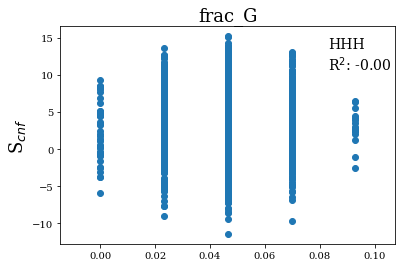

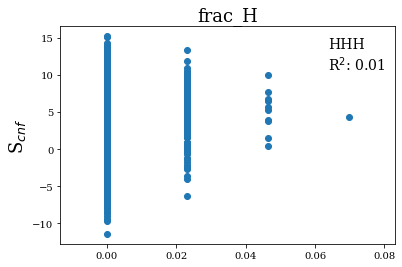

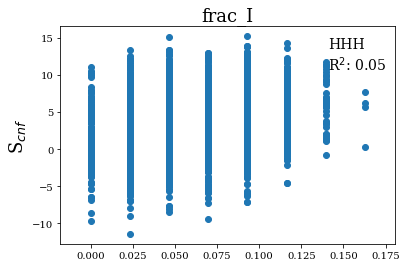

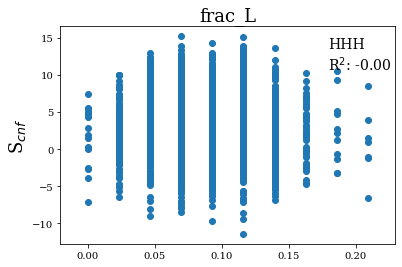

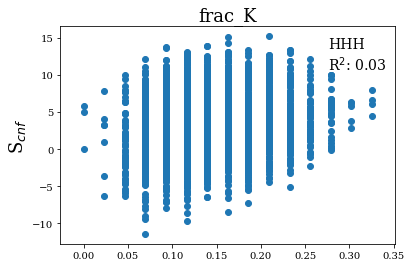

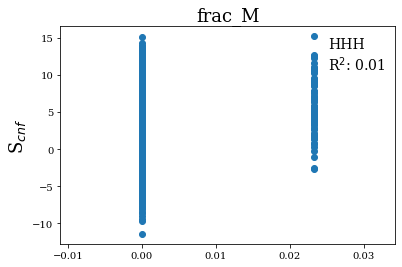

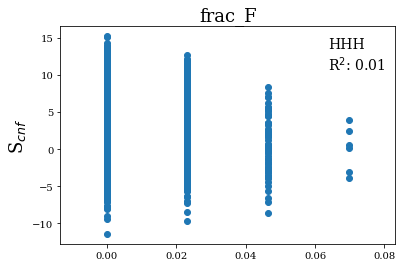

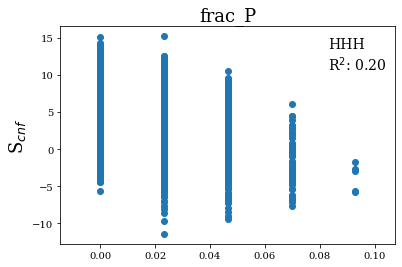

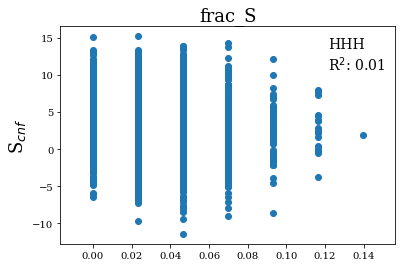

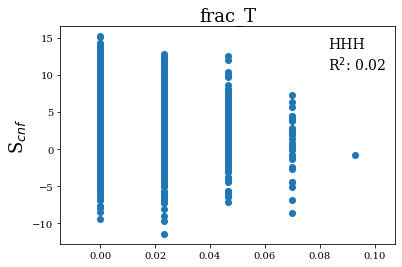

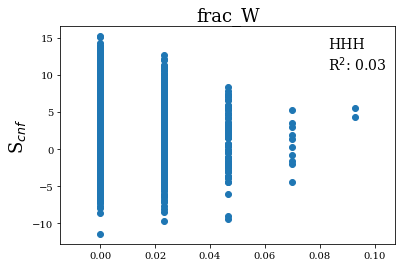

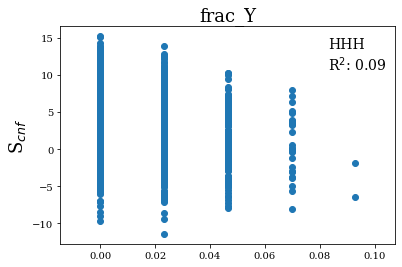

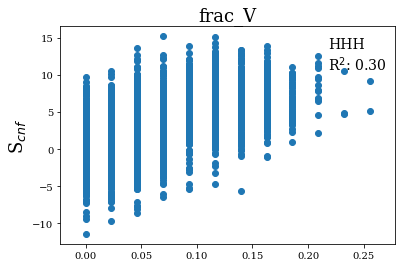

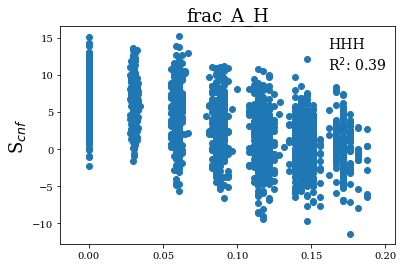

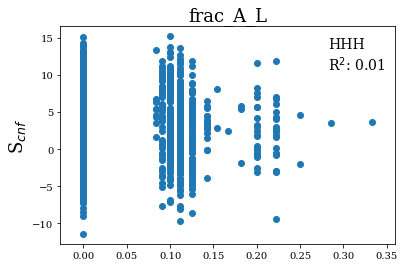

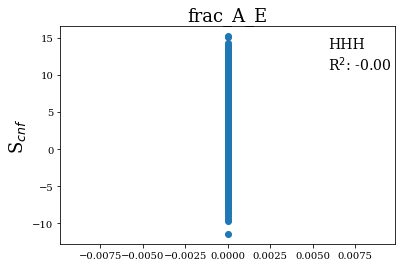

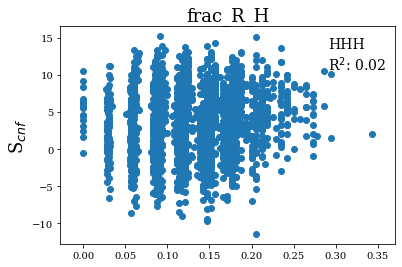

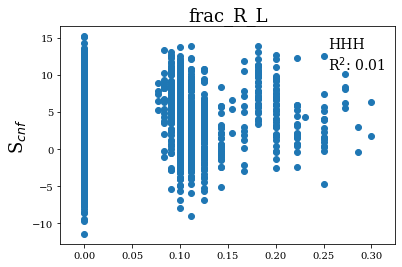

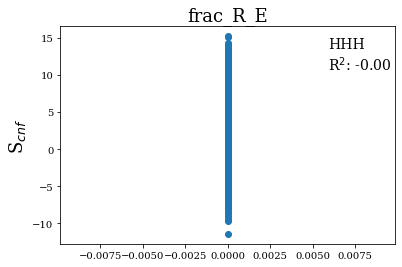

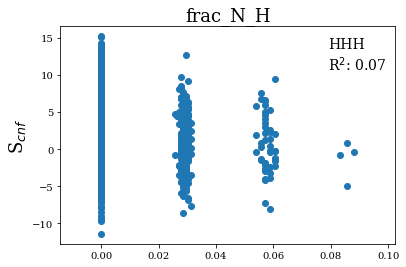

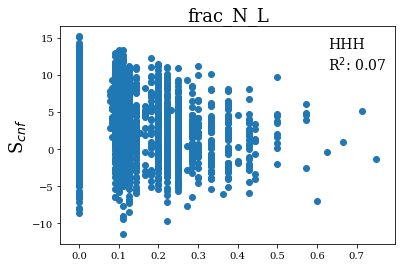

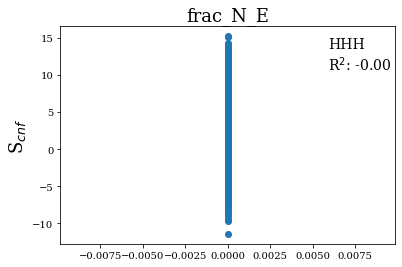

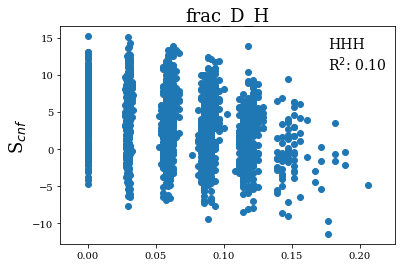

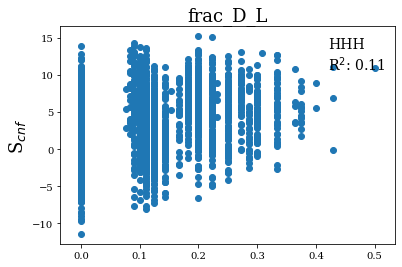

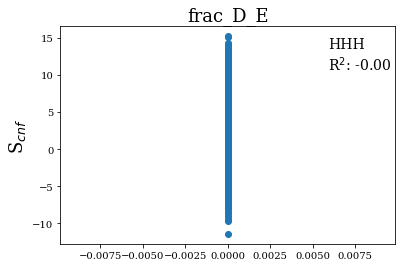

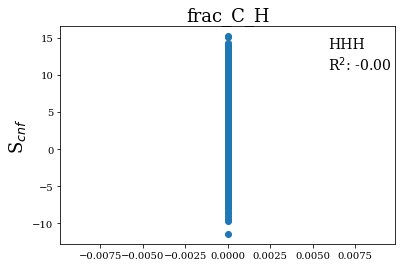

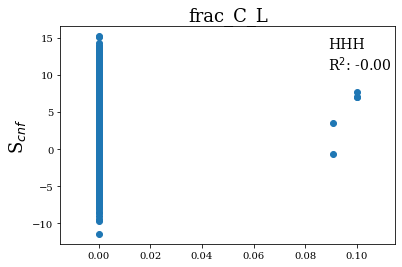

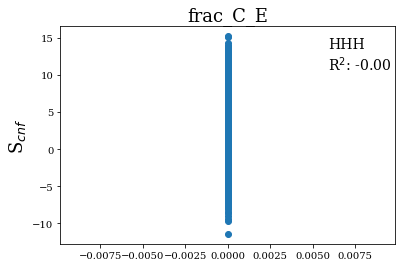

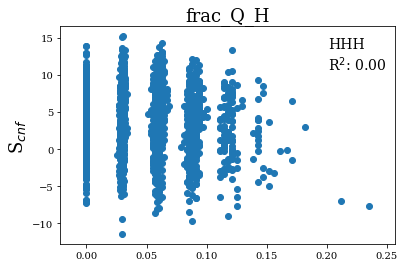

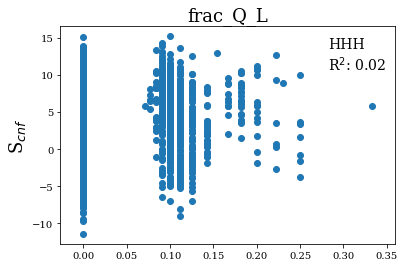

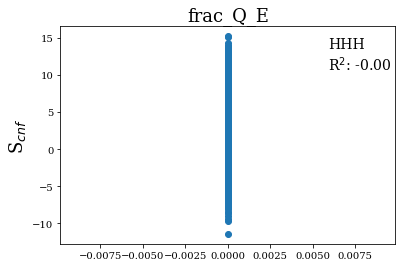

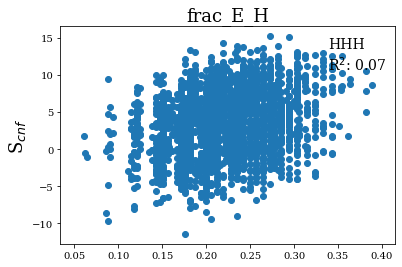

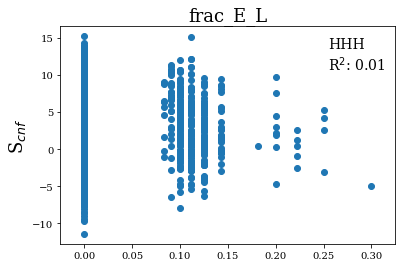

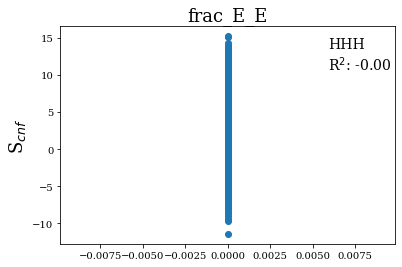

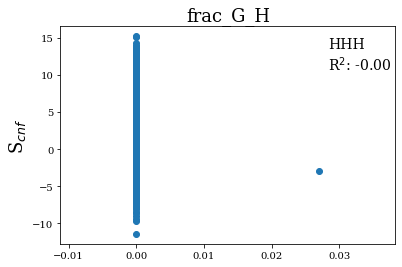

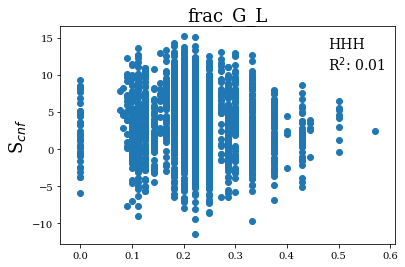

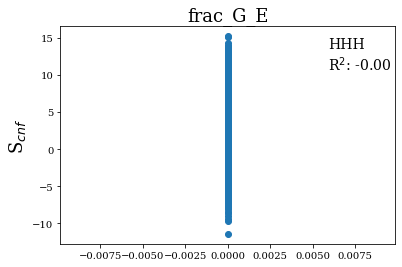

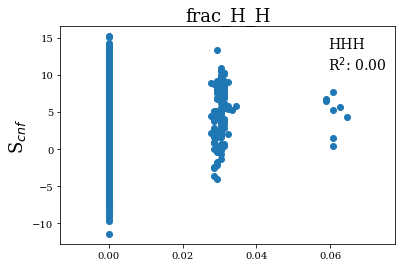

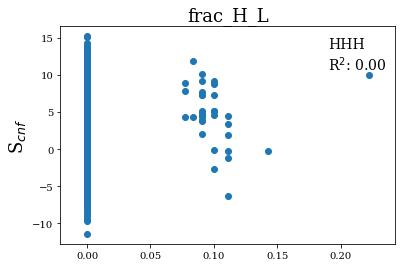

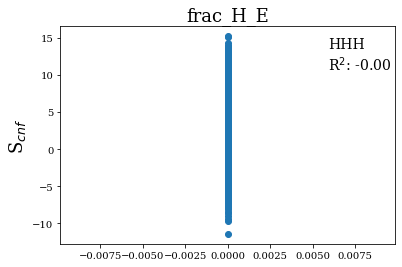

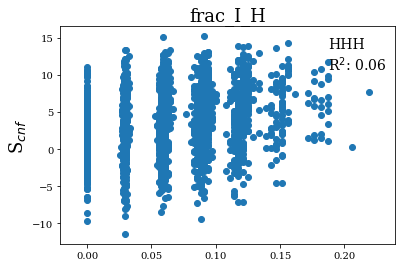

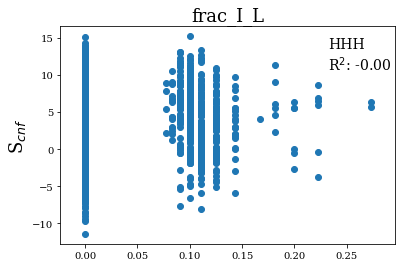

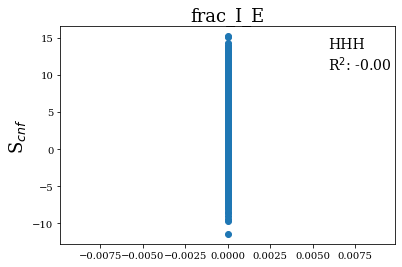

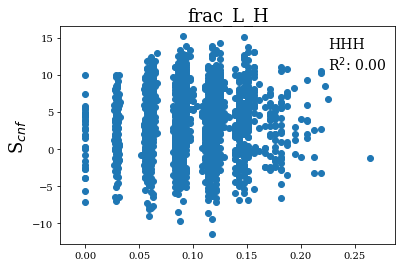

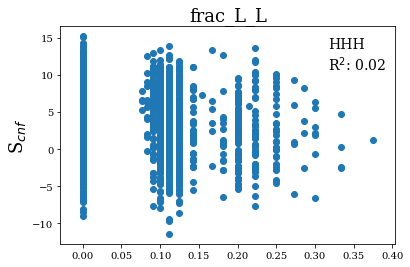

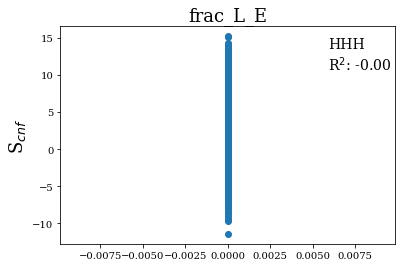

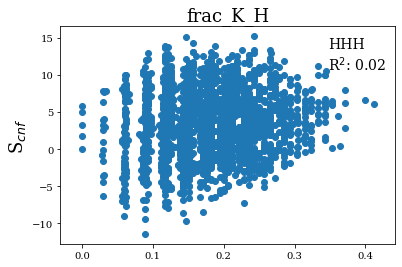

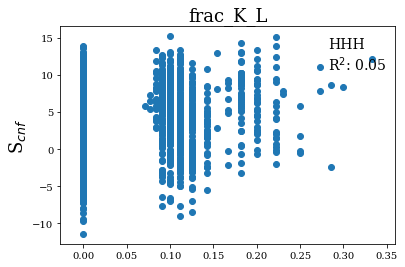

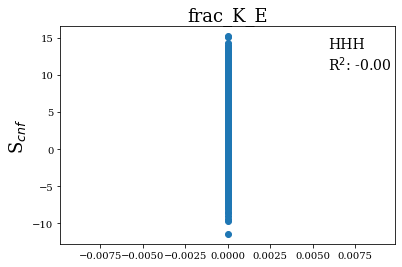

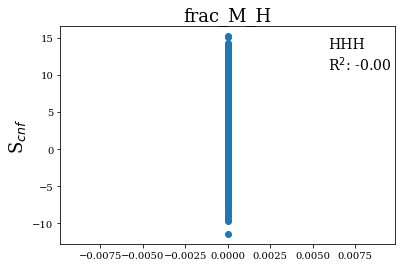

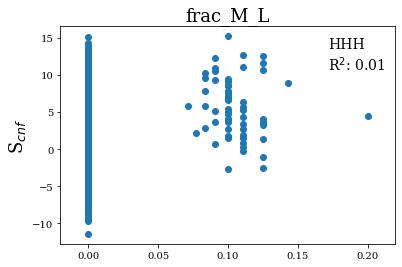

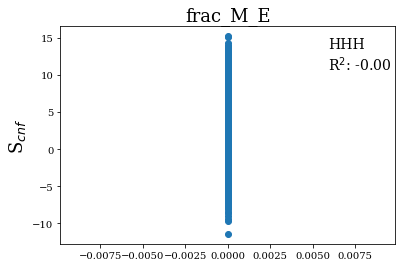

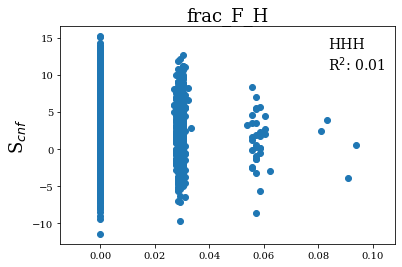

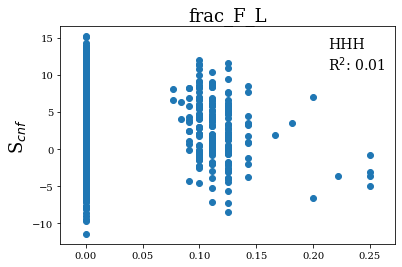

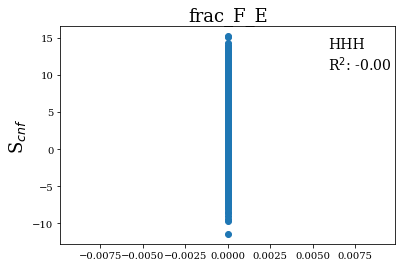

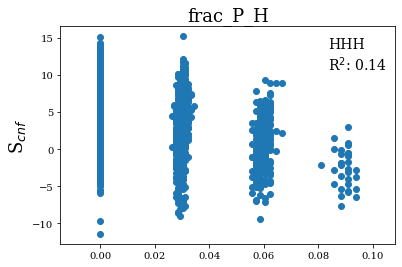

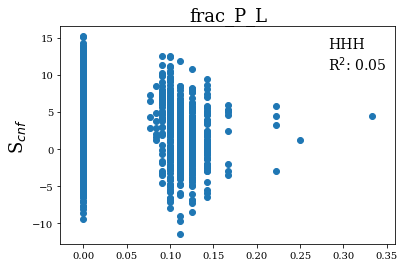

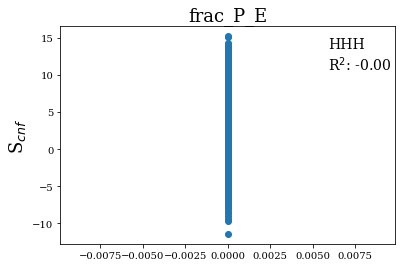

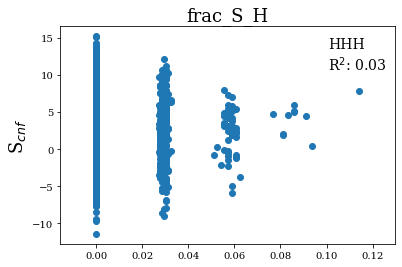

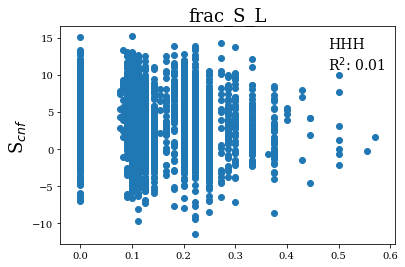

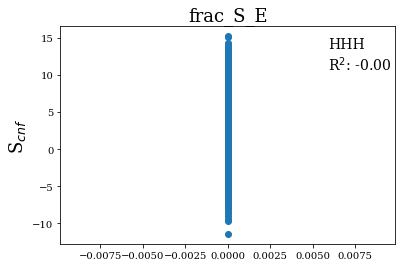

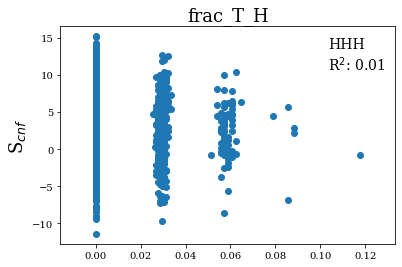

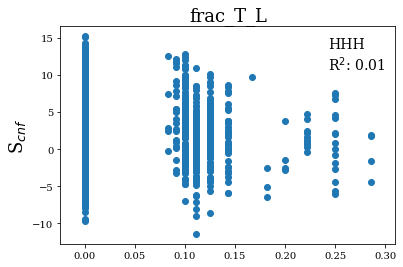

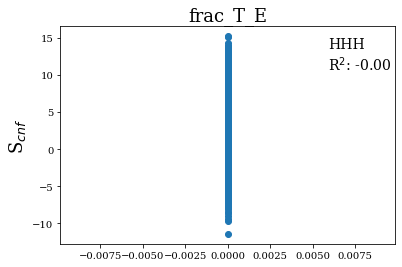

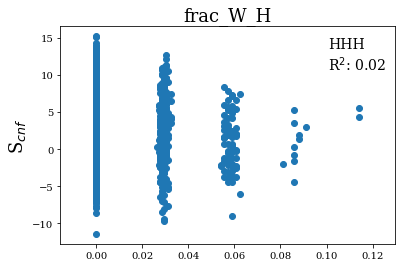

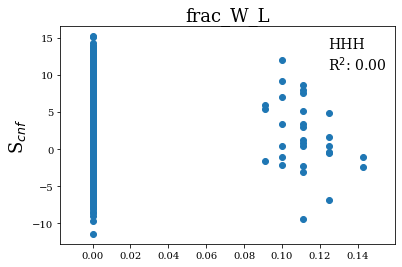

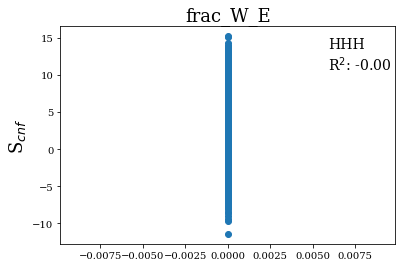

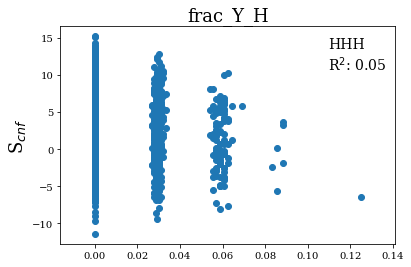

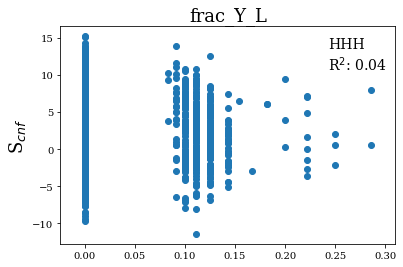

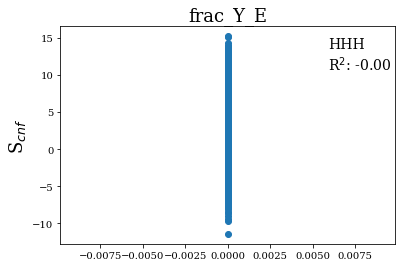

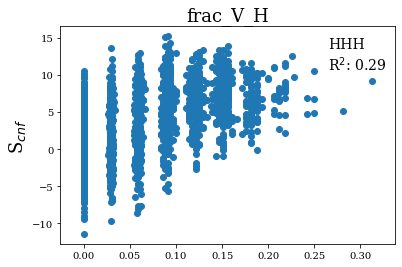

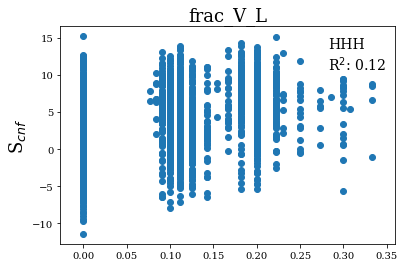

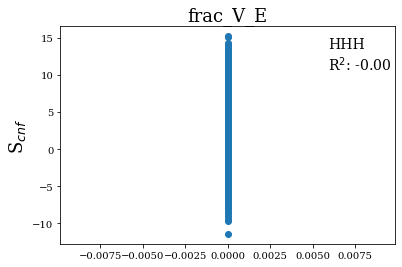

In [89]:
for i in range(len(df["topology"].unique())):
    # reduce dataset to relevant topology
    topology = df["topology"].unique()[i]
    sub_df = df[df["topology"]==topology]
    training_features = frac_aas+frac_aas_ss
    
    # do train-test split
    train, test = train_test_split(sub_df[training_features+["S_PC"]], test_size=0.2, random_state=5)
    train.fillna(0,inplace=True)
    test.fillna(0,inplace=True)
    # train lnr and visualize coefs


    #set up splits
    X_train = train[training_features]
    y_train = train["S_PC"]

    X_test = test[training_features]
    y_test = test["S_PC"]

    #standardize features
    scaler = StandardScaler()
    scaler.fit(X_train)

    X_train_std = pd.DataFrame(scaler.transform(X_train),columns=X_train.columns)
    X_test_std = pd.DataFrame(scaler.transform(X_test),columns=X_test.columns)

    #merged X and y data
    X = pd.concat([X_train_std,X_test_std])
    X = X.reset_index(drop=True)

    y = pd.concat([y_train,y_test])
    y = y.reset_index(drop=True)



    #set up a linear regression trained to predict S_PC
    model_lnr = LinearRegression(normalize=False)

    #fit the data
    model_lnr.fit(X_train_std,y_train)

    #predict
    y_pred_lnr = model_lnr.predict(X_test_std)

    #get results
    print("R2 Score: ",r2_score(y_test.values,y_pred_lnr))
    range_spc = y_test.max() - y_test.min() #get range of predicted values
    print("RMSE/Range: ",np.sqrt(mean_squared_error(y_test.values,y_pred_lnr))/range_spc)
    print("MAE/Range: ",mean_absolute_error(y_test.values,y_pred_lnr)/range_spc)

    zipped_coeff = zip(training_features,list(model_lnr.coef_))
    coeff_dict = {}
    for pair in zipped_coeff:
        #print(pair)
        if abs(pair[1]):
            coeff_dict[pair[0]] = pair[1]

    sorted_dict_tuple = sorted(coeff_dict.items(), key=operator.itemgetter(1))
    sorted_coeff_dict = dict(sorted_dict_tuple)

    sorted_coeffs = [sorted_coeff_dict[key] for key in sorted_coeff_dict]
    f, ax = plt.subplots(figsize=(10,10))
    ax.bar(sorted_coeff_dict.keys(), sorted_coeffs)
    plt.xticks(rotation="90",fontsize="21")
    plt.yticks(fontsize='21')
    plt.text(x=0.1, y=0.92, s="R$^{2}$: %0.2f"%r2_score(y_test.values,y_pred_lnr),transform=ax.transAxes,fontsize='25')
    plt.title("%s: Linear Regression Coefficients"%topology,fontsize=30)
    plt.show()

    
    
    
    for i in range(len(training_features)):
        aa = training_features[i]
        plt.figure()
        plt.scatter(sub_df[aa],sub_df["S_PC"])
        plt.title(aa,fontsize='18')
        plt.ylabel("S$_{cnf}$",fontsize='18')
        ax = plt.gca()
        plt.text(.80,.8,s="%s\nR$^{2}$: %0.2f"%(topology,train_linear_regression([aa])), transform=ax.transAxes,fontsize='14')
        plt.show()


In [90]:
f, t = df[df["topology"]=='HHH']["stabilityscore_cnn_calibrated_2classes"].value_counts()
t/(t+f)

0.45484001620089104

## Topology model breakdown

R2 Score:  0.5071101858218102
RMSE/Range:  0.09169381436096397
MAE/Range:  0.07305695135832807
R2 Score:  0.621411107455704
RMSE/Range:  0.10127009042902632
MAE/Range:  0.07980970599512471
R2 Score:  0.606492752880494
RMSE/Range:  0.0960953376935352
MAE/Range:  0.07630790251749671
R2 Score:  0.5528502197281389
RMSE/Range:  0.09321031257203129
MAE/Range:  0.0728214869884446


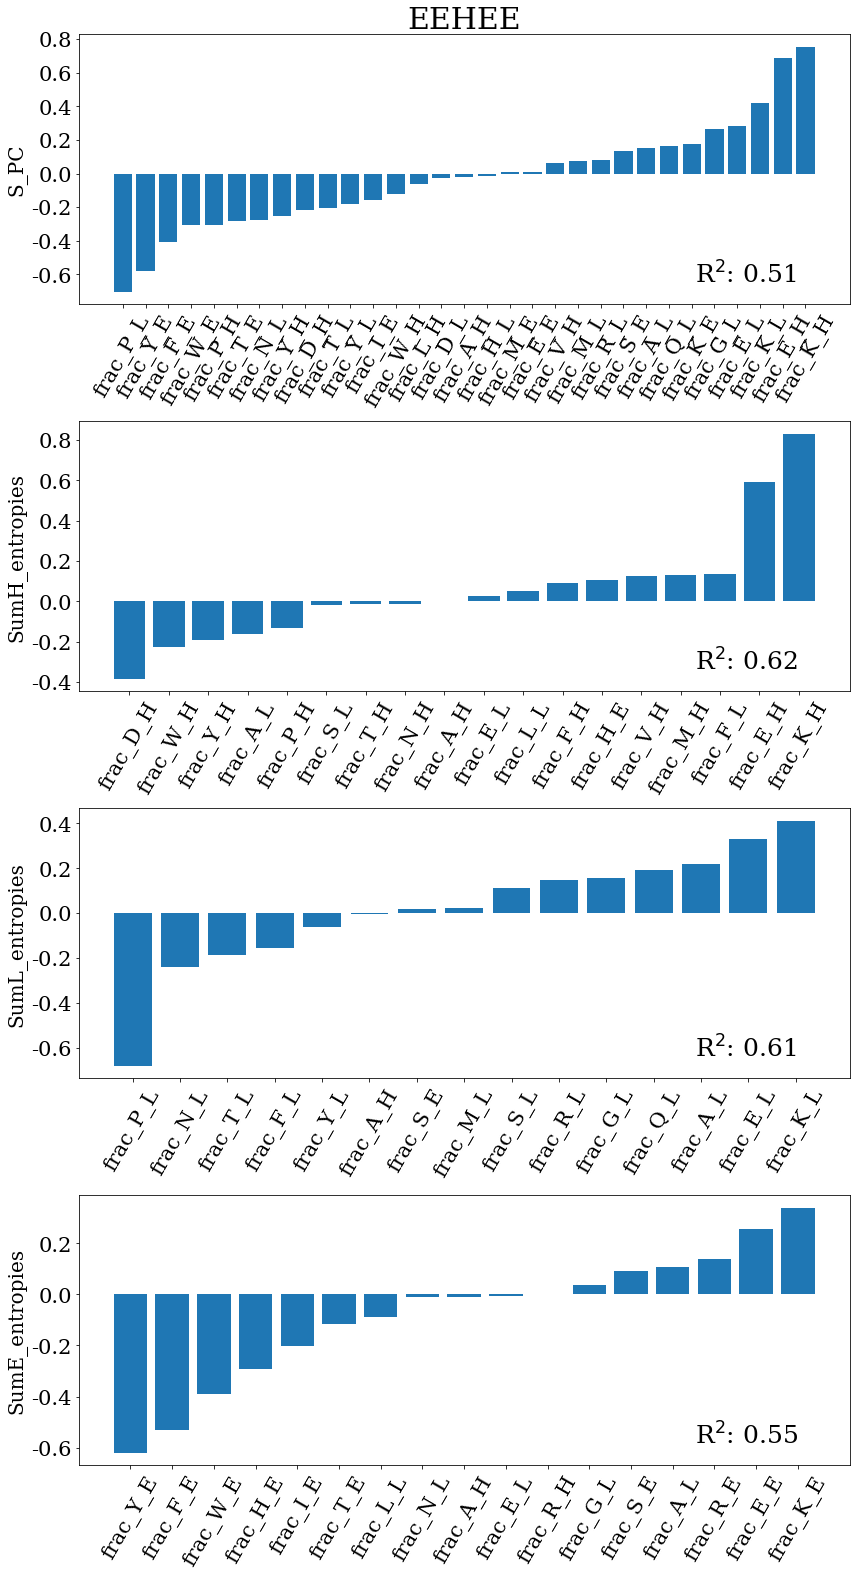

In [173]:
f, ax = plt.subplots(nrows=4,figsize=(12,22))
# reduce dataset to relevant topology
topology = "EEHEE"
pred_vars = ["S_PC","SumH_entropies","SumL_entropies","SumE_entropies"]
for iVar in range(len(pred_vars)):
    predicted_variable  = pred_vars[iVar] 
    sub_df = df[df["topology"]==topology]

    #sub_fets = [i for i in frac_aas_ss if i[-1]=="H"] # only look at the beta sheet frac's
    sub_fets = frac_aas_ss

    # do train-test split
    train, test = train_test_split(sub_df[sub_fets+[predicted_variable]], test_size=0.2, random_state=5)

    # train lnr and visualize coefs


    #set up splits
    X_train = train[sub_fets]
    y_train = train[predicted_variable]

    X_test = test[sub_fets]
    y_test = test[predicted_variable]

    #standardize features
    scaler = StandardScaler()
    scaler.fit(X_train)

    X_train_std = pd.DataFrame(scaler.transform(X_train),columns=X_train.columns)
    X_test_std = pd.DataFrame(scaler.transform(X_test),columns=X_test.columns)

    #merged X and y data
    X = pd.concat([X_train_std,X_test_std])
    X = X.reset_index(drop=True)

    y = pd.concat([y_train,y_test])
    y = y.reset_index(drop=True)



    #set up a linear regression trained to predict SumE_entropies
    #model_lnr = LinearRegression(normalize=False)
    model_lnr = Lasso(alpha=.1)
    #fit the data
    model_lnr.fit(X_train_std,y_train)

    #predict
    y_pred_lnr = model_lnr.predict(X_test_std)

    #get results
    print("R2 Score: ",r2_score(y_test.values,y_pred_lnr))
    range_spc = y_test.max() - y_test.min() #get range of predicted values
    print("RMSE/Range: ",np.sqrt(mean_squared_error(y_test.values,y_pred_lnr))/range_spc)
    print("MAE/Range: ",mean_absolute_error(y_test.values,y_pred_lnr)/range_spc)

    zipped_coeff = zip(sub_fets,list(model_lnr.coef_))
    coeff_dict = {}
    for pair in zipped_coeff:
        #print(pair)
        if abs(pair[1]):
            coeff_dict[pair[0]] = pair[1]

    sorted_dict_tuple = sorted(coeff_dict.items(), key=operator.itemgetter(1))
    sorted_coeff_dict = dict(sorted_dict_tuple)

    sorted_coeffs = [sorted_coeff_dict[key] for key in sorted_coeff_dict]
    #f, ax = plt.subplots(figsize=(30,5))
    ax[iVar].bar(sorted_coeff_dict.keys(), sorted_coeffs)
    #ax[iVar].set_xticks(rotation="45",fontsize="21")
    #ax[iVar].yticks(fontsize='21')
    plt.ylabel(predicted_variable,fontsize='20')
    #plt.yscale("log")
    ax[iVar].text(x=0.80, y=0.080, s="R$^{2}$: %0.2f"%r2_score(y_test.values,y_pred_lnr),transform=ax[iVar].transAxes,fontsize='25')
    #plt.title("%s: Linear Regression Coefficients"%topology,fontsize=30)
    ax[iVar].set_xticklabels(sorted_coeff_dict.keys(),rotation="60",fontsize='21')
    ax[iVar].set_ylabel(predicted_variable,fontsize='20')
    ax[iVar].set_yticklabels([round(i,2) for i in ax[iVar].get_yticks()],fontsize='21')
ax[0].set_title("%s"%topology,fontsize='30')
plt.tight_layout()
plt.show()





###  Cross validation

R2 scores: [0.005404148942193876, -0.06425282495218831, -0.9123159776946093, -0.6229624157331803, -0.549365165721925]
R2 scores: [-0.056142742322044414, -0.07852299874868973, -0.8894829089584328, -0.5939943486273214, -0.6018134759779734]
R2 scores: [0.5923728790786559, 0.5663671499618108, 0.6753362944183665, 0.5561194358713677, 0.6461642509899705]
R2 scores: [1.0, 1.0, 1.0, 1.0, 1.0]


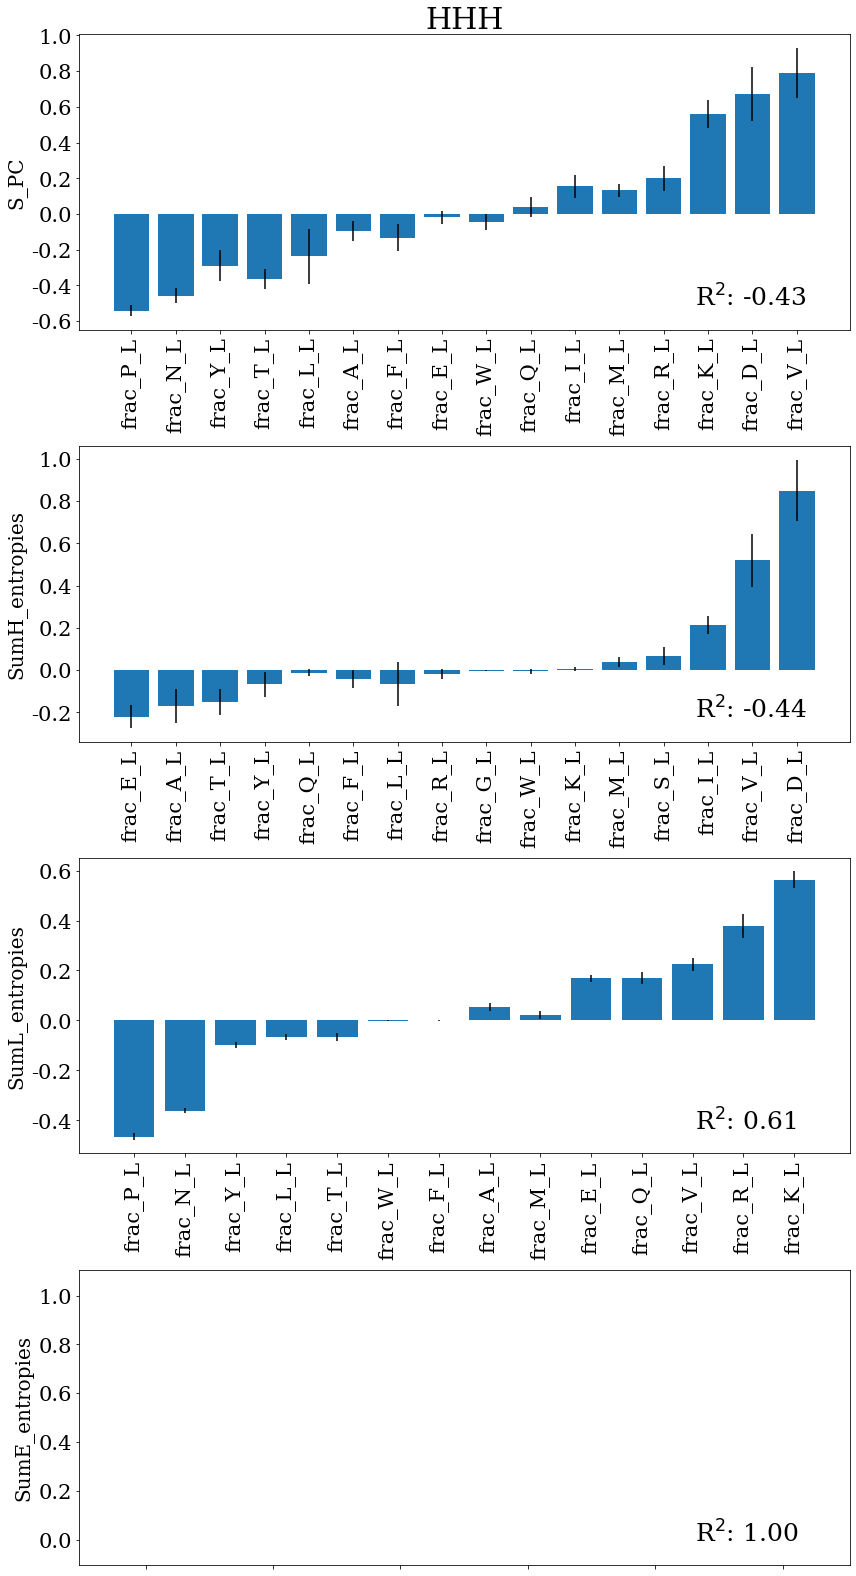

In [174]:
f, ax = plt.subplots(nrows=4,figsize=(12,22))
from sklearn.model_selection import KFold # import for KFold cross validation
kf = KFold(n_splits=5)
# reduce dataset to relevant topology
topology = "HHH"
pred_vars = ["S_PC","SumH_entropies","SumL_entropies","SumE_entropies"]
for iVar in range(len(pred_vars)):
    predicted_variable  = pred_vars[iVar] 
    sub_df = df[df["topology"]==topology].reset_index()

    sub_fets = [i for i in frac_aas_ss if i[-1]=="L"] # only look at the beta sheet frac's
    #sub_fets = frac_aas_ss
    
    X = sub_df[sub_fets] # choose features
    y = sub_df[predicted_variable] # choose variable to predict
    
    #standardize features
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    
    counter = 0
    coeffs = []
    r2_scores = []
    for train_index, test_index in kf.split(X):
        counter+=1

        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
    


        

#         X_train_std = pd.DataFrame(scaler.transform(X_train),columns=X_train.columns)
#         X_test_std = pd.DataFrame(scaler.transform(X_test),columns=X_test.columns)


        model_lnr = Lasso(alpha=0.1)
        #fit the data
        model_lnr.fit(X_train,y_train)

        #predict
        y_pred_lnr = model_lnr.predict(X_test)
#         print(f"cv_{counter}")
        #get results
#         print("R2 Score: ",r2_score(y_test.values,y_pred_lnr))
        r2_scores.append(r2_score(y_test.values,y_pred_lnr))
        range_spc = y_test.max() - y_test.min() #get range of predicted values
#         print("RMSE/Range: ",np.sqrt(mean_squared_error(y_test.values,y_pred_lnr))/range_spc)
#         print("MAE/Range: ",mean_absolute_error(y_test.values,y_pred_lnr)/range_spc)
        coeffs.append(model_lnr.coef_) # add the coefficients for this cross validation to a list
    
    # organize the list so for each coeffiecient we get them in the same list
    organized_coeffs = []
    for i in range(len(coeffs[0])):
        values = []
        for row in coeffs:
            values.append(row[i])
        organized_coeffs.append(values)
        
    
    zipped_coeff = zip(sub_fets,organized_coeffs)
    coeff_dict = {}
    for pair in zipped_coeff:
        #print(pair)
        if abs(np.mean(pair[1])): # only add coefficients that are non-zero on average
            coeff_dict[pair[0]] = pair[1]
        
    sorted_dict_tuple = sorted(coeff_dict.items(), key=operator.itemgetter(1))
    sorted_coeff_dict = dict(sorted_dict_tuple)
    print("R2 scores:", r2_scores)
    sorted_coeffs = [sorted_coeff_dict[key] for key in sorted_coeff_dict]
    #print("SORTED COEFFS:",sorted_coeffs)
    #print(sorted_coeff_dict.keys())
    #f, ax = plt.subplots(figsize=(30,5))
    ax[iVar].bar(sorted_coeff_dict.keys(), height=[np.mean(x) for x in sorted_coeffs], yerr = [np.std(x) for x in sorted_coeffs])
    #ax[iVar].set_xticks(rotation="45",fontsize="21")
    #ax[iVar].yticks(fontsize='21')
    plt.ylabel(predicted_variable,fontsize='20')
    #plt.yscale("log")
    ax[iVar].text(x=0.80, y=0.080, s="R$^{2}$: %0.2f"%np.mean(r2_scores),transform=ax[iVar].transAxes,fontsize='25')
    #plt.title("%s: Linear Regression Coefficients"%topology,fontsize=30)
    ax[iVar].set_xticklabels(sorted_coeff_dict.keys(),rotation="90",fontsize='21')
    ax[iVar].set_ylabel(predicted_variable,fontsize='20')
    ax[iVar].set_yticklabels([round(i,2) for i in ax[iVar].get_yticks()],fontsize='21')
ax[0].set_title("%s"%topology,fontsize='30')
plt.tight_layout()
plt.show()





**EEHEE proteins**

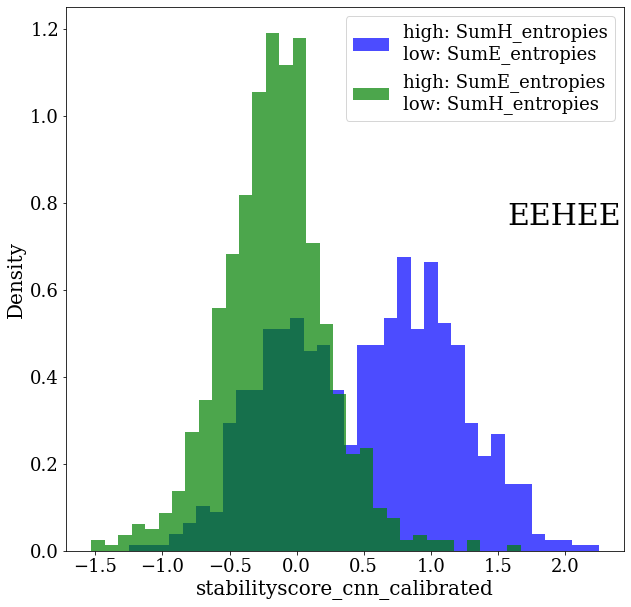

In [92]:
fet_majors = ["SumH_entropies","SumE_entropies"]
#fet_majors2 = ["frac_K_H",'frac_F_E']

fet_minors = ["SumE_entropies",'SumH_entropies']
#fet_minors2 = ["frac_F_E","frac_K_H"]

colors = ["blue",'green']
sizes = [80,50]
shapes = ["x","o"]

alphas = [.7,.7]
n_sigmas_major = 1 # number of standard deviations from the mean that we want as cutoff
n_sigmas_minor = 1

df_topology = df[df["topology"]=="EEHEE"]
predicted_var = "stabilityscore_cnn_calibrated"

plt.figure(figsize=(10,10))
for i in range(len(fet_majors)):

    fet_major = fet_majors[i]
    #fet_major2 = fet_majors2[i]
    
    fet_minor = fet_minors[i]
    #fet_minor2 = fet_minors2[i]
    



    fet_major_mean = df_topology[fet_major].mean()
    fet_major_std = df_topology[fet_major].std()
    fet_major_cutoff = fet_major_mean + n_sigmas_major*fet_major_std
    
    
#     fet_major_mean2 = df_topology[fet_major2].mean()
#     fet_major_std2 = df_topology[fet_major2].std()
#     fet_major_cutoff2 = fet_major_mean2 + n_sigmas_major*fet_major_std2
    
    fet_minor_mean = df_topology[fet_minor].mean()
    fet_minor_std = df_topology[fet_minor].std()
    fet_minor_cutoff = fet_minor_mean + n_sigmas_minor*fet_minor_std
    
    
#     fet_minor_mean2 = df_topology[fet_minor2].mean()
#     fet_minor_std2 = df_topology[fet_minor2].std()
#     fet_minor_cutoff2 = fet_minor_mean2 + n_sigmas_minor*fet_minor_std2
    
    #df_sub_majors = df_topology.loc[(df_topology[fet_major]>fet_major_cutoff) & (df_topology[fet_major2] > fet_major_cutoff2),:]
    df_sub_majors = df_topology.loc[(df_topology[fet_major]>fet_major_cutoff),:]
    #df_sub_minors = df_sub_majors.loc[(df_sub_majors[fet_minor]<fet_minor_cutoff) & (df_sub_majors[fet_minor2] < fet_minor_cutoff2),:]
    df_sub_minors = df_sub_majors.loc[(df_sub_majors[fet_minor]<fet_minor_cutoff),:]
    df_sub = df_sub_minors
    #l="high: %s, %s\nlow: %s, %s"%(fet_major,fet_major2,fet_minor,fet_minor2)
    l="high: %s\nlow: %s"%(fet_major,fet_minor)
#     plt.scatter(df_sub[predicted_var],df_sub[predicted_var],
#                 label=l,
#                color = colors[i],alpha=alphas[i],marker=shapes[i],s=sizes[i])
    max_val = max(df_sub[predicted_var]) 
    min_val = min(df_sub[predicted_var])
    plt.hist(x=df_sub[predicted_var],label=l,color=colors[i],alpha=alphas[i],
            bins=list(np.arange(min_val,max_val,.1)),density=True)
plt.legend(fontsize='18')
plt.yticks(fontsize='18')
plt.xticks(fontsize='18')
plt.ylabel("Density",fontsize='20')
plt.xlabel(predicted_var,fontsize='20')
plt.text(x=0.79,y=0.6,s="EEHEE",transform = plt.gca().transAxes,fontsize='30')
plt.show()


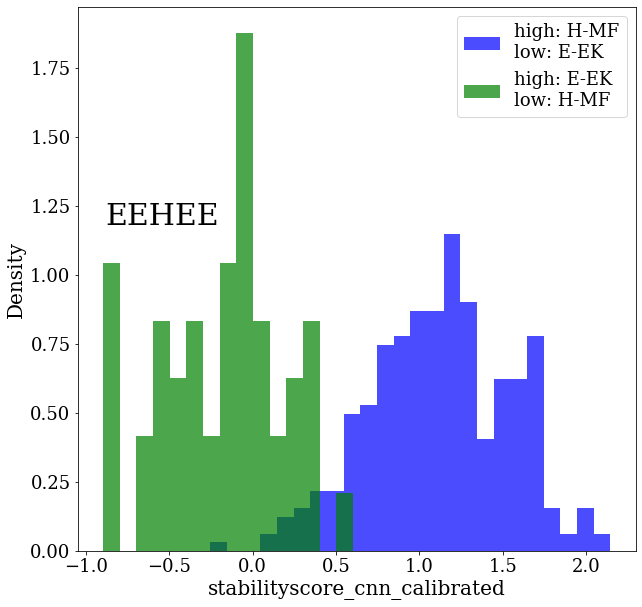

In [93]:
fet_majors = ["frac_M_H","frac_E_E"]
fet_majors2 = ["frac_F_H",'frac_K_E']


fet_minors = ["frac_E_E",'frac_M_H']
fet_minors2 = ["frac_K_E","frac_F_H"]

colors = ["blue",'green']
labels= ["high: H-MF\nlow: E-EK", "high: E-EK\nlow: H-MF"]
#labels= ["high: H-M E-W\nlow: L-T E-D", "high: L-T E-E\nlow: H-M E-W"]
sizes = [80,50]
shapes = ["x","o"]

alphas = [.7,.7]
n_sigmas_major = 1 # number of standard deviations from the mean that we want as cutoff
n_sigmas_minor = 1

df_topology = df[df["topology"]=="EEHEE"]
predicted_var = "stabilityscore_cnn_calibrated"

plt.figure(figsize=(10,10))
for i in range(len(fet_majors)):

    fet_major = fet_majors[i]
    fet_major2 = fet_majors2[i]
    
    fet_minor = fet_minors[i]
    fet_minor2 = fet_minors2[i]
    



    fet_major_mean = df_topology[fet_major].mean()
    fet_major_std = df_topology[fet_major].std()
    fet_major_cutoff = fet_major_mean + n_sigmas_major*fet_major_std
    
    
    fet_major_mean2 = df_topology[fet_major2].mean()
    fet_major_std2 = df_topology[fet_major2].std()
    fet_major_cutoff2 = fet_major_mean2 + n_sigmas_major*fet_major_std2
    
    fet_minor_mean = df_topology[fet_minor].mean()
    fet_minor_std = df_topology[fet_minor].std()
    fet_minor_cutoff = fet_minor_mean + n_sigmas_minor*fet_minor_std
    
    
    fet_minor_mean2 = df_topology[fet_minor2].mean()
    fet_minor_std2 = df_topology[fet_minor2].std()
    fet_minor_cutoff2 = fet_minor_mean2 + n_sigmas_minor*fet_minor_std2
    
    df_sub_majors = df_topology.loc[(df_topology[fet_major]>fet_major_cutoff) & (df_topology[fet_major2] > fet_major_cutoff2),:]
    df_sub_minors = df_sub_majors.loc[(df_sub_majors[fet_minor]<fet_minor_cutoff) & (df_sub_majors[fet_minor2] < fet_minor_cutoff2),:]
    df_sub = df_sub_minors
    #l="high: %s, %s\nlow: %s, %s"%(fet_major,fet_major2,fet_minor,fet_minor2)
    l = labels[i]
#     plt.scatter(df_sub[predicted_var],df_sub[predicted_var],
#                 label="high: %s, %s\nlow: %s, %s"%(fet_major,fet_major2,fet_minor,fet_minor2),
#                color = colors[i],alpha=alphas[i],marker=shapes[i],s=sizes[i])
    max_val = max(df_sub[predicted_var]) 
    min_val = min(df_sub[predicted_var])
    plt.hist(x=df_sub[predicted_var],label=l,color=colors[i],alpha=alphas[i],density=True,
            bins=list(np.arange(min_val,max_val,.1)))
plt.legend(fontsize='18')
plt.yticks(fontsize='18')
plt.xticks(fontsize='18')
plt.ylabel("Density",fontsize='20')
plt.xlabel(predicted_var,fontsize='20')
plt.text(x=0.05,y=0.6,s="EEHEE",transform = plt.gca().transAxes,fontsize='30')
plt.show()


**EHEE proteins**

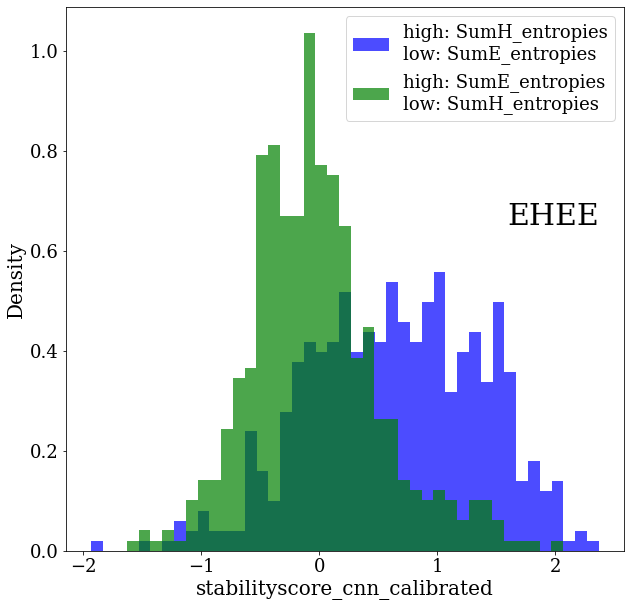

In [94]:
fet_majors = ["SumH_entropies","SumE_entropies"]
#fet_majors2 = ["frac_K_H",'frac_F_E']

fet_minors = ["SumE_entropies",'SumH_entropies']
#fet_minors2 = ["frac_F_E","frac_K_H"]

colors = ["blue",'green']
sizes = [80,50]
shapes = ["x","o"]

alphas = [.7,.7]
n_sigmas_major = 1 # number of standard deviations from the mean that we want as cutoff
n_sigmas_minor = 1

df_topology = df[df["topology"]=="EHEE"]
predicted_var = "stabilityscore_cnn_calibrated"

plt.figure(figsize=(10,10))
for i in range(len(fet_majors)):

    fet_major = fet_majors[i]
    #fet_major2 = fet_majors2[i]
    
    fet_minor = fet_minors[i]
    #fet_minor2 = fet_minors2[i]
    



    fet_major_mean = df_topology[fet_major].mean()
    fet_major_std = df_topology[fet_major].std()
    fet_major_cutoff = fet_major_mean + n_sigmas_major*fet_major_std
    
    
#     fet_major_mean2 = df_topology[fet_major2].mean()
#     fet_major_std2 = df_topology[fet_major2].std()
#     fet_major_cutoff2 = fet_major_mean2 + n_sigmas_major*fet_major_std2
    
    fet_minor_mean = df_topology[fet_minor].mean()
    fet_minor_std = df_topology[fet_minor].std()
    fet_minor_cutoff = fet_minor_mean + n_sigmas_minor*fet_minor_std
    
    
#     fet_minor_mean2 = df_topology[fet_minor2].mean()
#     fet_minor_std2 = df_topology[fet_minor2].std()
#     fet_minor_cutoff2 = fet_minor_mean2 + n_sigmas_minor*fet_minor_std2
    
    #df_sub_majors = df_topology.loc[(df_topology[fet_major]>fet_major_cutoff) & (df_topology[fet_major2] > fet_major_cutoff2),:]
    df_sub_majors = df_topology.loc[(df_topology[fet_major]>fet_major_cutoff),:]
    #df_sub_minors = df_sub_majors.loc[(df_sub_majors[fet_minor]<fet_minor_cutoff) & (df_sub_majors[fet_minor2] < fet_minor_cutoff2),:]
    df_sub_minors = df_sub_majors.loc[(df_sub_majors[fet_minor]<fet_minor_cutoff),:]
    df_sub = df_sub_minors
    #l="high: %s, %s\nlow: %s, %s"%(fet_major,fet_major2,fet_minor,fet_minor2)
    l="high: %s\nlow: %s"%(fet_major,fet_minor)
#     plt.scatter(df_sub[predicted_var],df_sub[predicted_var],
#                 label=l,
#                color = colors[i],alpha=alphas[i],marker=shapes[i],s=sizes[i])
    max_val = max(df_sub[predicted_var]) 
    min_val = min(df_sub[predicted_var])
    plt.hist(x=df_sub[predicted_var],label=l,color=colors[i],alpha=alphas[i],
            bins=list(np.arange(min_val,max_val,.1)),density=True)
plt.legend(fontsize='18')
plt.yticks(fontsize='18')
plt.xticks(fontsize='18')
plt.ylabel("Density",fontsize='20')
plt.xlabel(predicted_var,fontsize='20')
plt.text(x=0.79,y=0.6,s="EHEE",transform = plt.gca().transAxes,fontsize='30')
plt.show()


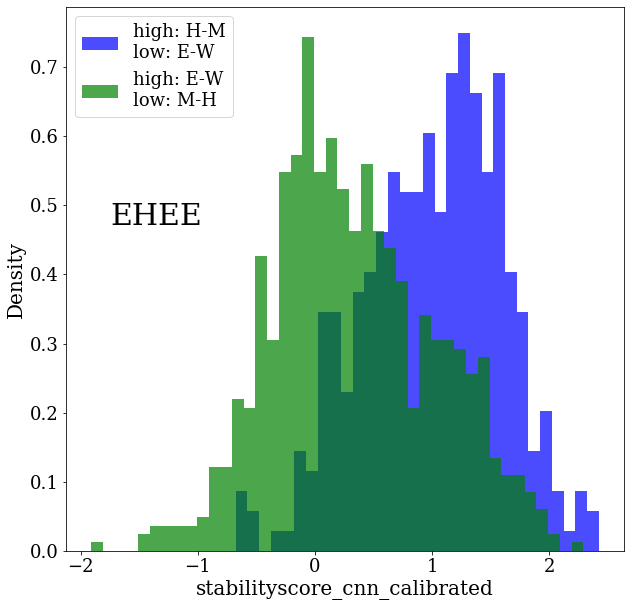

In [95]:
fet_majors = ["frac_M_H","frac_W_E"]
#fet_majors2 = ["frac_W_E",'frac_D_E']

# fet_majors = ["frac_F_H","frac_E_E"]
# fet_majors2 = ["frac_M_H",'frac_K_E']

# fet_minors = ["frac_T_L",'frac_M_H']
# fet_minors2 = ["frac_D_E","frac_W_E"]
fet_minors = ["frac_W_E",'frac_M_H']
# fet_minors = ["frac_E_E",'frac_F_H']
# fet_minors2 = ["frac_K_E","frac_M_H"]

colors = ["blue",'green']
#labels= ["high: H-MF\nlow: E-EK", "high: E-EK\nlow: H-MF"]
#labels= ["high: H-M E-W\nlow: L-T E-D", "high: L-T E-D\nlow: H-M E-W"]
labels= ["high: H-M\nlow: E-W", "high: E-W\nlow: M-H"]
sizes = [80,50]
shapes = ["x","o"]

alphas = [.7,.7]
n_sigmas_major = 1 # number of standard deviations from the mean that we want as cutoff
n_sigmas_minor = 1

df_topology = df[df["topology"]=="EHEE"]
predicted_var = "stabilityscore_cnn_calibrated"

plt.figure(figsize=(10,10))
for i in range(len(fet_majors)):

    fet_major = fet_majors[i]
    #fet_major2 = fet_majors2[i]
    
    fet_minor = fet_minors[i]
    #fet_minor2 = fet_minors2[i]
    



    fet_major_mean = df_topology[fet_major].mean()
    fet_major_std = df_topology[fet_major].std()
    fet_major_cutoff = fet_major_mean + n_sigmas_major*fet_major_std
    
    
#     fet_major_mean2 = df_topology[fet_major2].mean()
#     fet_major_std2 = df_topology[fet_major2].std()
#     fet_major_cutoff2 = fet_major_mean2 + n_sigmas_major*fet_major_std2
    
    fet_minor_mean = df_topology[fet_minor].mean()
    fet_minor_std = df_topology[fet_minor].std()
    fet_minor_cutoff = fet_minor_mean + n_sigmas_minor*fet_minor_std
    
    
#     fet_minor_mean2 = df_topology[fet_minor2].mean()
#     fet_minor_std2 = df_topology[fet_minor2].std()
#     fet_minor_cutoff2 = fet_minor_mean2 + n_sigmas_minor*fet_minor_std2
    
#    df_sub_majors = df_topology.loc[(df_topology[fet_major]>fet_major_cutoff) & (df_topology[fet_major2] > fet_major_cutoff2),:]
    df_sub_majors = df_topology.loc[(df_topology[fet_major]>fet_major_cutoff),:]
#    df_sub_minors = df_sub_majors.loc[(df_sub_majors[fet_minor]<fet_minor_cutoff) & (df_sub_majors[fet_minor2] < fet_minor_cutoff2),:]
    df_sub_minors = df_sub_majors.loc[(df_sub_majors[fet_minor]<fet_minor_cutoff),:]
    df_sub = df_sub_minors
    #l="high: %s, %s\nlow: %s, %s"%(fet_major,fet_major2,fet_minor,fet_minor2)
    l = labels[i]
#     plt.scatter(df_sub[predicted_var],df_sub[predicted_var],
#                 label="high: %s, %s\nlow: %s, %s"%(fet_major,fet_major2,fet_minor,fet_minor2),
#                color = colors[i],alpha=alphas[i],marker=shapes[i],s=sizes[i])

    max_val = max(df_sub[predicted_var]) 
    min_val = min(df_sub[predicted_var])
    

    plt.hist(x=df_sub[predicted_var],label=l,color=colors[i],alpha=alphas[i],bins=list(np.arange(min_val,max_val,.1)),density=True)
    
plt.legend(fontsize='18')
plt.yticks(fontsize='18')
plt.xticks(fontsize='18')
plt.ylabel("Density",fontsize='20')
plt.xlabel(predicted_var,fontsize='20')
plt.text(x=0.08,y=0.6,s="EHEE",transform = plt.gca().transAxes,fontsize='30')
plt.show()


**HEEH proteins**

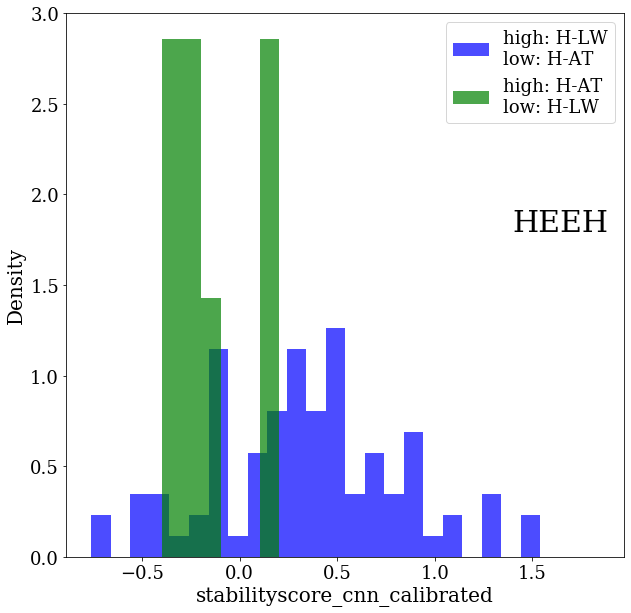

In [96]:
fet_majors = ["frac_L_H","frac_A_H"]
fet_majors2 = ["frac_W_H",'frac_T_H']

fet_minors = ["frac_A_H",'frac_L_H']
fet_minors2 = ["frac_T_H","frac_W_H"]

colors = ["blue",'green']
labels= ["high: H-LW\nlow: H-AT", "high: H-AT\nlow: H-LW"]
sizes = [80,50]
shapes = ["x","o"]

alphas = [.7,.7]
n_sigmas_major = 1 # number of standard deviations from the mean that we want as cutoff
n_sigmas_minor = 1

df_topology = df[df["topology"]=="HEEH"]
predicted_var = "stabilityscore_cnn_calibrated"

plt.figure(figsize=(10,10))
for i in range(len(fet_majors)):

    fet_major = fet_majors[i]
    fet_major2 = fet_majors2[i]
    
    fet_minor = fet_minors[i]
    fet_minor2 = fet_minors2[i]
    



    fet_major_mean = df_topology[fet_major].mean()
    fet_major_std = df_topology[fet_major].std()
    fet_major_cutoff = fet_major_mean + n_sigmas_major*fet_major_std
    
    
    fet_major_mean2 = df_topology[fet_major2].mean()
    fet_major_std2 = df_topology[fet_major2].std()
    fet_major_cutoff2 = fet_major_mean2 + n_sigmas_major*fet_major_std2
    
    fet_minor_mean = df_topology[fet_minor].mean()
    fet_minor_std = df_topology[fet_minor].std()
    fet_minor_cutoff = fet_minor_mean + n_sigmas_minor*fet_minor_std
    
    
    fet_minor_mean2 = df_topology[fet_minor2].mean()
    fet_minor_std2 = df_topology[fet_minor2].std()
    fet_minor_cutoff2 = fet_minor_mean2 + n_sigmas_minor*fet_minor_std2
    
    df_sub_majors = df_topology.loc[(df_topology[fet_major]>fet_major_cutoff) & (df_topology[fet_major2] > fet_major_cutoff2),:]
    df_sub_minors = df_sub_majors.loc[(df_sub_majors[fet_minor]<fet_minor_cutoff) & (df_sub_majors[fet_minor2] < fet_minor_cutoff2),:]
    df_sub = df_sub_minors
    #l="high: %s, %s\nlow: %s, %s"%(fet_major,fet_major2,fet_minor,fet_minor2)
    l = labels[i]
#     plt.scatter(df_sub[predicted_var],df_sub[predicted_var],
#                 label="high: %s, %s\nlow: %s, %s"%(fet_major,fet_major2,fet_minor,fet_minor2),
#                color = colors[i],alpha=alphas[i],marker=shapes[i],s=sizes[i])
    max_val = max(df_sub[predicted_var]) 
    min_val = min(df_sub[predicted_var])
    
    plt.hist(x=df_sub[predicted_var],label=l,color=colors[i],alpha=alphas[i],density=True, bins=list(np.arange(min_val,max_val,.1)))
plt.legend(fontsize='18')
plt.yticks(fontsize='18')
plt.xticks(fontsize='18')
plt.ylabel("Density",fontsize='20')
plt.xlabel(predicted_var,fontsize='20')
plt.text(x=0.80,y=0.6,s="HEEH",transform = plt.gca().transAxes,fontsize='30')
plt.show()


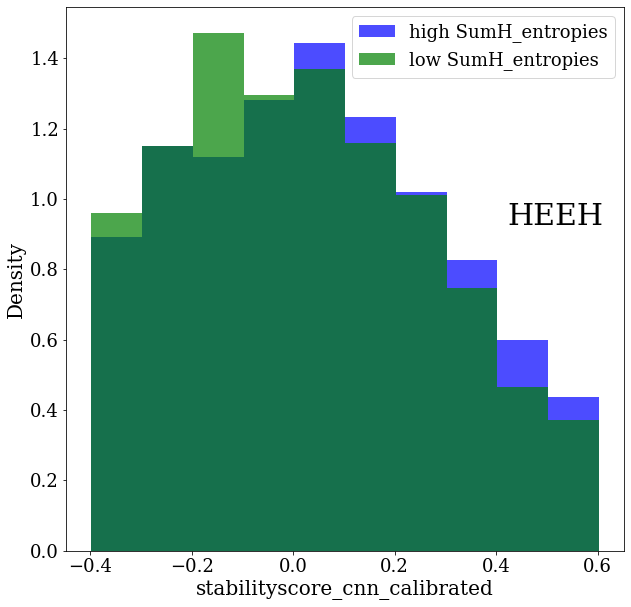

In [97]:
fet_majors = ["SumH_entropies"]
#fet_majors2 = ["frac_K_H",'frac_F_E']

fet_minors = ["SumH_entropies"]
#fet_minors2 = ["frac_F_E","frac_K_H"]

colors = ["blue",'green']
sizes = [80,50]
shapes = ["x","o"]

alphas = [.7,.7]
n_sigmas_major = 1 # number of standard deviations from the mean that we want as cutoff
n_sigmas_minor = 1

df_topology = df[df["topology"]=="HEEH"]
predicted_var = "stabilityscore_cnn_calibrated"

plt.figure(figsize=(10,10))
for i in range(len(fet_majors)):

    fet_major = fet_majors[i]
    #fet_major2 = fet_majors2[i]
    
    fet_minor = fet_minors[i]
    #fet_minor2 = fet_minors2[i]
    



    fet_major_mean = df_topology[fet_major].mean()
    fet_major_std = df_topology[fet_major].std()
    fet_major_cutoff = fet_major_mean + n_sigmas_major*fet_major_std
    
    
#     fet_major_mean2 = df_topology[fet_major2].mean()
#     fet_major_std2 = df_topology[fet_major2].std()
#     fet_major_cutoff2 = fet_major_mean2 + n_sigmas_major*fet_major_std2
    
    fet_minor_mean = df_topology[fet_minor].mean()
    fet_minor_std = df_topology[fet_minor].std()
    fet_minor_cutoff = fet_minor_mean + n_sigmas_minor*fet_minor_std
    
    
#     fet_minor_mean2 = df_topology[fet_minor2].mean()
#     fet_minor_std2 = df_topology[fet_minor2].std()
#     fet_minor_cutoff2 = fet_minor_mean2 + n_sigmas_minor*fet_minor_std2
    
    #df_sub_majors = df_topology.loc[(df_topology[fet_major]>fet_major_cutoff) & (df_topology[fet_major2] > fet_major_cutoff2),:]
    df_sub_majors = df_topology.loc[(df_topology[fet_major]>fet_major_cutoff),:]
    #df_sub_minors = df_sub_majors.loc[(df_sub_majors[fet_minor]<fet_minor_cutoff) & (df_sub_majors[fet_minor2] < fet_minor_cutoff2),:]
    df_sub_minors = df_topology.loc[(df_topology[fet_minor]<fet_minor_cutoff),:]


    max_val = max(df_sub[predicted_var]) 
    min_val = min(df_sub[predicted_var])
    
    plt.hist(x=df_sub_majors[predicted_var],label="high SumH_entropies",color=colors[i],alpha=alphas[i],
            bins=list(np.arange(min_val,max_val,.1)),density=True)
    plt.hist(x=df_sub_minors[predicted_var],label="low SumH_entropies",color=colors[i+1],alpha=alphas[i],
            bins=list(np.arange(min_val,max_val,.1)),density=True)
plt.legend(fontsize='18')
plt.yticks(fontsize='18')
plt.xticks(fontsize='18')
plt.ylabel("Density",fontsize='20')
plt.xlabel(predicted_var,fontsize='20')
plt.text(x=0.79,y=0.6,s="HEEH",transform = plt.gca().transAxes,fontsize='30')
plt.show()


**HHH proteins**

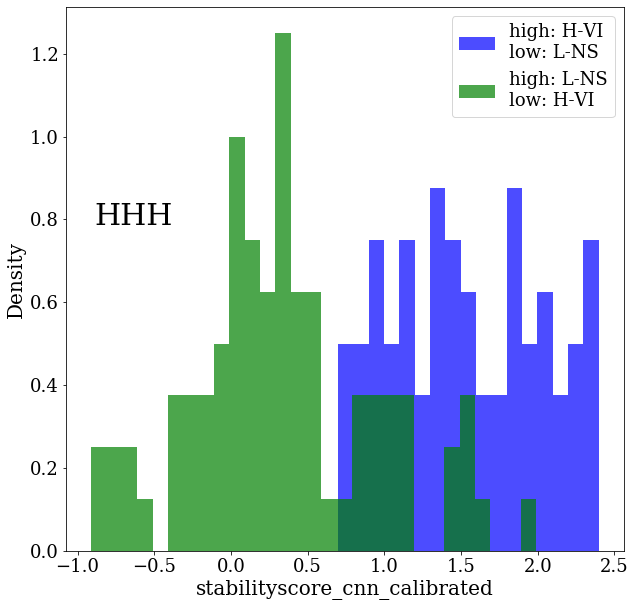

In [98]:
fet_majors = ["frac_V_H","frac_N_L"]
fet_majors2 = ["frac_I_H",'frac_S_L']


fet_minors = ["frac_N_L",'frac_V_H']
fet_minors2 = ["frac_S_L","frac_I_H"]

colors = ["blue",'green']
labels= ["high: H-VI\nlow: L-NS", "high: L-NS\nlow: H-VI"]
#labels= ["high: H-M E-W\nlow: L-T E-D", "high: L-T E-E\nlow: H-M E-W"]
sizes = [80,50]
shapes = ["x","o"]

alphas = [.7,.7]
n_sigmas_major = 1 # number of standard deviations from the mean that we want as cutoff
n_sigmas_minor = 1

df_topology = df[df["topology"]=="HHH"]
predicted_var = "stabilityscore_cnn_calibrated"

plt.figure(figsize=(10,10))
for i in range(len(fet_majors)):

    fet_major = fet_majors[i]
    fet_major2 = fet_majors2[i]
    
    fet_minor = fet_minors[i]
    fet_minor2 = fet_minors2[i]
    



    fet_major_mean = df_topology[fet_major].mean()
    fet_major_std = df_topology[fet_major].std()
    fet_major_cutoff = fet_major_mean + n_sigmas_major*fet_major_std
    
    
    fet_major_mean2 = df_topology[fet_major2].mean()
    fet_major_std2 = df_topology[fet_major2].std()
    fet_major_cutoff2 = fet_major_mean2 + n_sigmas_major*fet_major_std2
    
    fet_minor_mean = df_topology[fet_minor].mean()
    fet_minor_std = df_topology[fet_minor].std()
    fet_minor_cutoff = fet_minor_mean + n_sigmas_minor*fet_minor_std
    
    
    fet_minor_mean2 = df_topology[fet_minor2].mean()
    fet_minor_std2 = df_topology[fet_minor2].std()
    fet_minor_cutoff2 = fet_minor_mean2 + n_sigmas_minor*fet_minor_std2
    
    df_sub_majors = df_topology.loc[(df_topology[fet_major]>fet_major_cutoff) & (df_topology[fet_major2] > fet_major_cutoff2),:]
    df_sub_minors = df_sub_majors.loc[(df_sub_majors[fet_minor]<fet_minor_cutoff) & (df_sub_majors[fet_minor2] < fet_minor_cutoff2),:]
    df_sub = df_sub_minors
    #l="high: %s, %s\nlow: %s, %s"%(fet_major,fet_major2,fet_minor,fet_minor2)
    l = labels[i]
#     plt.scatter(df_sub[predicted_var],df_sub[predicted_var],
#                 label="high: %s, %s\nlow: %s, %s"%(fet_major,fet_major2,fet_minor,fet_minor2),
#                color = colors[i],alpha=alphas[i],marker=shapes[i],s=sizes[i])
    max_val = max(df_sub[predicted_var]) 
    min_val = min(df_sub[predicted_var])
    plt.hist(x=df_sub[predicted_var],label=l,color=colors[i],alpha=alphas[i],density=True,
            bins=list(np.arange(min_val,max_val,.1)))
plt.legend(fontsize='18')
plt.yticks(fontsize='18')
plt.xticks(fontsize='18')
plt.ylabel("Density",fontsize='20')
plt.xlabel(predicted_var,fontsize='20')
plt.text(x=0.05,y=0.6,s="HHH",transform = plt.gca().transAxes,fontsize='30')
plt.show()


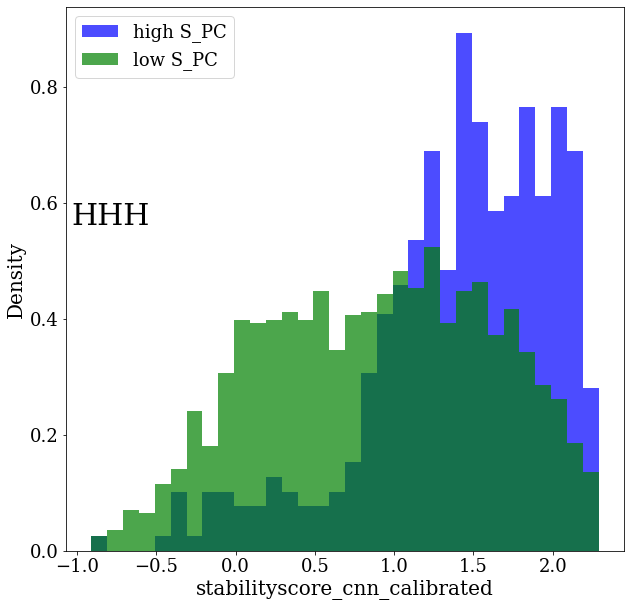

In [99]:
fet_majors = ["S_PC"]
#fet_majors2 = ["frac_K_H",'frac_F_E']

fet_minors = ["S_PC"]
#fet_minors2 = ["frac_F_E","frac_K_H"]

colors = ["blue",'green']
sizes = [80,50]
shapes = ["x","o"]

alphas = [.7,.7]
n_sigmas_major = 1 # number of standard deviations from the mean that we want as cutoff
n_sigmas_minor = 1

df_topology = df[df["topology"]=="HHH"]
predicted_var = "stabilityscore_cnn_calibrated"

plt.figure(figsize=(10,10))
for i in range(len(fet_majors)):

    fet_major = fet_majors[i]
    #fet_major2 = fet_majors2[i]
    
    fet_minor = fet_minors[i]
    #fet_minor2 = fet_minors2[i]
    



    fet_major_mean = df_topology[fet_major].mean()
    fet_major_std = df_topology[fet_major].std()
    fet_major_cutoff = fet_major_mean + n_sigmas_major*fet_major_std
    
    
#     fet_major_mean2 = df_topology[fet_major2].mean()
#     fet_major_std2 = df_topology[fet_major2].std()
#     fet_major_cutoff2 = fet_major_mean2 + n_sigmas_major*fet_major_std2
    
    fet_minor_mean = df_topology[fet_minor].mean()
    fet_minor_std = df_topology[fet_minor].std()
    fet_minor_cutoff = fet_minor_mean + n_sigmas_minor*fet_minor_std
    
    
#     fet_minor_mean2 = df_topology[fet_minor2].mean()
#     fet_minor_std2 = df_topology[fet_minor2].std()
#     fet_minor_cutoff2 = fet_minor_mean2 + n_sigmas_minor*fet_minor_std2
    
    #df_sub_majors = df_topology.loc[(df_topology[fet_major]>fet_major_cutoff) & (df_topology[fet_major2] > fet_major_cutoff2),:]
    df_sub_majors = df_topology.loc[(df_topology[fet_major]>fet_major_cutoff),:]
    #df_sub_minors = df_sub_majors.loc[(df_sub_majors[fet_minor]<fet_minor_cutoff) & (df_sub_majors[fet_minor2] < fet_minor_cutoff2),:]
    df_sub_minors = df_topology.loc[(df_topology[fet_minor]<fet_minor_cutoff),:]

    max_val = max(df_sub[predicted_var]) 
    min_val = min(df_sub[predicted_var])


    plt.hist(x=df_sub_majors[predicted_var],label="high S_PC",color=colors[i],alpha=alphas[i],
            bins=list(np.arange(min_val,max_val,.1)),density=True)
    plt.hist(x=df_sub_minors[predicted_var],label="low S_PC",color=colors[i+1],alpha=alphas[i],
            bins=list(np.arange(min_val,max_val,.1)),density=True)
plt.legend(fontsize='18')
plt.yticks(fontsize='18')
plt.xticks(fontsize='18')
plt.ylabel("Density",fontsize='20')
plt.xlabel(predicted_var,fontsize='20')
plt.text(x=0.01,y=0.6,s="HHH",transform = plt.gca().transAxes,fontsize='30')
plt.show()


### Correlation between Sum[HLE]_entropies? 

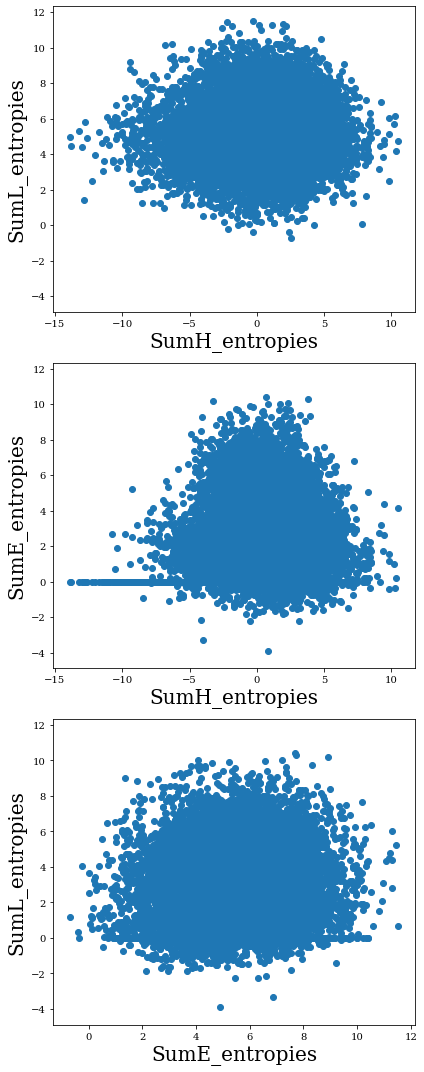

In [100]:
f,ax = plt.subplots(nrows=3,sharey=True,figsize=(6,15))
ax[0].scatter(df["SumH_entropies"].values,df["SumL_entropies"].values)
ax[0].set_ylabel("SumL_entropies",fontsize='20')
ax[0].set_xlabel("SumH_entropies",fontsize='20')



ax[1].scatter(df["SumH_entropies"].values,df["SumE_entropies"].values)
ax[1].set_ylabel("SumE_entropies",fontsize='20')
ax[1].set_xlabel("SumH_entropies",fontsize='20')

ax[2].scatter(df["SumL_entropies"].values,df["SumE_entropies"].values)
ax[2].set_ylabel("SumL_entropies",fontsize='20')
ax[2].set_xlabel("SumE_entropies",fontsize='20')




plt.tight_layout()
plt.show()

R2 Score:  0.37850679531955544
RMSE/Range:  0.10988936043148673
MAE/Range:  0.08416619789919158


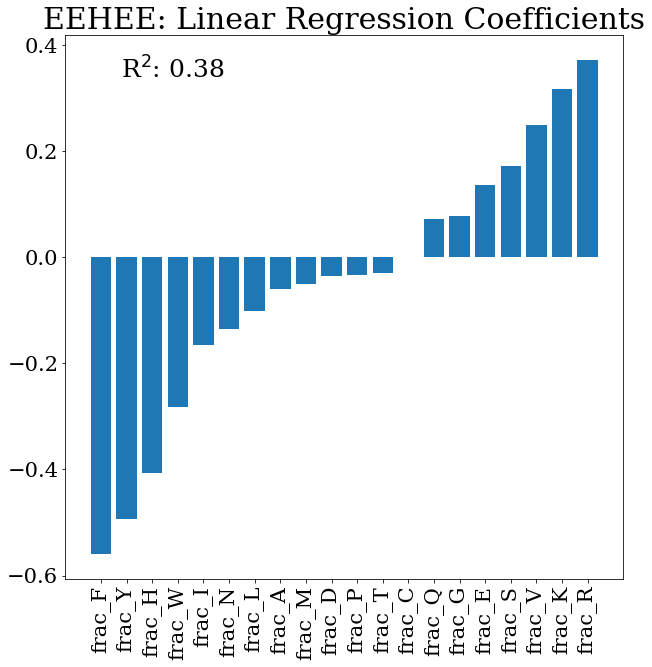

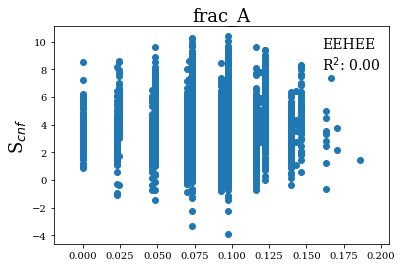

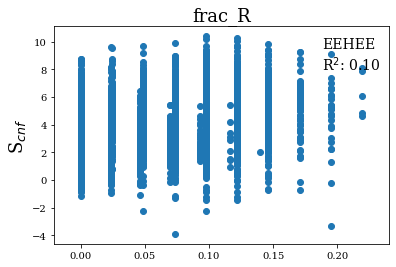

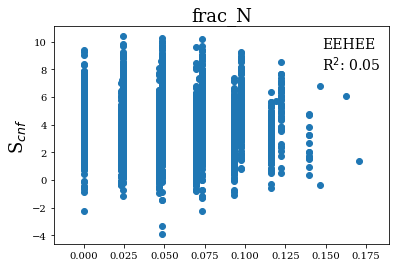

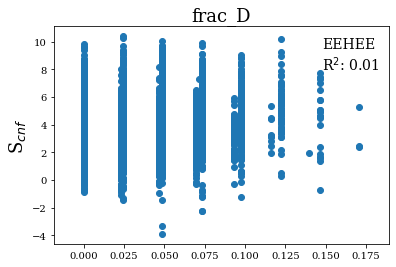

KeyboardInterrupt: 

In [101]:

# reduce dataset to relevant topology
topology = "EEHEE"
sub_df = df[df["topology"]==topology]

# do train-test split
train, test = train_test_split(sub_df[frac_aas+["SumE_entropies"]], test_size=0.2, random_state=5)

# train lnr and visualize coefs


#set up splits
X_train = train[frac_aas]
y_train = train["SumE_entropies"]

X_test = test[frac_aas]
y_test = test["SumE_entropies"]

#standardize features
scaler = StandardScaler()
scaler.fit(X_train)

X_train_std = pd.DataFrame(scaler.transform(X_train),columns=X_train.columns)
X_test_std = pd.DataFrame(scaler.transform(X_test),columns=X_test.columns)

#merged X and y data
X = pd.concat([X_train_std,X_test_std])
X = X.reset_index(drop=True)

y = pd.concat([y_train,y_test])
y = y.reset_index(drop=True)



#set up a linear regression trained to predict SumE_entropies
model_lnr = LinearRegression(normalize=False)

#fit the data
model_lnr.fit(X_train_std,y_train)

#predict
y_pred_lnr = model_lnr.predict(X_test_std)

#get results
print("R2 Score: ",r2_score(y_test.values,y_pred_lnr))
range_spc = y_test.max() - y_test.min() #get range of predicted values
print("RMSE/Range: ",np.sqrt(mean_squared_error(y_test.values,y_pred_lnr))/range_spc)
print("MAE/Range: ",mean_absolute_error(y_test.values,y_pred_lnr)/range_spc)

zipped_coeff = zip(frac_aas,list(model_lnr.coef_))
coeff_dict = {}
for pair in zipped_coeff:
    #print(pair)
    if abs(pair[1]):
        coeff_dict[pair[0]] = pair[1]

sorted_dict_tuple = sorted(coeff_dict.items(), key=operator.itemgetter(1))
sorted_coeff_dict = dict(sorted_dict_tuple)

sorted_coeffs = [sorted_coeff_dict[key] for key in sorted_coeff_dict]
f, ax = plt.subplots(figsize=(10,10))
ax.bar(sorted_coeff_dict.keys(), sorted_coeffs)
plt.xticks(rotation="90",fontsize="21")
plt.yticks(fontsize='21')
plt.text(x=0.1, y=0.92, s="R$^{2}$: %0.2f"%r2_score(y_test.values,y_pred_lnr),transform=ax.transAxes,fontsize='25')
plt.title("%s: Linear Regression Coefficients"%topology,fontsize=30)
plt.show()




for i in range(len(frac_aas)):
    aa = frac_aas[i]
    plt.figure()
    plt.scatter(sub_df[aa],sub_df["SumE_entropies"])
    plt.title(aa,fontsize='18')
    plt.ylabel("S$_{cnf}$",fontsize='18')
    ax = plt.gca()
    plt.text(.80,.8,s="%s\nR$^{2}$: %0.2f"%(topology,train_linear_regression_flexible([aa],predicted_variable)), transform=ax.transAxes,fontsize='14')
    plt.show()


# Frac_AA vs stability?

In [ ]:
f, ax = plt.subplots(nrows=2,figsize=(12,12))
# reduce dataset to relevant topology
topology = "EEHEE"
pred_vars = ['stabilityscore_cnn_calibrated','S_PC']
a=0.0
for iVar in range(len(pred_vars)):
    predicted_variable  = pred_vars[iVar] 
    sub_df = df[df["topology"]==topology]

    sub_fets = [i for i in frac_aas_ss if i[-1]=="H"] #only look at the beta sheet frac's
    #sub_fets = frac_aas_ss

    # do train-test split
    train, test = train_test_split(sub_df[sub_fets+[predicted_variable]], test_size=0.2, random_state=5)

    # train lnr and visualize coefs

    #set up splits
    X_train = train[sub_fets]
    y_train = train[predicted_variable]

    X_test = test[sub_fets]
    y_test = test[predicted_variable]

    #standardize features
    scaler = StandardScaler()
    scaler.fit(X_train)

    X_train_std = pd.DataFrame(scaler.transform(X_train),columns=X_train.columns)
    X_test_std = pd.DataFrame(scaler.transform(X_test),columns=X_test.columns)

    #merged X and y data
    X = pd.concat([X_train_std,X_test_std])
    X = X.reset_index(drop=True)

    y = pd.concat([y_train,y_test])
    y = y.reset_index(drop=True)



    #set up a linear regression trained to predict SumE_entropies
    #model_lnr = LinearRegression(normalize=False)
    model_lnr = Lasso(alpha=a)
    #fit the data
    model_lnr.fit(X_train_std,y_train)

    #predict
    y_pred_lnr = model_lnr.predict(X_test_std)

    #get results
    print("R2 Score: ",r2_score(y_test.values,y_pred_lnr))
    range_spc = y_test.max() - y_test.min() #get range of predicted values
    print("RMSE/Range: ",np.sqrt(mean_squared_error(y_test.values,y_pred_lnr))/range_spc)
    print("MAE/Range: ",mean_absolute_error(y_test.values,y_pred_lnr)/range_spc)

    zipped_coeff = zip(sub_fets,list(model_lnr.coef_))
    coeff_dict = {}
    for pair in zipped_coeff:
        #print(pair)
        if abs(pair[1]):
            coeff_dict[pair[0]] = pair[1]

    sorted_dict_tuple = sorted(coeff_dict.items(), key=operator.itemgetter(1))
    sorted_coeff_dict = dict(sorted_dict_tuple)

    sorted_coeffs = [sorted_coeff_dict[key] for key in sorted_coeff_dict]
    #f, ax = plt.subplots(figsize=(30,5))
    ax[iVar].bar(sorted_coeff_dict.keys(), sorted_coeffs)
    #ax[iVar].set_xticks(rotation="45",fontsize="21")
    #ax[iVar].yticks(fontsize='21')
    plt.ylabel(predicted_variable,fontsize='20')
    #plt.yscale("log")
    #ax[iVar].text(x=0.80, y=0.080, s=,transform=ax[iVar].transAxes,fontsize='25')
    textstr = "α = %s, R² = %0.3f"%(a,r2_score(y_test.values,y_pred_lnr))
    # these are matplotlib.patch.Patch properties
    props = dict(boxstyle='round', facecolor='white', alpha=0.5)
    ax[iVar].text(0.05, 0.95, textstr, transform=ax[iVar].transAxes, fontsize=30,
        verticalalignment='top',bbox=props)
    
    #plt.title("%s: Linear Regression Coefficients"%topology,fontsize=30)
    ax[iVar].set_xticklabels(sorted_coeff_dict.keys(),rotation="60",fontsize='21')
    ax[iVar].set_ylabel(predicted_variable,fontsize='20')
    ax[iVar].set_yticklabels([round(i,2) for i in ax[iVar].get_yticks()],fontsize='21')
ax[0].set_title("%s"%topology,fontsize='30')
plt.tight_layout()
plt.show()




#     for i in range(len(sub_fets)):
#         aa = sub_fets[i]
#         plt.figure()
#         plt.scatter(sub_df[aa],sub_df[predicted_variable])
#         plt.title(aa,fontsize='18')
#         plt.ylabel(predicted_variable,fontsize='18')
#         ax = plt.gca()
#         plt.text(.80,.8,s="%s\nR$^{2}$: %0.2f"%(topology,train_linear_regression_flexible([aa],predicted_variable)), transform=ax.transAxes,fontsize='14')
#         plt.show()


In [ ]:
f, ax = plt.subplots(nrows=4,figsize=(20,24))
topologies = ["EEHEE","EHEE","HHH",'HEEH']
pred_vars = ['stabilityscore_cnn_calibrated']
# reduce dataset to relevant topology
a=0.0

for iTop in range(len(topologies)):
    topology = topologies[iTop]
    for iVar in range(len(pred_vars)):
        predicted_variable  = pred_vars[iVar] 
        sub_df = df[df["topology"]==topology]

        #sub_fets = [i for i in frac_aas_ss if i[-1]=="H"] #only look at the beta sheet frac's
        sub_fets = frac_aas_ss

        # do train-test split
        train, test = train_test_split(sub_df[sub_fets+[predicted_variable]], test_size=0.2, random_state=5)

        # train lnr and visualize coefs

        #set up splits
        X_train = train[sub_fets]
        y_train = train[predicted_variable]

        X_test = test[sub_fets]
        y_test = test[predicted_variable]

        #standardize features
        scaler = StandardScaler()
        scaler.fit(X_train)

        X_train_std = pd.DataFrame(scaler.transform(X_train),columns=X_train.columns)
        X_test_std = pd.DataFrame(scaler.transform(X_test),columns=X_test.columns)

        #merged X and y data
        X = pd.concat([X_train_std,X_test_std])
        X = X.reset_index(drop=True)

        y = pd.concat([y_train,y_test])
        y = y.reset_index(drop=True)



        #set up a linear regression trained to predict SumE_entropies
        #model_lnr = LinearRegression(normalize=False)
        model_lnr = Lasso(alpha=a)
        #fit the data
        model_lnr.fit(X_train_std,y_train)

        #predict
        y_pred_lnr = model_lnr.predict(X_test_std)

        #get results
        print("R2 Score: ",r2_score(y_test.values,y_pred_lnr))
        range_spc = y_test.max() - y_test.min() #get range of predicted values
        print("RMSE/Range: ",np.sqrt(mean_squared_error(y_test.values,y_pred_lnr))/range_spc)
        print("MAE/Range: ",mean_absolute_error(y_test.values,y_pred_lnr)/range_spc)

        zipped_coeff = zip(sub_fets,list(model_lnr.coef_))
        coeff_dict = {}
        for pair in zipped_coeff:
            #print(pair)
            if abs(pair[1]):
                coeff_dict[pair[0]] = pair[1]

        sorted_dict_tuple = sorted(coeff_dict.items(), key=operator.itemgetter(1))
        sorted_coeff_dict = dict(sorted_dict_tuple)

        sorted_coeffs = [sorted_coeff_dict[key] for key in sorted_coeff_dict]
        #f, ax = plt.subplots(figsize=(30,5))
        ax[iTop].bar(sorted_coeff_dict.keys(), sorted_coeffs)
        #ax[iVar].set_xticks(rotation="45",fontsize="21")
        #ax[iVar].yticks(fontsize='21')
        plt.ylabel(predicted_variable,fontsize='20')
        #plt.yscale("log")
        #ax[iVar].text(x=0.80, y=0.080, s=,transform=ax[iVar].transAxes,fontsize='25')
        textstr = "α = %s, R² = %0.3f"%(a,r2_score(y_test.values,y_pred_lnr))
        textstr2 = "%s"%topology
        # these are matplotlib.patch.Patch properties
        props = dict(boxstyle='round', facecolor='white', alpha=0.5)
        ax[iTop].text(0.05, 0.95, textstr, transform=ax[iTop].transAxes, fontsize=30,
            verticalalignment='top',bbox=props)
        
        ax[iTop].text(0.5, 0.95, textstr2, transform=ax[iTop].transAxes, fontsize=30,
            verticalalignment='top')

        #plt.title("%s: Linear Regression Coefficients"%topology,fontsize=30)
        ax[iTop].set_xticklabels(sorted_coeff_dict.keys(),rotation="90",fontsize='21')
        ax[iTop].set_ylabel(predicted_variable,fontsize='20')
        ax[iTop].set_yticklabels([round(i,2) for i in ax[iVar].get_yticks()],fontsize='21')
    #ax[0].set_title("%s"%topology,fontsize='30')
plt.tight_layout()
plt.show()




    #     for i in range(len(sub_fets)):
    #         aa = sub_fets[i]
    #         plt.figure()
    #         plt.scatter(sub_df[aa],sub_df[predicted_variable])
    #         plt.title(aa,fontsize='18')
    #         plt.ylabel(predicted_variable,fontsize='18')
    #         ax = plt.gca()
    #         plt.text(.80,.8,s="%s\nR$^{2}$: %0.2f"%(topology,train_linear_regression_flexible([aa],predicted_variable)), transform=ax.transAxes,fontsize='14')
    #         plt.show()


# Model Audit

In [ ]:
import shap
import time
import warnings
warnings.filterwarnings('ignore')

In [ ]:
file_path = './data/df_aggregated_spc.csv'
combined_data = pd.read_csv(file_path)
combined_data['dataset_original'] = combined_data['dataset']

#NTF2 topology should not be used so remove those rows
ntf2_inx = combined_data[combined_data['topology']=='NTF2'].index
combined_data = combined_data.drop(ntf2_inx)


print("Before: ",len(combined_data))

#make sure you only use Rocklin library
combined_data = combined_data[combined_data["dataset"]=="Rocklin"].reset_index(drop="True")



print("After: ",len(combined_data))

col_order = list(combined_data.columns.values)
col_order.insert(2, col_order.pop(col_order.index('dataset_original')))
combined_data = combined_data[col_order]
combined_data['stabilityscore_cnn_calibrated_2classes'] = combined_data['stabilityscore_cnn_calibrated'] > 1


train, test = train_test_split(combined_data, test_size=0.2, random_state=5, stratify=combined_data[['topology', 'dataset_original']])

# list of feature columns to use and/or normalize:
ros_fet_path =  './data/rosetta_features.csv'
spc_fet_path =  './data/entropy_features.csv'

ros_features = list(pd.read_csv(ros_fet_path).iloc[:,0])
spc_features = list(pd.read_csv(spc_fet_path).iloc[:,0])


feature_cols = ros_features+spc_features


In [ ]:
### Data Split

#set up splits
X_train = train[ros_features]
y_train = train["S_PC"]

X_test = test[ros_features]
y_test = test["S_PC"]

#standardize features
scaler = StandardScaler()
scaler.fit(X_train)

X_train_std = pd.DataFrame(scaler.transform(X_train),columns=X_train.columns)
X_test_std = pd.DataFrame(scaler.transform(X_test),columns=X_test.columns)

#merged X and y data
X = pd.concat([X_train_std,X_test_std])
X = X.reset_index(drop=True)

y = pd.concat([y_train,y_test])
y = y.reset_index(drop=True)

## Linear Regression

#set up a linear regression trained to predict S_PC
model_lnr = LinearRegression(normalize=False)

#fit the data
model_lnr.fit(X_train_std,y_train)

#predict
y_pred_lnr = model_lnr.predict(X_test_std)

#get results
print("R2 Score: ",r2_score(y_test.values,y_pred_lnr))
range_spc = y_test.max() - y_test.min() #get range of predicted values
print("RMSE/Range: ",np.sqrt(mean_squared_error(y_test.values,y_pred_lnr))/range_spc)
print("MAE/Range: ",mean_absolute_error(y_test.values,y_pred_lnr)/range_spc)

In [ ]:
features = ros_features
train_X = X_train
test_X = X_test

train_X_df = pd.DataFrame(data=train_X, columns=features)
test_X_df = pd.DataFrame(data=test_X, columns=features)

In [ ]:
X_train_summary = shap.kmeans(train_X, 10)

shap.initjs()      

explainer = shap.KernelExplainer(model_lnr.predict, X_train_summary)

In [ ]:
# this was already 
shap_values = explainer.shap_values(test_X_df)

means = []

totals_list = [0.0 for f in features]

In [ ]:
for val_list in shap_values:
    for i in range(0, len(val_list)):
        totals_list[i] += np.fabs(val_list[i])
means = [(feat, total / len(shap_values)) for feat, total in zip(features, totals_list)]
# mean_shaps are returned for use as feature_importances
mean_shaps = sorted(means, key=itemgetter(1), reverse=True)

In [ ]:
shap_values_df = pd.DataFrame(shap_values,columns=test_X_df.columns)
# shap_values_df.to_csv("shap_values_df.csv",index=False)

In [ ]:
shap.summary_plot(shap_values, test_X_df, show=False, plot_type="dot")

In [ ]:
test.reset_index()[20:40]

In [ ]:
# force plot for an EEHEE protein
print("\tEEHEE")
shap.force_plot(explainer.expected_value, shap_values[0, :], test_X_df.iloc[0, :], matplotlib=True, show=True)

# force plot for an EHEE protein
print("\tEHEE")
shap.force_plot(explainer.expected_value, shap_values[-1, :], test_X_df.iloc[-1, :], matplotlib=True, show=True)

# force plot for an HEEH protein
print("\tHEEH")
shap.force_plot(explainer.expected_value, shap_values[-2, :], test_X_df.iloc[-2, :], matplotlib=True, show=True)

#force plot for an HHH protein
print("\tHHH")
shap.force_plot(explainer.expected_value, shap_values[33, :], test_X_df.iloc[33, :], matplotlib=True, show=True)

In [ ]:
shap.summary_plot(shap_values, test_X_df, plot_type="bar", show=True)

In [ ]:
shap.dependence_plot('contact_all',shap_values, test_X_df,interaction_index="contact_core_SCN")

### Downselected features audit (R² = .703 model)

In [ ]:
features = ros_features
train_X = X_train_std
test_X = X_test_std

train_X_df = pd.DataFrame(data=train_X, columns=features)
test_X_df = pd.DataFrame(data=test_X, columns=features)

X_train_summary = shap.kmeans(train_X, 10)

shap.initjs()      

explainer = shap.KernelExplainer(lasso_models[-2].predict, X_train_summary)

# this was already 
shap_values = explainer.shap_values(test_X_df)

means = []

totals_list = [0.0 for f in features]

for val_list in shap_values:
    for i in range(0, len(val_list)):
        totals_list[i] += np.fabs(val_list[i])
means = [(feat, total / len(shap_values)) for feat, total in zip(features, totals_list)]
# mean_shaps are returned for use as feature_importances
mean_shaps = sorted(means, key=itemgetter(1), reverse=True)

shap_values_df = pd.DataFrame(shap_values,columns=test_X_df.columns)
#shap_values_df.to_csv("shap_values_df.csv",index=False)

In [ ]:
for val_list in shap_values:
    for i in range(0, len(val_list)):
        totals_list[i] += np.fabs(val_list[i])
means = [(feat, total / len(shap_values)) for feat, total in zip(features, totals_list)]
# mean_shaps are returned for use as feature_importances
mean_shaps = sorted(means, key=itemgetter(1), reverse=True)

shap_values_df = pd.DataFrame(shap_values,columns=test_X_df.columns)
#shap_values_df.to_csv("shap_values_df.csv",index=False)

shap.summary_plot(shap_values, test_X_df, show=False, plot_type="dot")
#plt.savefig("Figure6a",dpi=300,bbox_inches="tight")